🔥Exploration of Classier models for Deep Tennis Learning

The Methodology is the following : 
1- Get lags that make sense to give a pseudo temporal information of Before Bounce and After Bounce data

Iterate for several Classifier 
2- Explore a model
   Get best Params
   Get final score based on Precision ( limit a maximum the False Positif Rebounds
   Check the confusion Matrix ( to avoid too large False Negatif)
   Plot True Rebounds and False Rebounds for Visual Checking
   
3 Publish Results of all Clasifiers

### Libraries

1. Let's import the usual libraries:

In [125]:
from io import StringIO

import requests
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

DATA_URL = 'https://github.com/ArtLabss/tennis-tracking/raw/main/Bounces/BigDataFrame.csv'
resp = requests.get(DATA_URL)
df_ball = pd.read_csv(StringIO(resp.text))
print(df_ball.columns)
print(df_ball.shape)



Index(['x', 'y', 'V', 'bounce'], dtype='object')
(3674, 4)


###  INVESTIGATAGE BEST LAGS 
with roc_auc_score and a Random Forest ( better preinvestigation than Linear Regression and KNN)


In [104]:
def lag_df(df_ball,lag):
    df = df_ball.drop(columns='bounce')
    df = df.shift(lag) - df
    df.rename(columns={'x':f'x_lagdelta:{lag}', 'y':f'y_lagdelta:{lag}', 'V':f'V_lagdelta:{lag}'}, inplace=True)
    return df

In [105]:
def create_lag(df_ball,nb_lag,nb_steps,past_only) :

    my_table=[]
    if nb_steps==1 and past_only==1 :
        for i in range(nb_lag):
            my_table.append(-nb_lag+i)
            
    elif nb_steps==1 and past_only==0 :
        start=-int(nb_lag/2)
        stop=int(nb_lag/2)
        if (nb_lag%2==1) : 
            stop+=1
        for i in range(start,stop):
            my_table.append(i)
            
    elif nb_steps==2 and past_only==1 :
        for i in range(nb_lag):
            my_table.append(-2*(nb_lag+i))
            
    elif nb_steps==2 and past_only==0 :
        start=-int(nb_lag/2)
        stop=int(nb_lag/2)
        if (nb_lag%2==1) : 
            stop+=1
        for i in range(start,stop):
            my_table.append(2*i)
        
    df_ball_lag = pd.concat([
         *(lag_df(df_ball,i) for i in my_table ),
         df_ball
     ], axis=1)
    
    df_ball_lag = df_ball_lag.dropna()

    return df_ball_lag



In [106]:
def create_train_split (df_ball_lag) :
    
    nb_test = 800
    X = df_ball_lag.iloc[:, :-1]
    X=X.drop(columns=['x','y','V'])
    y = df_ball_lag.iloc[:, -1]
    X_train = X.iloc[:-nb_test, :]
    y_train = y.iloc[:-nb_test] 
    X_test = X.iloc[-nb_test:, :]
    y_test = y.iloc[-nb_test:]
    return X_train,y_train,X_test,y_test




In [231]:
def fit_model(model1,X_train,y_train,X_test):
 
    model = make_pipeline(StandardScaler(),model1)
    model.fit(X_train, y_train)
    return model

In [138]:
def evaluate_score(my_roc_auc_score_pastonly_dict) : 
    max_val = max(my_roc_auc_score_pastonly_dict.values())
    max_keys = [k for k, v in my_roc_auc_score_pastonly_dict.items() if v == max_val]
    print(f"Best ROC score is {max_val} found for the lags : {max_keys}")

### test lag with Past values

In [139]:
STEPS=1
PAST_ONLY=1
start_time = time.time()
n_estimators_val=[100,300,500,1000]

for n_estimators in n_estimators_val:
    model=RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)

    my_roc_auc_score_pastonly_dict={}
    for i in range (3,20) :
        df_ball_lag = create_lag(df_ball,nb_lag=i,nb_steps=STEPS,past_only=PAST_ONLY)
        X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
        model_fitted = fit_model(model,X_train,y_train,X_test)
        y_test_pred_proba=model_fitted.predict_proba(X_test)[:,1]
        
        score=round(roc_auc_score(y_test, y_test_pred_proba),2)
        my_roc_auc_score_pastonly_dict[i]=score

    evaluate_score(my_roc_auc_score_pastonly_dict)
    print("--- %s seconds ---" % round((time.time() - start_time),1))


Best ROC score is 0.82 found for the lags : [17]
--- 9.6 seconds ---
Best ROC score is 0.86 found for the lags : [19]
--- 37.7 seconds ---
Best ROC score is 0.86 found for the lags : [19]
--- 84.6 seconds ---
Best ROC score is 0.85 found for the lags : [19]
--- 176.0 seconds ---


In [132]:
STEPS=2
PAST_ONLY=1
n_estimators_val=[100,300,500,1000]

start_time = time.time()
for n_estimators in n_estimators_val:
    model=RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)

    my_roc_auc_score_pastonly_dict={}
    for i in range (3,20) :
        df_ball_lag = create_lag(df_ball,nb_lag=i,nb_steps=STEPS,past_only=PAST_ONLY)
        X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
        model_fitted = fit_model(model,X_train,y_train,X_test)
        y_test_pred_proba=model_fitted.predict_proba(X_test)[:,1]
        score=round(roc_auc_score(y_test, y_test_pred_proba),2)
        my_roc_auc_score_pastonly_dict[i]=score

    evaluate_score(my_roc_auc_score_pastonly_dict)
    print("--- %s seconds ---" % round((time.time() - start_time),1))

Best ROC score is 0.85 found for the lags : [4]
--- 494.6 seconds ---
Best ROC score is 0.86 found for the lags : [6, 7]
--- 527.7 seconds ---
Best ROC score is 0.85 found for the lags : [5, 6, 7]
--- 580.5 seconds ---
Best ROC score is 0.85 found for the lags : [5, 7, 8]
--- 676.3 seconds ---


### test lag with Past and After Rebound values

In [131]:
STEPS=1
PAST_ONLY=0
n_estimators_val=[100,300,500,1000]

start_time = time.time()
for n_estimators in n_estimators_val:
    model=RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)

    my_roc_auc_score_pastonly_dict={}
    for i in range (3,20) :
        df_ball_lag = create_lag(df_ball,nb_lag=i,nb_steps=STEPS,past_only=PAST_ONLY)
        X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
        model_fitted = fit_model(model,X_train,y_train,X_test)
        y_test_pred_proba=model_fitted.predict_proba(X_test)[:,1]
        
        score=round(roc_auc_score(y_test, y_test_pred_proba),2)
        my_roc_auc_score_pastonly_dict[i]=score

    evaluate_score(my_roc_auc_score_pastonly_dict)
    print("--- %s seconds ---" % round((time.time() - start_time),1))

Best ROC score is 0.95 found for the lags : [12]
--- 295.5 seconds ---
Best ROC score is 0.96 found for the lags : [19]
--- 325.1 seconds ---
Best ROC score is 0.95 found for the lags : [13, 15, 16, 19]
--- 374.4 seconds ---
Best ROC score is 0.96 found for the lags : [13]
--- 467.9 seconds ---


In [130]:
STEPS=2
PAST_ONLY=0
start_time = time.time()
n_estimators_val=[100,300,500,1000]

for n_estimators in n_estimators_val:
    model=RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)

    my_roc_auc_score_pastonly_dict={}
    for i in range (3,20) :
        df_ball_lag = create_lag(df_ball,nb_lag=i,nb_steps=STEPS,past_only=PAST_ONLY)
        X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
        model_fitted = fit_model(model,X_train,y_train,X_test)
        y_test_pred_proba=model_fitted.predict_proba(X_test)[:,1]
        
        score=round(roc_auc_score(y_test, y_test_pred_proba),2)
        my_roc_auc_score_pastonly_dict[i]=score

    evaluate_score(my_roc_auc_score_pastonly_dict)
    print("--- %s seconds ---" % round((time.time() - start_time),1))


Best ROC score is 0.95 found for the lags : [16, 17]
--- 9.8 seconds ---
Best ROC score is 0.96 found for the lags : [16, 17]
--- 36.2 seconds ---
Best ROC score is 0.95 found for the lags : [9, 12, 14, 15, 16, 17, 18, 19]
--- 81.1 seconds ---
Best ROC score is 0.96 found for the lags : [16, 17, 18, 19]
--- 176.2 seconds ---


### Conclusion : let's Keep 9 lags ( 4 in the past, 4 in the future) with a 2 jumps and 500 estimators

In [265]:
STEPS=2
PAST_ONLY=0
model=RandomForestClassifier(n_estimators=500, n_jobs=-1)
df_ball_lag = create_lag(df_ball,nb_lag=9,nb_steps=STEPS,past_only=PAST_ONLY)
X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
model_fitted = fit_model(model,X_train,y_train,X_test)
y_test_pred_proba=model_fitted.predict_proba(X_test)[:,1]

print("ROC SCORE",round(roc_auc_score(y_test, y_test_pred_proba),2))
y_pred = model_fitted.predict(X_test)
print(confusion_matrix(y_test, y_pred))





ROC SCORE 0.94
[[780   0]
 [ 20   0]]


In [267]:
my_df=pd.DataFrame(global_list)
idx=my_df[['prec']].idxmax()
index=idx[0]

print(f"Best Precision is {my_df['prec'][index]} for model RandomForestClassifier")

Best Precision is 0.977 for model RandomForestClassifier


In [244]:
weight=len(y_train)/y_train.sum()
weight

59.541666666666664

In [233]:
def flat_values(y_pred, threshold):
    for i in np.arange(np.size(y_pred)):
        if y_pred[i] < threshold:
            y_pred[i] = 0
        elif y_pred[i] > threshold: 
            y_pred[i] = 1
    return y_pred

In [234]:
def display_pred_test(y_pred,y_test,threshold) :
#Rationalize Prediction to 0 or 1 with a Threshold
    y_pred_proba=y_test_pred_proba.copy()
    y_pred=pd.DataFrame(flat_values(y_pred_proba,threshold).astype(int))
    print("#pred bounces",y_pred.sum()[0])#number of bounces
    y_test_resetindex=y_test.reset_index()
    y_test2=pd.DataFrame(y_test_resetindex['bounce'])
    print("#true bounces",y_test2.sum()[0]) #number of bounces
    
    my_list=[]
    for i in range(len(y_pred)):
        my_list.append(y_pred.iloc[i][0]-y_test2.iloc[i][0])

    my_diff_df=pd.DataFrame(my_list)
    
    
    fig, ax = plt.subplots(figsize=(10, 1))
    plt.title("Bounces predicted")
    plt.plot(y_pred, color='r')
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 1))
    plt.title("Real Bounces")
    plt.plot(y_test2, color='b')
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 1))
    plt.title("Y diff")
    plt.plot(my_diff_df, color='black')
    plt.show()
    
    return y_pred

#pred bounces 26
#true bounces 20


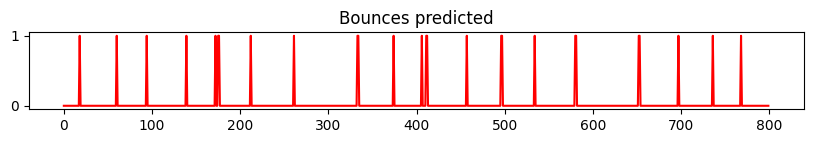

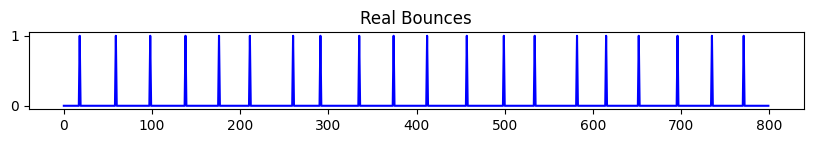

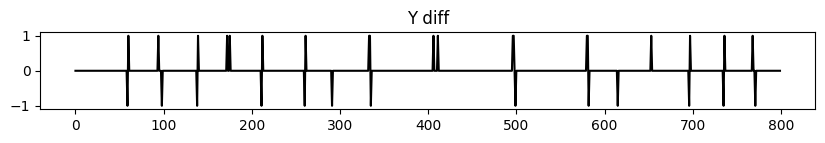

In [220]:
y_pred=display_pred_test(y_test_pred_proba,y_test,0.12)
df = pd.DataFrame(y_pred)
df.to_csv(r'/home/pguitteny/code/PhilippeGuitteny/final_tennis_exploration/RandomForestClassifier.csv', index=False, header=True)

XGBClassifier investigation

In [236]:
def confusion_matrix_params(y_test,weighted_prediction):
    acc=round(accuracy_score(y_test, weighted_prediction),2)
    rec=round(recall_score(y_test, weighted_prediction,average='weighted'),2)
    prec=round(precision_score(y_test, weighted_prediction,average='weighted'),3)
    F1=round(f1_score(y_test, weighted_prediction,average='weighted'),2)
            
    return   acc,rec,prec,F1

In [238]:
max_depths_val = [2, 5, 10, 20]
lr_vals = [0.04, 0.05, 0.06]
gamma_vals = [0.3, 0.5, 0.7]
global_list=[]


start_time = time.time()
    
    
for gamma in gamma_vals:
    for lr in lr_vals:
        for depths in max_depths_val:
            local_list={}
            model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', gamma=gamma, learning_rate=lr,\
                                        max_delta_step=0, max_depth=depths, \
                                        n_estimators=1000, n_jobs=1, verbosity=1) 
            my_roc_auc_score_pastonly_dict={}
            df_ball_lag = create_lag(df_ball,nb_lag=9,nb_steps=STEPS,past_only=PAST_ONLY)
            X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
            model_fitted = fit_model(model,X_train,y_train,X_test)
            y_test_pred_proba=model_fitted.predict_proba(X_test)[:,1]            

            score=round(roc_auc_score(y_test, y_test_pred_proba),2)
            my_roc_auc_score_pastonly_dict[i]=score

            print(f"With model XGBClassifier gamma {gamma} learning_rate {lr} max_depth {depths}, score is {score}")
            
            weighted_prediction = model_fitted.predict(X_test)
            #Store metric
            acc,rec,prec,F1=confusion_matrix_params(y_test,weighted_prediction)
            local_list['acc']=acc; local_list['rec']=rec; local_list['prec']=prec; local_list['F1']=F1

            #Store Params
            local_list['model']="XGBClassifier";local_list['gamma']=gamma;local_list['learning_rate']=lr;local_list['max_depth']=depths
            global_list.append(local_list)
            
            
            print("--- %s seconds ---" % round((time.time() - start_time),1))

With model XGBClassifier gamma 0.3 learning_rate 0.04 max_depth 2, score is 0.93
--- 4.5 seconds ---
With model XGBClassifier gamma 0.3 learning_rate 0.04 max_depth 5, score is 0.92
--- 12.6 seconds ---
With model XGBClassifier gamma 0.3 learning_rate 0.04 max_depth 10, score is 0.92
--- 21.1 seconds ---
With model XGBClassifier gamma 0.3 learning_rate 0.04 max_depth 20, score is 0.91
--- 28.9 seconds ---
With model XGBClassifier gamma 0.3 learning_rate 0.05 max_depth 2, score is 0.93
--- 33.0 seconds ---
With model XGBClassifier gamma 0.3 learning_rate 0.05 max_depth 5, score is 0.92
--- 39.6 seconds ---
With model XGBClassifier gamma 0.3 learning_rate 0.05 max_depth 10, score is 0.9
--- 48.9 seconds ---
With model XGBClassifier gamma 0.3 learning_rate 0.05 max_depth 20, score is 0.91
--- 57.8 seconds ---
With model XGBClassifier gamma 0.3 learning_rate 0.06 max_depth 2, score is 0.93
--- 62.2 seconds ---
With model XGBClassifier gamma 0.3 learning_rate 0.06 max_depth 5, score is 0.92

In [239]:
my_df=pd.DataFrame(global_list)
idx=my_df[['prec']].idxmax()
index=idx[0]

my_df
print(f"Best Precision is {my_df['prec'][index]} for model:{my_df['model'][index]}) &\
       gamma:{my_df['gamma'][index]} & learning_rate:{my_df['learning_rate'][index]} & \
       max_depth:{my_df['max_depth'][index]} \
       ")

Best Precision is 0.965 for model:XGBClassifier) &       gamma:0.3 & learning_rate:0.05 &        max_depth:2        


In [241]:
GAMMA=0.3
LR=0.05
DEPTH=2
model = xgb.XGBClassifier(base_score=0.5, booster='gbtree', gamma=GAMMA, learning_rate=LR,\
                                        max_delta_step=0, max_depth=DEPTH, \
                                        n_estimators=1000, n_jobs=1, verbosity=1) 

df_ball_lag = create_lag(df_ball,nb_lag=9,nb_steps=STEPS,past_only=PAST_ONLY)
X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
model_fitted = fit_model(model,X_train,y_train,X_test)
y_test_pred_proba=model_fitted.predict_proba(X_test)[:,1]
print("ROC SCORE",round(roc_auc_score(y_test, y_test_pred_proba),2))
y_pred = model_fitted.predict(X_test)
print(confusion_matrix(y_test, y_pred))

ROC SCORE 0.93
[[778   2]
 [ 18   2]]


#pred bounces 18
#true bounces 20


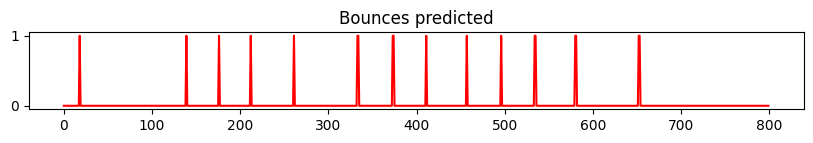

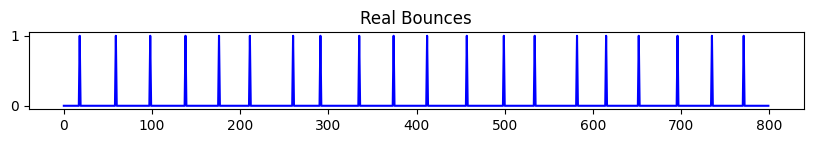

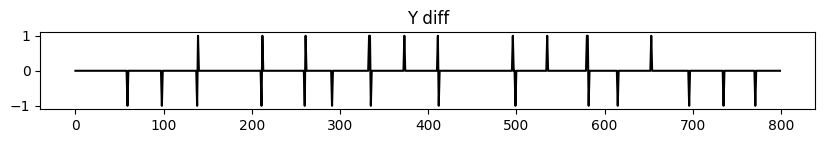

In [242]:
y_pred=display_pred_test(y_test_pred_proba,y_test,0.12)
df = pd.DataFrame(y_pred)
df.to_csv(r'/home/pguitteny/code/PhilippeGuitteny/final_tennis_exploration/XGBClassifier.csv', index=False, header=True)

### PLaying with SVC parameters 

In [249]:

#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’} or callable, default=’rbf’
kernel_models = ['linear', 'poly', 'rbf', 'sigmoid']

#C float, default=1.0 - Regularization parameter. The strength of the regularization is inversely proportional to C.
#Must be strictly positive. The penalty is a squared l2 penalty.
C_values = [2.0,3.0,4.0,5.0,6.0]

#degreeint, default=3, Degree of the polynomial kernel function (‘poly’). Ignored by all other kernels.
#poly_degree = [1,2,3,4,5] don't bring better result - removed

global_list=[]
my_results_df = pd.DataFrame()
verbose=1;
for kernel in kernel_models :
    for c_val in C_values : 
        start_time = time.time()
        local_list={}
        model = SVC(kernel=kernel, probability = False, random_state=1, C=c_val,class_weight={1: weight})

        df_ball_lag = create_lag(df_ball,nb_lag=9,nb_steps=STEPS,past_only=PAST_ONLY)
        X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
        model_fitted = fit_model(model,X_train,y_train,X_test)

        weighted_prediction = model_fitted.predict(X_test)
        #Store metric
        acc,rec,prec,F1=confusion_matrix_params(y_test,weighted_prediction)
        local_list['acc']=acc; local_list['rec']=rec; local_list['prec']=prec; local_list['F1']=F1

        if (verbose) :
            print(f"Accuracy:{acc},Recall:{rec}, Precision:{prec},F1:{F1}")
            print(f"confussion matrix:{kernel},C:{c_val},\n",confusion_matrix(y_test, weighted_prediction))
       
        #Store Params
        local_list['model']="SVC";local_list['kernel']=kernel;local_list['C']=c_val;

        global_list.append(local_list)
            
        print("--- %s seconds ---" % round((time.time() - start_time),1))

Accuracy:0.87,Recall:0.87, Precision:0.965,F1:0.91
confussion matrix:linear,C:2.0,
 [[687  93]
 [  9  11]]
--- 1.2 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.965,F1:0.91
confussion matrix:linear,C:3.0,
 [[687  93]
 [  9  11]]
--- 1.7 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.965,F1:0.91
confussion matrix:linear,C:4.0,
 [[687  93]
 [  9  11]]
--- 1.8 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.965,F1:0.91
confussion matrix:linear,C:5.0,
 [[687  93]
 [  9  11]]
--- 2.3 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.965,F1:0.91
confussion matrix:linear,C:6.0,
 [[687  93]
 [  9  11]]
--- 2.6 seconds ---
Accuracy:0.94,Recall:0.94, Precision:0.966,F1:0.95
confussion matrix:poly,C:2.0,
 [[742  38]
 [ 11   9]]
--- 0.4 seconds ---
Accuracy:0.94,Recall:0.94, Precision:0.967,F1:0.95
confussion matrix:poly,C:3.0,
 [[739  41]
 [ 10  10]]
--- 0.4 seconds ---
Accuracy:0.94,Recall:0.94, Precision:0.965,F1:0.95
confussion matrix:poly,C:4.0,
 [[740  40]
 [ 11   9]]
--- 0.3 se

In [250]:
my_df=pd.DataFrame(global_list)
idx=my_df[['prec']].idxmax()
index=idx[0]

print(f"Best Precision is {my_df['prec'][index]} for model:{my_df['model'][index]} & kernel:{my_df['kernel'][index]} & C:{my_df['C'][index]} ")

Best Precision is 0.973 for model:SVC & kernel:rbf & C:2.0 


In [264]:
kernel="rbf"
C=2.0

model = SVC(kernel=kernel, probability = False, random_state=1, C=C,class_weight={1: weight})

df_ball_lag = create_lag(df_ball,nb_lag=9,nb_steps=STEPS,past_only=PAST_ONLY)
X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
model_fitted = fit_model(model,X_train,y_train,X_test)

y_pred = model_fitted.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[687  93]
 [  4  16]]


#pred bounces 19
#true bounces 20


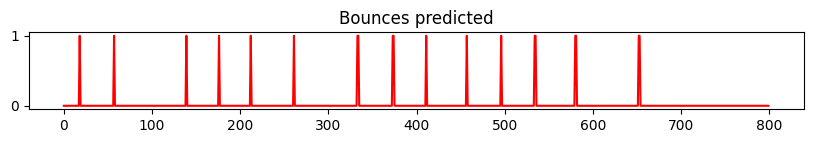

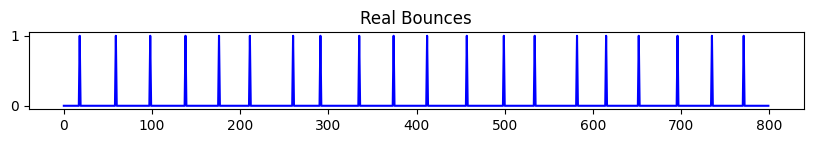

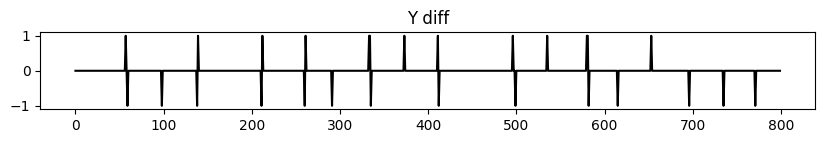

In [256]:
y_pred=display_pred_test(y_test_pred_proba,y_test,0.10)
df = pd.DataFrame(y_pred)
df.to_csv(r'/home/pguitteny/code/PhilippeGuitteny/final_tennis_exploration/SVC.csv', index=False, header=True)

In [ ]:
### PLaying with SGDClassifier parameters 

In [260]:
verbose=1

##SGDClassifier(loss='hinge', *, penalty='l2', alpha=0.0001, l1_ratio=0.15, fit_intercept=True, 
#max_iter=1000, tol=0.001, shuffle=True, verbose=0, epsilon=0.1, n_jobs=None, random_state=None, 
#learning_rate='optimal', eta0=0.0, power_t=0.5, early_stopping=False, validation_fraction=0.1, 
#n_iter_no_change=5, class_weight=None, warm_start=False, average=False)


loss_val=['hinge', 'log_loss', 'log', 'modified_huber', 'squared_hinge', 'perceptron', 'squared_error', \
     'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive']
penalty_val=['l2', 'l1', 'elasticnet']
alpha_val=[0.0001, 0.001, 0.01]
n_iters_val = [5, 10, 20, 50, 100, 1000]
l1_ratio_val = [0.05, 0.15, 0.30, 0.5]
epsilon_val =  [0.0, 0.1, 0.2, 0.3] 

#alphafloat, default=0.0001
#Constant that multiplies the regularization term. The higher the value, the stronger the regularization. Also used to compute the learning rate when set to learning_rate is set to ‘optimal’. Values must be in the range [0.0, inf).

global_list=[]
for loss in loss_val :
    for penalty in penalty_val :
        for alpha in alpha_val :
            for nb_iter in n_iters_val :
                for l1_ratio in l1_ratio_val :
                    for epsilon in epsilon_val :
                        start_time = time.time()

                        local_list={}
                        model = SGDClassifier(loss=loss,penalty=penalty,l1_ratio=l1_ratio,epsilon=epsilon, max_iter=nb_iter,alpha=alpha,class_weight={1: weight})

                        df_ball_lag = create_lag(df_ball,nb_lag=9,nb_steps=STEPS,past_only=PAST_ONLY)
                        X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
                        model_fitted = fit_model(model,X_train,y_train,X_test)

                        weighted_prediction = model_fitted.predict(X_test)
                        #Store metric
                        acc,rec,prec,F1=confusion_matrix_params(y_test,weighted_prediction)
                        local_list['acc']=acc; local_list['rec']=rec; local_list['prec']=prec; local_list['F1']=F1
                      
                        if (verbose) :
                            print(f"Accuracy:{acc},Recall:{rec}, Precision:{prec},F1:{F1}")
                        local_list['model']="SGDClassifier";local_list['loss']=loss;local_list['penalty']=penalty;
                        local_list['alpha']=alpha;local_list['nb_iter']=nb_iter;
                        local_list['l1_ratio']=l1_ratio;local_list['epsilon']=epsilon;
                        global_list.append(local_list)
            
                        print("--- %s seconds ---" % round((time.time() - start_time),1))

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.964,F1:0.66
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.973,F1:0.57
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.974,F1:0.68
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.957,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.955,F1:0.67
--- 0.0 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.66
--- 0.0 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.976,F1:0.62
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.97,F1:0.83
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.967,F1:0.89
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.959,F1:0.71
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.71
--- 0.0 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.71
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.963,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.962,F1:0.88
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.956,F1:0.88
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.966,F1:0.87
--- 0.0 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.8,Recall:0.8, Precision:0.968,F1:0.87
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.961,F1:0.86
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.955,F1:0.73
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.96,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.72
--- 0.0 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.945,F1:0.81
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.969,F1:0.65
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.966,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.79,Recall:0.79, Precision:0.966,F1:0.86
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.963,F1:0.72
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.969,F1:0.87
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.963,F1:0.87
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.972,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.952,F1:0.61
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.956,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.963,F1:0.78
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.959,F1:0.73
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.955,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.86,Recall:0.86, Precision:0.957,F1:0.91
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.968,F1:0.72
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.968,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.86,Recall:0.86, Precision:0.962,F1:0.9
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.966,F1:0.75
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.973,F1:0.61
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.959,F1:0.91
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.973,F1:0.87
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.66
--- 0.0 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.959,F1:0.88
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.954,F1:0.81
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.962,F1:0.66
--- 0.0 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.964,F1:0.89
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.973,F1:0.63
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.79,Recall:0.79, Precision:0.969,F1:0.86
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.82
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.0 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.974,F1:0.73
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.976,F1:0.64
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.947,F1:0.78
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.63
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.973,F1:0.58
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.958,F1:0.78
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.955,F1:0.89
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.966,F1:0.9
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.971,F1:0.43
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.56,R

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.954,F1:0.78
--- 0.0 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.952,F1:0.74
--- 0.0 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.97,F1:0.7
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.968,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.36,Recall:0.36, Precision:0.958,F1:0.5
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.968,F1:0.63
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.964,F1:0.86
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.87,Recall:0.87, Precision:0.965,F1:0.91
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.96,F1:0.86
--- 0.0 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.959,F1:0.77
--- 0.0 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.956,F1:0.88
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.955,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.3,Recall:0.3, Precision:0.976,F1:0.43
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.964,F1:0.9
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.961,F1:0.64
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.963,F1:0.79
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.56,Recall:0.56, Precision:0.961,F1:0.7
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.944,F1:0.57
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.95,F1:0.62
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.73
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.79
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.962,F1:0.6
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.964,F1:0.82
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.962,F1:0.85
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.957,F1:0.73
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.0 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.969,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.78,Recall:0.78, Precision:0.967,F1:0.86
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.973,F1:0.91
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.976,F1:0.59
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.97,F1:0.81
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.961,F1:0.7
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.968,F1:0.82
--- 0.0 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.971,F1:0.87
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.65
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.973,F1:0.81
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.96,F1:0.93
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.962,F1:0.75
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.961,F1:0.89
--- 0.1 seconds ---
Accuracy:0.84,R

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.75,Recall:0.75, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.964,F1:0.73
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.8
--- 0.0 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.963,F1:0.91
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.974,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.96,F1:0.88
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.957,F1:0.9
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.959,F1:0.86
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.966,F1:0.73
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.962,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.77,Recall:0.77, Precision:0.954,F1:0.85
--- 0.1 seconds ---
Accuracy:0.93,Recall:0.93, Precision:0.958,F1:0.94
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.975,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.75,Recall:0.75, Precision:0.963,F1:0.84
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.79
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.966,F1:0.93
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.963,F1:0.93
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.971,F1:0.65
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.963,F1:0.89
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.974,F1:0.82
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.955,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.76,Recall:0.76, Precision:0.964,F1:0.84
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.975,F1:0.8
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.962,F1:0.74
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.963,F1:0.9
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.971,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.972,F1:0.89
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.954,F1:0.94
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.975,F1:0.8
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.964,F1:0.92
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.81,Recall:0.81, Precision:0.97,F1:0.88
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.96,F1:0.87
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.961,F1:0.9
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.962,F1:0.85
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.954,F1:0.91
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.959,F1:0.86
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.967,F1:0.89
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.973,F1:0.89
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.97,F1:0.92
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.971,F1:0.86
--- 0.0 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.961,F1:0.85
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.955,F1:0.76
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.973,F1:0.92
--- 0.1 seconds ---
Accuracy:0.8

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.969,F1:0.69
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.973,F1:0.62
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.961,F1:0.83
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.966,F1:0.75
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.968,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.961,F1:0.71
--- 0.0 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.962,F1:0.81
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.972,F1:0.73
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.965,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.71
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.963,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.964,F1:0.73
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.97,F1:0.81
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.967,F1:0.6
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.963,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.955,F1:0.79
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.971,F1:0.78
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.968,F1:0.74
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.955,F1:0.86
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.75,Recall:0.75, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.957,F1:0.85
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.968,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.77
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.963,F1:0.7
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.969,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.965,F1:0.82
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.32,Recall:0.32, Precision:0.972,F1:0.45
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.79,Recall:0.79, Precision:0.966,F1:0.86
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.74
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.97,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.964,F1:0.67
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.952,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.96,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.953,F1:0.8
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.974,F1:0.74
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.961,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.44,Recall:0.44, Precision:0.967,F1:0.59
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.969,F1:0.69
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.959,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.82,Recall:0.82, Precision:0.96,F1:0.88
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.968,F1:0.86
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.965,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.977,F1:0.75
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.962,F1:0.68
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.963,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.97,F1:0.8
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.949,F1:0.69
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.967,F1:0.79
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.976,F1:0.56
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.971,F1:0.67
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.971,F1:0.78
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.76
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.97,F1:0.7
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.967,F1:0.84
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.96,F1:0.78
--- 0.1 seconds ---
Accuracy:0.76,Re

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.69,Recall:0.69, Precision:0.96,F1:0.8
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.0 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.955,F1:0.88
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.958,F1:0.75
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.96,F1:0.78
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.963,F1:0.78
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.957,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.962,F1:0.81
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.967,F1:0.68
--- 0.0 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.79
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.97,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.97,F1:0.75
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.968,F1:0.72
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.96,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.958,F1:0.78
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.968,F1:0.73
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.971,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.72,Recall:0.72, Precision:0.97,F1:0.81
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.958,F1:0.78
--- 0.0 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.969,F1:0.84
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.968,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.973,F1:0.77
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.969,F1:0.86
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.963,F1:0.78
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.971,F1:0.79
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.97,F1:0.75
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.967,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.78
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.967,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.971,F1:0.78
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.967,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.974,F1:0.68
--- 0.2 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.975,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.973,F1:0.79
--- 0.2 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.96,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.75,Recall:0.75, Precision:0.965,F1:0.84
--- 0.2 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.965,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.968,F1:0.81
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.974,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.63,Recall:0.63, Precision:0.956,F1:0.75
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.958,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.96,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.968,F1:0.87
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.971,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.958,F1:0.79
--- 0.2 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.961,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.967,F1:0.79
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.96,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.963,F1:0.78
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.965,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.79,Recall:0.79, Precision:0.971,F1:0.86
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.968,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.975,F1:0.81
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.968,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.965,F1:0.84
--- 0.5 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.971,F1:0.87
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.971,F1:0.85
--- 0.2 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.72
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.2 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.964,F1:0.89
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.97,F1:0.89
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.97,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.964,F1:0.82
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.963,F1:0.78
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.5 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.955,F1:0.76
--- 0.4 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.975,F1:0.79
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.965,F1:0.68
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.967,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.74,Recall:0.74, Precision:0.961,F1:0.83
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.962,F1:0.74
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.975,F1:0.81
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.977,F1:0.77
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.72,Recall:0.72, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.76
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.97,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.966,F1:0.73
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.82
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.973,F1:0.77
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.959,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.57,Recall:0.57, Precision:0.963,F1:0.7
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.966,F1:0.74
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.97,F1:0.83
--- 0.0 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.973,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.957,F1:0.66
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.966,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.977,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.79,Recall:0.79, Precision:0.969,F1:0.86
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.961,F1:0.71
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.963,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.62,Recall:0.62, Precision:0.968,F1:0.74
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.97,F1:0.92
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.974,F1:0.66
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.974,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.41,Recall:0.41, Precision:0.943,F1:0.56
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.97,F1:0.75
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.963,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.969,F1:0.76
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.966,F1:0.75
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.953,F1:0.77
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.966,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.955,F1:0.81
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.969,F1:0.91
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.962,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.78,Recall:0.78, Precision:0.961,F1:0.86
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.964,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.962,F1:0.79
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.962,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.964,F1:0.74
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.96,F1:0.88
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.966,F1:0.9
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.964,F1:0.87
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.966,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.961,F1:0.71
--- 0.2 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.963,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.2 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.957,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.2 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.967,F1:0.79
--- 0.2 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.959,F1:0.91
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.969,F1:0.91
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.961,F1:0.87
--- 0.2 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.964,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.963,F1:0.81
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.962,F1:0.84
--- 0.2 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.962,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.972,F1:0.82
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.965,F1:0.77
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.973,F1:0.79
--- 0.5 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.953,F1:0.76
--- 0.3 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.964,F1:0.86
--- 0.2 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.97,F1:0.88
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.97,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.963,F1:0.78
--- 0.5 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.965,F1:0.92
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.5 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.96,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.968,F1:0.81
--- 0.5 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.961,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.971,F1:0.78
--- 0.5 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.956,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.7,Recall:0.7, Precision:0.969,F1:0.8
--- 0.5 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.959,F1:0.58
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.964,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.976,F1:0.66
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.973,F1:0.62
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.971,F1:0.81
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.968,F1:0.46
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.946,F1:0.71
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.961,F1:0.78
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.957,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.39,Recall:0.39, Precision:0.966,F1:0.54
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.965,F1:0.91
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.961,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.51, Precision:0.959,F1:0.66
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.54, Precision:0.958,F1:0.68
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.949,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.65,Recall:0.65, Precision:0.967,F1:0.76
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.971,F1:0.67
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.67
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.958,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.967,F1:0.85
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.956,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.965,F1:0.88
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.952,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.961,F1:0.66
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.965,F1:0.61
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.961,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.39,Recall:0.39, Precision:0.956,F1:0.53
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.965,F1:0.68
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.968,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.948,F1:0.7
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.69
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.963,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.82,Recall:0.82, Precision:0.952,F1:0.88
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.63, Precision:0.959,F1:0.76
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.968,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.949,F1:0.71
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.967,F1:0.67
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.968,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.966,F1:0.65
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.972,F1:0.48
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.67
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.964,F1:0.75
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.966,F1:0.86
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.969,F1:0.86
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.954,F1:0.65
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accurac

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.37,Recall:0.37, Precision:0.962,F1:0.51
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.953,F1:0.94
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.973,F1:0.77
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.7
--- 0.0 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.967,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.74,Recall:0.74, Precision:0.968,F1:0.83
--- 0.0 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.945,F1:0.63
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.958,F1:0.69
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.962,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.974,F1:0.66
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.959,F1:0.67
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.958,F1:0.69
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.964,F1:0.74
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.961,F1:0.7
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.961,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.63,Recall:0.63, Precision:0.961,F1:0.75
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.969,F1:0.65
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.957,F1:0.81
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.969,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.973,F1:0.75
--- 0.1 seconds ---
Accuracy:0.91,Recall:0.91, Precision:0.955,F1:0.93
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.968,F1:0.86
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.959,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.88,Recall:0.88, Precision:0.962,F1:0.91
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.966,F1:0.65
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.972,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.949,F1:0.81
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.961,F1:0.86
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.96,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.965,F1:0.84
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.969,F1:0.51
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.965,F1:0.62
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.955,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.39,Recall:0.39, Precision:0.95,F1:0.54
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.967,F1:0.7
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.974,F1:0.69
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.94,Recall:0.94, Precision:0.952,F1:0.95
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.972,F1:0.81
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.966,F1:0.76
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.963,F1:0.63
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.66
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.973,F1:0.88
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.976,F1:0.72
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.957,F1:0.73
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.974,F1:0.71
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.976,F1:0.58
--- 0.1 seconds ---
Accuracy:0.29,Recall:0.29, Precision:0.971,F1:0.41
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.97,F1:0.81
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.976,F1:0.54
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.974,F1:0.83
--- 0.1 seconds ---
Accuracy:0

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.69,Recall:0.69, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.963,F1:0.9
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.964,F1:0.67
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.91,Recall:0.91, Precision:0.952,F1:0.93
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.84,Recall:0.84, Precision:0.955,F1:0.89
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.966,F1:0.86
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.956,F1:0.77
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.7,Recall:0.7, Precision:0.953,F1:0.8
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.973,F1:0.57
--- 0.0 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.953,F1:0.92
--- 0.0 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.968,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.967,F1:0.68
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.962,F1:0.74
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.955,F1:0.92
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.973,F1:0.56
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.9,Recall:0.9, Precision:0.96,F1:0.93
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.969,F1:0.79
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.96,F1:0.93
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.83,Recall:0.83, Precision:0.964,F1:0.89
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.963,F1:0.81
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.966,F1:0.89
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.964,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.971,F1:0.77
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.956,F1:0.73
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.966,F1:0.89
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.78
--- 0.1 seconds ---
Accuracy:0.91,Recall:0.91, Precision:0.962,F1:0.93
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.976,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.86,Recall:0.86, Precision:0.961,F1:0.9
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.95,F1:0.9
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.958,F1:0.9
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.96,F1:0.9
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.97,F1:0.88
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.974,F1:0.82
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.961,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.962,F1:0.78
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.74
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.971,F1:0.9
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.965,F1:0.92
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.964,F1:0.86
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.96,F1:0.93
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.965,F1:0.91
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.967,F1:0.91
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.97,F1:0.88
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.962,F1:0.91
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.962,F1:0.85
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.964,F1:0.86
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.968,F1:0.88
--- 0.1 seconds ---
Accuracy:0.79

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.4,Recall:0.4, Precision:0.94,F1:0.56
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.961,F1:0.82
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.975,F1:0.78
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.961,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.61,Recall:0.61, Precision:0.97,F1:0.74
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.949,F1:0.82
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.954,F1:0.93
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.975,F1:0.78
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.94,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.36,Recall:0.36, Precision:0.951,F1:0.5
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.972,F1:0.73
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.956,F1:0.88
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.971,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.65,Recall:0.65, Precision:0.973,F1:0.77
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.961,F1:0.86
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.962,F1:0.8
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.976,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.948,F1:0.67
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.97,F1:0.84
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.954,F1:0.82
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.952,F1:0.61
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.959,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.81,Recall:0.81, Precision:0.962,F1:0.88
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.963,F1:0.64
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.95,F1:0.77
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.975,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.78,Recall:0.78, Precision:0.95,F1:0.86
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.958,F1:0.73
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.956,F1:0.59
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.32,Recall:0.32, Precision:0.96,F1:0.46
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.972,F1:0.84
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.955,F1:0.75
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.953,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.961,F1:0.66
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.97,F1:0.84
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.968,F1:0.74
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.975,F1:0.75
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.961,F1:0.86
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.24,Recall:0.24, Precision:0.976,F1:0.35
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.973,F1:0.6
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.958,F1:0.68
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.95,F1:0.78
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.968,F1:0.61
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.961,F1:0.58
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.79
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.958,F1:0.84
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.963,F1:0.63
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.956,F1:0.54
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.73,Recall:0.73, Precision:0.974,F1:0.82
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.12,Recall:0.12, Precision:0.942,F1:0.19
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.67,Recall:0.67, Precision:0.96,F1:0.78
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.942,F1:0.69
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.946,F1:0.74
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.969,F1:0.68
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.971,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.94,F1:0.75
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.97,F1:0.83
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.951,F1:0.72
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.961,F1:0.83
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.973,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.955,F1:0.93
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.972,F1:0.7
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.97,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.81,Recall:0.81, Precision:0.965,F1:0.87
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.964,F1:0.73
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.7
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.952,F1:0.56
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.972,F1:0.83
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.972,F1:0.83
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.961,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.957,F1:0.61
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.958,F1:0.68
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.969,F1:0.85
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.966,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.957,F1:0.9
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.963,F1:0.71
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.959,F1:0.88
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.969,F1:0.65
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.954,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.969,F1:0.77
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.968,F1:0.61
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.72
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.968,F1:0.8
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.96,F1:0.67
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.965,F1:0.85
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.967,F1:0.84
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.972,F1:0.82
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.8
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.971,F1:0.64
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.949,F1:0.72
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.966,F1:0.9
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.965,F1:0.6
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.959,F1:0.67
--- 0.1 seconds ---
Accuracy:0.56

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.97,F1:0.74
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.961,F1:0.66
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.62
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.967,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.82,Recall:0.82, Precision:0.957,F1:0.88
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.967,F1:0.68
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.972,F1:0.82
--- 0.1 seconds ---
Accuracy:0.22,Recall:0.22, Precision:0.963,F1:0.33
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.959,F1:0.61
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.97,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.969,F1:0.68
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.949,F1:0.72
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.965,F1:0.6
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.971,F1:0.77
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.961,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.962,F1:0.79
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.956,F1:0.9
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.96,F1:0.78
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.97,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.958,F1:0.93
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.962,F1:0.74
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.972,F1:0.85
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.962,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.973,F1:0.87
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.969,F1:0.85
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.965,F1:0.76
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.955,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.955,F1:0.75
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.954,F1:0.73
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.956,F1:0.91
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.961,F1:0.89
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.967,F1:0.89
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.962,F1:0.88
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.955,F1:0.76
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.959,F1:0.81
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.77
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.958,F1:0.74
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.964,F1:0.74
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.967,F1:0.84
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.962,F1:0.91
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.88,Recall:0.88, Precision:0.962,F1:0.91
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.972,F1:0.81
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.96,F1:0.87
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.973,F1:0.87
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.963,F1:0.9
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.74
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.967,F1:0.91
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.96,F1:0.93
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.964,F1:0.92
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.964,F1:0.89
--- 0.1 seconds ---
Accuracy:0.77,R

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.65,Recall:0.65, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.957,F1:0.81
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.963,F1:0.63
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.963,F1:0.69
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.949,F1:0.69
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.963,F1:0.83
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.97,F1:0.74
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.957,F1:0.81
--- 0.0 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.957,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.61,Recall:0.61, Precision:0.968,F1:0.74
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.957,F1:0.84
--- 0.0 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.973,F1:0.59
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.79,Recall:0.79, Precision:0.956,F1:0.86
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.973,F1:0.77
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.97,F1:0.71
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.64,Recall:0.64, Precision:0.973,F1:0.76
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.975,F1:0.79
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.967,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.78,Recall:0.78, Precision:0.967,F1:0.85
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.963,F1:0.82
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.969,F1:0.79
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.974,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.69,Recall:0.69, Precision:0.967,F1:0.79
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.969,F1:0.86
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.975,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.971,F1:0.76
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.951,F1:0.75
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.21,Recall:0.21, Precision:0.957,F1:0.32
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.964,F1:0.81
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.972,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.75,Recall:0.75, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.975,F1:0.78
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.964,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.969,F1:0.84
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.973,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.955,F1:0.57
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.958,F1:0.69
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.975,F1:0.8
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.965,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.954,F1:0.81
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.975,F1:0.77
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.969,F1:0.65
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.968,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.964,F1:0.67
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.971,F1:0.65
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.962,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.71
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.63,Recall:0.63, Precision:0.959,F1:0.75
--- 0.2 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.955,F1:0.62
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.976,F1:0.5
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.95,F1:0.77
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.961,F1:0.72
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.953,F1:0.8
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.967,F1:0.88
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.971,F1:0.63
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.968,F1:0.73
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.74
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.967,F1:0.67
--- 0.2 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.97,F1:0.84
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.2 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.54, Precision:0.953,F1:0.68
--- 0.2 seconds ---
Accuracy:0.91,Recall:0.91, Precision:0.952,F1:0.93
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.959,F1:0.67
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.951,F1:0.85
--- 0.2 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.963,F1:0.71
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.964,F1:0.88
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.956,F1:0.89
--- 0.2 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.962,F1:0.74
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.957,F1:0.82
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.965,F1:0.87
--- 0.1 seconds ---
Accuracy:0.

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.62,Recall:0.62, Precision:0.968,F1:0.75
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.97,F1:0.74
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.78
--- 0.0 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.966,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.968,F1:0.73
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.971,F1:0.76
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.974,F1:0.82
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.964,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.96,F1:0.75
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.967,F1:0.71
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.957,F1:0.8
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.952,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.76,Recall:0.76, Precision:0.97,F1:0.84
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.69
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.951,F1:0.72
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.961,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.959,F1:0.81
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.958,F1:0.73
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.958,F1:0.75
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.96,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.81,Recall:0.81, Precision:0.957,F1:0.87
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.954,F1:0.77
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.975,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.967,F1:0.76
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.958,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.954,F1:0.78
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.972,F1:0.81
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.963,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.955,F1:0.79
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.965,F1:0.82
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.97,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.72,Recall:0.72, Precision:0.964,F1:0.82
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.8
--- 0.2 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.962,F1:0.73
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.87,Recall:0.87, Precision:0.96,F1:0.91
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.963,F1:0.78
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.971,F1:0.85
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.965,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.63,Recall:0.63, Precision:0.957,F1:0.75
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.972,F1:0.82
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.967,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.957,F1:0.91
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.961,F1:0.78
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.962,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.967,F1:0.79
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.97,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.968,F1:0.81
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.973,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.959,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.974,F1:0.84
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.976,F1:0.73
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.964,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.954,F1:0.74
--- 0.2 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.969,F1:0.78
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.2 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.971,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.2 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.962,F1:0.88
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.963,F1:0.77
--- 0.2 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.79
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.79,Recall:0.79, Precision:0.968,F1:0.86
--- 0.2 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.972,F1:0.81
--- 0.2 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.958,F1:0.78
--- 0.2 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.965,F1:0.87
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.965,F1:0.82
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.961,F1:0.77
--- 0.3 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.958,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.957,F1:0.8
--- 0.7 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.954,F1:0.78
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.963,F1:0.76
--- 0.6 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.969,F1:0.87
--- 0.2 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.963,F1:0.82
--- 0.2 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.966,F1:0.85
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.969,F1:0.8
--- 0.4 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.75
--- 0.2 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.972,F1:0.85
--- 0.3 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.82
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.3 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.84
--- 0.2 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.97,F1:0.88
--- 0.2 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.968,F1:0.86
--- 0.3 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.967,F1:0.79
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.0 seconds ---
Accuracy:0.57,Re

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.65
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.968,F1:0.82
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.972,F1:0.69
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.956,F1:0.75
--- 0.0 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.81
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.974,F1:0.75
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.973,F1:0.82
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.963,F1:0.87
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.952,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.962,F1:0.75
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.96,F1:0.88
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.957,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.71
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.96,F1:0.8
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.968,F1:0.86
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.942,F1:0.51
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.65,Recall:0.65, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.952,F1:0.84
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.96,F1:0.73
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.72,Recall:0.72, Precision:0.963,F1:0.81
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.961,F1:0.85
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.81,Recall:0.81, Precision:0.965,F1:0.87
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.96,F1:0.86
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.965,F1:0.89
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.977,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.962,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.76,Recall:0.76, Precision:0.969,F1:0.84
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.79
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.961,F1:0.82
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.962,F1:0.81
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.972,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.958,F1:0.84
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.959,F1:0.82
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.953,F1:0.8
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.957,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.964,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.78,Recall:0.78, Precision:0.962,F1:0.86
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.962,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.77
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.969,F1:0.84
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.96,F1:0.88
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.2 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.96,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.82,Recall:0.82, Precision:0.962,F1:0.88
--- 0.2 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.953,F1:0.8
--- 0.2 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.963,F1:0.71
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.63,Recall:0.63, Precision:0.96,F1:0.75
--- 0.2 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.961,F1:0.86
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.958,F1:0.64
--- 0.2 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.78
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.78
--- 0.2 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.96,F1:0.9
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.965,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.952,F1:0.82
--- 0.2 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.961,F1:0.86
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.964,F1:0.86
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.964,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.964,F1:0.74
--- 0.6 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.961,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.63,Recall:0.63, Precision:0.966,F1:0.75
--- 0.7 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.962,F1:0.94
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.962,F1:0.78
--- 0.7 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.962,F1:0.74
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.957,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.962,F1:0.73
--- 0.6 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.962,F1:0.85
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.969,F1:0.76
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.961,F1:0.78
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.976,F1:0.66
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.968,F1:0.73
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.965,F1:0.69
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.958,F1:0.68
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.953,F1:0.64
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.39,Recall:0.39, Precision:0.96,F1:0.54
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.954,F1:0.81
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.976,F1:0.72
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.954,F1:0.81
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.946,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.959,F1:0.86
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.959,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.76,Recall:0.76, Precision:0.955,F1:0.85
--- 0.1 seconds ---
Accuracy:0.93,Recall:0.93, Precision:0.958,F1:0.94
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.963,F1:0.64
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.961,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.966,F1:0.53
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.961,F1:0.88
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.964,F1:0.81
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.952,F1:0.62
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.958,F1:0.73
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.968,F1:0.61
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.955,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.84,Recall:0.84, Precision:0.949,F1:0.89
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.968,F1:0.83
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.962,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.67
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.971,F1:0.66
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.965,F1:0.61
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.976,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.971,F1:0.41
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.953,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.92,Recall:0.92, Precision:0.951,F1:0.94
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.58, Precision:0.952,F1:0.71
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.97,F1:0.73
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.966,F1:0.74
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.96,F1:0.61
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.97,F1:0.72
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.962,F1:0.68
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.975,F1:0.82
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.956,F1:0.86
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.964,F1:0.58
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.955,F1:0.84
--- 0.1 seconds ---
Accuracy:0.

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.957,F1:0.8
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.956,F1:0.91
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.49,Recall:0.49, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.955,F1:0.91
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.972,F1:0.69
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.971,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.38,Recall:0.38, Precision:0.969,F1:0.52
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.956,F1:0.92
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.969,F1:0.69
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.962,F1:0.88
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.955,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.77,Recall:0.77, Precision:0.971,F1:0.85
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.96,F1:0.79
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.972,F1:0.89
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.972,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.963,F1:0.7
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.972,F1:0.85
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.974,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.955,F1:0.66
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.972,F1:0.73
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.947,F1:0.76
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.961,F1:0.72
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.62
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.973,F1:0.57
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.976,F1:0.7
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.957,F1:0.75
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.954,F1:0.73
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.954,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.4,Recall:0.4, Precision:0.948,F1:0.55
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.949,F1:0.52
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.69,Recall:0.69, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.957,F1:0.85
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.95,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.962,F1:0.89
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.954,F1:0.94
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.958,F1:0.69
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.976,F1:0.71
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.949,F1:0.9
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.75
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.97,F1:0.83
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.969,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.97,F1:0.71
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.972,F1:0.82
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.81
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.962,F1:0.67
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.954,F1:0.88
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.964,F1:0.86
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.974,F1:0.66
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.964,F1:0.9
--- 0.1 seconds ---
Accuracy:0.66,

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.67,Recall:0.67, Precision:0.965,F1:0.78
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.957,F1:0.8
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.0 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.976,F1:0.48
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.959,F1:0.86
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.968,F1:0.61
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.963,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.957,F1:0.73
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.961,F1:0.63
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.79
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.93,Recall:0.93, Precision:0.958,F1:0.94
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.71,Recall:0.71, Precision:0.963,F1:0.81
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.962,F1:0.85
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.71
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.958,F1:0.78
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.953,F1:0.88
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.953,F1:0.79
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.97,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.53,Recall:0.53, Precision:0.976,F1:0.67
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.955,F1:0.87
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.969,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.71
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.963,F1:0.9
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.972,F1:0.84
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.965,F1:0.91
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.964,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.964,F1:0.75
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.79,Recall:0.79, Precision:0.971,F1:0.86
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.961,F1:0.9
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.959,F1:0.89
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.965,F1:0.84
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.965,F1:0.89
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.967,F1:0.88
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.963,F1:0.92
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.958,F1:0.87
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.968,F1:0.91
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.964,F1:0.85
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.974,F1:0.85
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.965,F1:0.88
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.959,F1:0.92
--- 0.1 seconds ---
Accuracy:

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.58,Recall:0.58, Precision:0.965,F1:0.71
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.971,F1:0.79
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.0 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.971,F1:0.76
--- 0.0 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.74
--- 0.0 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.944,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.59,Recall:0.59, Precision:0.974,F1:0.72
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.62
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.949,F1:0.68
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.66,Recall:0.66, Precision:0.973,F1:0.78
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.965,F1:0.69
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.965,F1:0.76
--- 0.0 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.965,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.961,F1:0.56
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.953,F1:0.64
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.972,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.61,Recall:0.61, Precision:0.972,F1:0.73
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.954,F1:0.61
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.968,F1:0.8
--- 0.0 seconds ---
Accuracy:0.15,Recall:0.15, Precision:0.966,F1:0.22
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.964,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.955,F1:0.57
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.957,F1:0.85
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.962,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.36,Recall:0.36, Precision:0.972,F1:0.51
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.977,F1:0.73
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.949,F1:0.56
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.5,Recall:0.5, Precision:0.964,F1:0.65
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.955,F1:0.75
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.976,F1:0.52
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.83,Recall:0.83, Precision:0.961,F1:0.89
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.969,F1:0.84
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.964,F1:0.57
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.958,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.955,F1:0.73
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.961,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.4,Recall:0.4, Precision:0.954,F1:0.55
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.944,F1:0.61
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.967,F1:0.85
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.51, Precision:0.952,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.58,Recall:0.58, Precision:0.965,F1:0.71
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.96,F1:0.63
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.79
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.969,F1:0.68
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.969,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.76,Recall:0.76, Precision:0.969,F1:0.84
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.95,F1:0.74
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.971,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.43,Recall:0.43, Precision:0.973,F1:0.58
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.63
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.961,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.64,Recall:0.63, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.25,Recall:0.25, Precision:0.96,F1:0.37
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.956,F1:0.58
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.952,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.55,Recall:0.55, Precision:0.962,F1:0.69
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.966,F1:0.54
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.955,F1:0.88
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.971,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.58,Recall:0.59, Precision:0.968,F1:0.72
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.959,F1:0.76
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.957,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.975,F1:0.81
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.953,F1:0.92
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.968,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.97,F1:0.73
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.957,F1:0.68
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.974,F1:0.83
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.963,F1:0.55
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.973,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.44,Recall:0.44, Precision:0.965,F1:0.59
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.973,F1:0.77
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.966,F1:0.92
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.976,F1:0.55
--- 0.0 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.961,F1:0.83
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.65,Recall:0.65, Precision:0.957,F1:0.77
--- 0.0 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.973,F1:0.63
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.956,F1:0.53
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.57,Recall:0.57, Precision:0.958,F1:0.7
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.964,F1:0.85
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.97,F1:0.58
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.953,F1:0.59
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.954,F1:0.88
--- 0.0 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.947,F1:0.58
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.77,Recall:0.77, Precision:0.974,F1:0.85
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.951,F1:0.88
--- 0.0 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.956,F1:0.78
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.967,F1:0.71
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.67
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.964,F1:0.74
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.957,F1:0.66
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.958,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.55,Recall:0.55, Precision:0.962,F1:0.69
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.972,F1:0.75
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.938,F1:0.73
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.944,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.78,Recall:0.78, Precision:0.969,F1:0.86
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.973,F1:0.82
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.958,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.49,Recall:0.49, Precision:0.951,F1:0.64
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.974,F1:0.65
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.965,F1:0.61
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.966,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.74,Recall:0.74, Precision:0.961,F1:0.83
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.974,F1:0.71
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.967,F1:0.85
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.97,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.45,Recall:0.45, Precision:0.967,F1:0.6
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.969,F1:0.68
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.97,F1:0.73
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.962,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.81,Recall:0.81, Precision:0.97,F1:0.88
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.965,F1:0.69
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.97,F1:0.88
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.968,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.971,F1:0.66
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.963,F1:0.87
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.961,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.963,F1:0.82
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.951,F1:0.91
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.963,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.66
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.97,F1:0.74
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.973,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.73,Recall:0.73, Precision:0.968,F1:0.82
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.954,F1:0.78
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.61,Recall:0.61, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.968,F1:0.63
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.962,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.972,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.972,F1:0.69
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.966,F1:0.74
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.963,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.56,Recall:0.56, Precision:0.95,F1:0.7
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.974,F1:0.72
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.951,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.8,Recall:0.8, Precision:0.956,F1:0.87
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.97,F1:0.58
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.957,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.62,Recall:0.62, Precision:0.966,F1:0.74
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.964,F1:0.75
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.971,F1:0.65
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.971,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.974,F1:0.86
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.77
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.969,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.95,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.969,F1:0.67
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.97,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.73,Recall:0.73, Precision:0.975,F1:0.82
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.964,F1:0.86
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.95,F1:0.7
--- 0.0 seconds ---
Accuracy:0.91,Recall:0.91, Precision:0.951,F1:0.93
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.72,Recall:0.72, Precision:0.968,F1:0.81
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.958,F1:0.58
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.68,Recall:0.68, Precision:0.955,F1:0.79
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.97,F1:0.71
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.959,F1:0.82
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.955,F1:0.9
--- 0.0 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.967,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.84,Recall:0.84, Precision:0.961,F1:0.89
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.958,F1:0.9
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.955,F1:0.87
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.957,F1:0.8
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.964,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.68,Recall:0.68, Precision:0.954,F1:0.78
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.95,F1:0.86
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.959,F1:0.71
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.965,F1:0.9
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.955,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.88,Recall:0.88, Precision:0.961,F1:0.92
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.971,F1:0.87
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.967,F1:0.85
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.971,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.971,F1:0.77
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.975,F1:0.83
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.6,Recall:0.6, Precision:0.961,F1:0.73
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.75,Recall:0.75, Precision:0.963,F1:0.83
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.963,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.7,Recall:0.7, Precision:0.975,F1:0.8
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.957,F1:0.8
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.964,F1:0.85
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.964,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.82
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.955,F1:0.77
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.964,F1:0.72
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.972,F1:0.89
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.963,F1:0.82
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.964,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.83,Recall:0.83, Precision:0.964,F1:0.89
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.965,F1:0.87
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.97,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.967,F1:0.88
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.8,Recall:0.8, Precision:0.971,F1:0.87
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.969,F1:0.89
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.963,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.68,Recall:0.68, Precision:0.962,F1:0.78
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.965,F1:0.92
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.962,F1:0.81
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.961,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.83,Recall:0.83, Precision:0.961,F1:0.89
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.958,F1:0.69
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.961,F1:0.9
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.961,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.82,Recall:0.82, Precision:0.965,F1:0.88
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.963,F1:0.84
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.968,F1:0.87
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.958,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.74
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.963,F1:0.88
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.959,F1:0.92
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.78,Recall:0.78, Precision:0.961,F1:0.86
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.973,F1:0.86
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.961,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.76,Recall:0.76, Precision:0.974,F1:0.84
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.77
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.96,F1:0.9
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.962,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.48,Recall:0.48, Precision:0.95,F1:0.62
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.956,F1:0.88
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.963,F1:0.78
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.967,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.8
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.957,F1:0.85
--- 0.0 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.964,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.66,Recall:0.66, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.969,F1:0.84
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.972,F1:0.75
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.973,F1:0.61
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.968,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.56,Recall:0.56, Precision:0.967,F1:0.69
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.963,F1:0.69
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.97,F1:0.81
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.965,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.76,Recall:0.76, Precision:0.965,F1:0.84
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.965,F1:0.82
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.962,F1:0.69
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.967,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.79,Recall:0.79, Precision:0.959,F1:0.86
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.961,F1:0.85
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.97,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.97,F1:0.81
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.963,F1:0.7
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.972,F1:0.85
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.963,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.53,Recall:0.53, Precision:0.959,F1:0.67
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.82
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.76,Recall:0.76, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.958,F1:0.63
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.96,F1:0.75
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.963,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.62,Recall:0.62, Precision:0.964,F1:0.74
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.962,F1:0.78
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.961,F1:0.87
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.964,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.51,Recall:0.51, Precision:0.974,F1:0.65
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.949,F1:0.72
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum n

Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.973,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.66,Recall:0.66, Precision:0.956,F1:0.77
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.957,F1:0.8
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.969,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.79
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.96,F1:0.8
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.958,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.73,Recall:0.73, Precision:0.954,F1:0.82
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.956,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.82,Recall:0.82, Precision:0.962,F1:0.88
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.59, Precision:0.965,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.974,F1:0.67
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.955,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.967,F1:0.84
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.48,Recall:0.48, Precision:0.973,F1:0.62
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.74
--- 0.2 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.961,F1:0.66
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.963,F1:0.91
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.7
--- 0.2 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.968,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.962,F1:0.6
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.966,F1:0.86
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.971,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.962,F1:0.6
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.63
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.944,F1:0.77
--- 0.2 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.967,F1:0.68
--- 0.2 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.952,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.47,Recall:0.47, Precision:0.965,F1:0.62
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.957,F1:0.68
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.969,F1:0.68
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.966,F1:0.54
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.964,F1:0.66
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.972,F1:0.74
--- 0.2 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.972,F1:0.7
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.44,Recall:0.44, Precision:0.97,F1:0.58
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.966,F1:0.76
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.962,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.62,Recall:0.62, Precision:0.964,F1:0.74
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.969,F1:0.77
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.969,F1:0.65
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.971,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.55,Recall:0.55, Precision:0.962,F1:0.69
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.972,F1:0.83
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.954,F1:0.75
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.971,F1:0.76
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.973,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.55,Recall:0.55, Precision:0.967,F1:0.68
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.96,F1:0.75
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.97,F1:0.83
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.969,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.959,F1:0.82
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.958,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.966,F1:0.85
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.97,F1:0.83
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.963,F1:0.76
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.966,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.97,F1:0.73
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.964,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.75,Recall:0.75, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.966,F1:0.75
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.965,F1:0.76
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.956,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.71,Recall:0.71, Precision:0.961,F1:0.81
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.965,F1:0.84
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.971,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.68,Recall:0.68, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.958,F1:0.8
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.971,F1:0.81
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.957,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.971,F1:0.86
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.96,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.953,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.964,F1:0.74
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.62,Recall:0.62, Precision:0.952,F1:0.75
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.956,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.955,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.953,F1:0.8
--- 0.2 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.968,F1:0.82
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.2 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.974,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.96,F1:0.8
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.2 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.963,F1:0.81
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.959,F1:0.89
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.75,Recall:0.75, Precision:0.963,F1:0.84
--- 0.2 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.964,F1:0.86
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.2 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.957,F1:0.91
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.953,F1:0.8
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.75,Recall:0.75, Precision:0.967,F1:0.83
--- 0.7 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.967,F1:0.84
--- 0.6 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.964,F1:0.84
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.955,F1:0.76
--- 0.3 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.974,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.79
--- 0.7 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.963,F1:0.7
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.7
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.964,F1:0.9
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.3 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.82
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.6 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.966,F1:0.85
--- 0.2 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.966,F1:0.73
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.968,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.969,F1:0.69
--- 0.0 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.964,F1:0.67
--- 0.0 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.964,F1:0.76
--- 0.0 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.66
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.963,F1:0.82
--- 0.0 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.967,F1:0.76
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.61,Recall:0.61, Precision:0.962,F1:0.73
--- 0.0 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.968,F1:0.72
--- 0.0 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.97,F1:0.73
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.961,F1:0.82
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.969,F1:0.7
--- 0.0 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.936,F1:0.41
--- 0.0 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.958,F1:0.8
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.67,Recall:0.67, Precision:0.961,F1:0.78
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.0 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.965,F1:0.85
--- 0.0 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.944,F1:0.61
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.69
--- 0.0 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.967,F1:0.57
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.84
--- 0.0 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.962,F1:0.73
--- 0.0 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.79
--- 0.0 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.964,F1:0.76
--- 0.0 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.0 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.966,F1:0.86
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.0 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.957,F1:0.8
--- 0.0 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.962,F1:0.69
--- 0.0 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.77
--- 0.0 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.965,F1:0.76
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.6,Recall:0.6, Precision:0.958,F1:0.73
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.965,F1:0.82
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.97,F1:0.81
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.963,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.75,Recall:0.75, Precision:0.963,F1:0.84
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.969,F1:0.85
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.959,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.82,Recall:0.82, Precision:0.957,F1:0.88
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.71
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.965,F1:0.92
--- 0.0 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.959,F1:0.86
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.97,F1:0.7
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.76,Recall:0.76, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.972,F1:0.75
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.972,F1:0.83
--- 0.0 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.961,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.63,Recall:0.63, Precision:0.968,F1:0.75
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.968,F1:0.82
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.962,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.79,Recall:0.79, Precision:0.973,F1:0.86
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.961,F1:0.9
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.82,Recall:0.82, Precision:0.964,F1:0.88
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.959,F1:0.88
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.967,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.63,Recall:0.63, Precision:0.966,F1:0.75
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.963,F1:0.88
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.97,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.64,Recall:0.64, Precision:0.964,F1:0.76
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.962,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.81,Recall:0.81, Precision:0.96,F1:0.87
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.78
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.82,Recall:0.82, Precision:0.96,F1:0.88
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.958,F1:0.8
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.959,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum n

Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.959,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.972,F1:0.71
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.976,F1:0.84
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.962,F1:0.79
--- 0.2 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.968,F1:0.81
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.8
--- 0.2 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.963,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.79,Recall:0.79, Precision:0.963,F1:0.86
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.79,Recall:0.79, Precision:0.966,F1:0.86
--- 0.4 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.953,F1:0.94
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.7 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.961,F1:0.91
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.957,F1:0.8
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.77,Recall:0.77, Precision:0.964,F1:0.85
--- 0.3 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.956,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.63,Recall:0.63, Precision:0.966,F1:0.75
--- 0.7 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.958,F1:0.68
--- 0.7 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.962,F1:0.8
--- 0.7 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.951,F1:0.79
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.72,Recall:0.72, Precision:0.973,F1:0.82
--- 0.7 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.965,F1:0.84
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.963,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.955,F1:0.84
--- 0.4 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.958,F1:0.87
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.59,Recall:0.59, Precision:0.961,F1:0.72
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.967,F1:0.79
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.953,F1:0.83
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.57,Recall:0.57, Precision:0.965,F1:0.7
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.955,F1:0.56
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.96,F1:0.73
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.937,F1:0.62
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.969,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.0 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.947,F1:0.76
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.65
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.973,F1:0.63
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.943,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.6,Recall:0.6, Precision:0.955,F1:0.73
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.971,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.54,Recall:0.54, Precision:0.971,F1:0.67
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.971,F1:0.78
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.958,F1:0.8
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.968,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.77,Recall:0.77, Precision:0.969,F1:0.85
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.955,F1:0.89
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.974,F1:0.64
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.969,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.78,Recall:0.78, Precision:0.959,F1:0.86
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.957,F1:0.65
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.969,F1:0.67
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.955,F1:0.57
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.947,F1:0.72
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.966,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.56,Recall:0.56, Precision:0.967,F1:0.69
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.942,F1:0.79
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.56,Recall:0.56, Precision:0.96,F1:0.7
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.972,F1:0.82
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.955,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.46,Recall:0.46, Precision:0.952,F1:0.61
--- 0.1 seconds ---
Accuracy:0.24,Recall:0.24, Precision:0.976,F1:0.36
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.973,F1:0.54
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.77,Recall:0.77, Precision:0.964,F1:0.85
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.969,F1:0.84
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.965,F1:0.62
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.65,Recall:0.65, Precision:0.973,F1:0.77
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.965,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.6,Recall:0.6, Precision:0.966,F1:0.73
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.963,F1:0.71
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.969,F1:0.65
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.51,Recall:0.51, Precision:0.966,F1:0.65
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.976,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.949,F1:0.76
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.953,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.966,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.962,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.78,Recall:0.78, Precision:0.967,F1:0.86
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.952,F1:0.88
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.968,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.96,F1:0.74
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.962,F1:0.85
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.976,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.97,F1:0.73
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.969,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.963,F1:0.72
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.962,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.75,Recall:0.75, Precision:0.958,F1:0.84
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.972,F1:0.84
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.961,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.6,Recall:0.6, Precision:0.974,F1:0.72
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.952,F1:0.86
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.959,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.963,F1:0.7
--- 0.2 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.956,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.41,Recall:0.41, Precision:0.957,F1:0.55
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.63
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.969,F1:0.5
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.968,F1:0.61
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.2 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.96,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.957,F1:0.81
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.946,F1:0.57
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.964,F1:0.67
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.973,F1:0.56
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.97,F1:0.59
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.958,F1:0.75
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.33,Recall:0.33, Precision:0.964,F1:0.47
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.964,F1:0.75
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.975,F1:0.75
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.78
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.962,F1:0.59
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.967,F1:0.8
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.93,Recall:0.93, Precision:0.951,F1:0.94
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.971,F1:0.86
--- 0.0 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.958,F1:0.64
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.956,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.954,F1:0.92
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.975,F1:0.8
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.973,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.72
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.957,F1:0.87
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.965,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.86,Recall:0.86, Precision:0.952,F1:0.91
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.966,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.957,F1:0.88
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.959,F1:0.85
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.973,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.971,F1:0.78
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.945,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.73,Recall:0.73, Precision:0.973,F1:0.82
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.97,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.29,Recall:0.29, Precision:0.958,F1:0.42
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.974,F1:0.69
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.95,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.58,Recall:0.58, Precision:0.974,F1:0.71
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.948,F1:0.59
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.955,F1:0.73
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.96,F1:0.87
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.962,F1:0.73
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.962,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.96,F1:0.67
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.961,F1:0.81
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.79
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.965,F1:0.7
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.958,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.79,Recall:0.79, Precision:0.973,F1:0.86
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.969,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.68,Recall:0.68, Precision:0.971,F1:0.78
--- 0.2 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.2 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.973,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.49,Recall:0.49, Precision:0.974,F1:0.64
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.97,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.97,F1:0.81
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.958,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.82,Recall:0.82, Precision:0.967,F1:0.88
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.973,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.89,Recall:0.89, Precision:0.956,F1:0.92
--- 0.2 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.965,F1:0.82
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.973,F1:0.59
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.963,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.44,Recall:0.44, Precision:0.951,F1:0.59
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.957,F1:0.9
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.96,F1:0.93
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.972,F1:0.73
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.97,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.953,F1:0.83
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.959,F1:0.59
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.973,F1:0.56
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.962,F1:0.88
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.2 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.82
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.972,F1:0.84
--- 0.2 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.968,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.967,F1:0.68
--- 0.2 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.968,F1:0.72
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.33,Recall:0.33, Precision:0.976,F1:0.47
--- 0.2 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.97,F1:0.75
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.54,Recall:0.54, Precision:0.958,F1:0.68
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.957,F1:0.6
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.972,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.93,Recall:0.93, Precision:0.951,F1:0.94
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.954,F1:0.82
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.36,Recall:0.36, Precision:0.972,F1:0.5
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.967,F1:0.43
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.957,F1:0.84
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.82
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.971,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.975,F1:0.87
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.964,F1:0.75
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.958,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.72,Recall:0.72, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.975,F1:0.77
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.977,F1:0.74
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.973,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.7
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.96,F1:0.8
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.969,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.79,Recall:0.79, Precision:0.961,F1:0.86
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.961,F1:0.7
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.957,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number o

Accuracy:0.67,Recall:0.67, Precision:0.956,F1:0.78
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.7
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.961,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.971,F1:0.87
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.966,F1:0.9
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.959,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was de

Accuracy:0.69,Recall:0.69, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.956,F1:0.82
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.96,F1:0.87
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.963,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.8,Recall:0.8, Precision:0.968,F1:0.87
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.968,F1:0.82
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.965,F1:0.87
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.963,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecate

Accuracy:0.83,Recall:0.83, Precision:0.961,F1:0.89
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.965,F1:0.71
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.973,F1:0.88
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.963,F1:0.9
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.963,F1:0.91
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.956,F1:0.77
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.969,F1:0.9
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.963,F1:0.82
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.966,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.59,Recall:0.59, Precision:0.961,F1:0.72
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.964,F1:0.9
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.958,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.961,F1:0.78
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.963,F1:0.91
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.955,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.969,F1:0.9
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.968,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.967,F1:0.91
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.961,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.71
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.96,F1:0.87
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.964,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.961,F1:0.89
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.962,F1:0.92
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.971,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log'

Accuracy:0.87,Recall:0.87, Precision:0.96,F1:0.91
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.959,F1:0.77
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.96,F1:0.78
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.963,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.8,Recall:0.8, Precision:0.96,F1:0.87
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.965,F1:0.91
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.961,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.8,Recall:0.8, Precision:0.968,F1:0.87
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.954,F1:0.75
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.75
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.74
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.962,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.79,Recall:0.79, Precision:0.959,F1:0.86
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.957,F1:0.81
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.959,F1:0.92
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.942,F1:0.64
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.967,F1:0.89
--- 0.0 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.963,F1:0.71
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:173: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of itera

Accuracy:0.83,Recall:0.83, Precision:0.962,F1:0.89
--- 0.0 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.61
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.69
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.968,F1:0.62
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.946,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.69,Recall:0.69, Precision:0.962,F1:0.79
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.961,F1:0.87
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.963,F1:0.71
--- 0.0 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.965,F1:0.59
--- 0.0 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.941,F1:0.78
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.954,F1:0.61
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.976,F1:0.51
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.945,F1:0.63
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.0 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.944,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.57,Recall:0.57, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.947,F1:0.65
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.97,F1:0.74
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.67
--- 0.0 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.973,F1:0.78
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.965,F1:0.68
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.97,F1:0.74
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.968,F1:0.63
--- 0.0 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.7,Recall:0.7, Precision:0.943,F1:0.8
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.965,F1:0.71
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.7
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.973,F1:0.58
--- 0.0 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.962,F1:0.6
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.0 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.958,F1:0.9
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.96,F1:0.67
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.953,F1:0.76
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.974,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.976,F1:0.66
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.966,F1:0.75
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.955,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.965,F1:0.69
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.966,F1:0.85
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.971,F1:0.66
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.74
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.58, Precision:0.952,F1:0.71
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.973,F1:0.59
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.963,F1:0.53
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.69
--- 0.0 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.973,F1:0.59
--- 0.1 seconds ---
Accuracy

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.77,Recall:0.77, Precision:0.969,F1:0.85
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.976,F1:0.67
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.943,F1:0.83
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.955,F1:0.75
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.973,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.969,F1:0.66
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.961,F1:0.48
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.975,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.952,F1:0.77
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.64
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.97,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.72,Recall:0.72, Precision:0.972,F1:0.82
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.964,F1:0.48
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.33,Recall:0.33, Precision:0.976,F1:0.47
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.968,F1:0.64
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.96,F1:0.73
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.957,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.971,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.3,Recall:0.3, Precision:0.954,F1:0.44
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.973,F1:0.58
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.965,F1:0.9
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.965,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.955,F1:0.84
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.949,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.967,F1:0.6
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.953,F1:0.54
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.976,F1:0.85
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.964,F1:0.75
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.971,F1:0.81
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.974,F1:0.73
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.962,F1:0.79
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.81,Recall:0.81, Precision:0.957,F1:0.87
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.955,F1:0.66
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.976,F1:0.55
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.65
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.976,F1:0.65
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.961,F1:0.57
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.71
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.952,F1:0.56
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.959,F1:0.61
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.963,F1:0.87
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.96,F1:0.8
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.963,F1:0.54
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.964,F1:0.75
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.955,F1:0.8
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.974,F1:0.73
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.971,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.43,Recall:0.43, Precision:0.967,F1:0.57
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.964,F1:0.56
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.963,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.967,F1:0.84
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.962,F1:0.88
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.968,F1:0.63
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.81,Recall:0.81, Precision:0.957,F1:0.87
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.69
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.66
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.972,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.973,F1:0.59
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.956,F1:0.65
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.961,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.953,F1:0.76
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.97,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.969,F1:0.89
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.962,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.36,Recall:0.36, Precision:0.948,F1:0.51
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.95,F1:0.74
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.944,F1:0.7
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.951,F1:0.93
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.958,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.961,F1:0.57
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.963,F1:0.53
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.34,Recall:0.34, Precision:0.976,F1:0.48
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.948,F1:0.62
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.966,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.47,Recall:0.47, Precision:0.955,F1:0.62
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.956,F1:0.94
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.954,F1:0.85
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.972,F1:0.74
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.975,F1:0.75
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.972,F1:0.84
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.96,F1:0.67
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.957,F1:0.66
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.968,F1:0.82
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.63
--- 0.1 seconds ---
Accuracy:0

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.82,Recall:0.82, Precision:0.96,F1:0.88
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.969,F1:0.85
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.957,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.961,F1:0.85
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.975,F1:0.79
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.97,F1:0.81
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.964,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.96,F1:0.73
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.976,F1:0.67
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.948,F1:0.74
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.968,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.81,Recall:0.81, Precision:0.968,F1:0.87
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.956,F1:0.87
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.97,F1:0.71
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.961,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.97,F1:0.76
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.962,F1:0.59
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.973,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.75,Recall:0.75, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.971,F1:0.64
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.82
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.973,F1:0.78
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.963,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.967,F1:0.89
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.965,F1:0.76
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.962,F1:0.88
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.974,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.966,F1:0.72
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.964,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.77,Recall:0.77, Precision:0.96,F1:0.85
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.75
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.44,Recall:0.44, Precision:0.973,F1:0.58
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.963,F1:0.7
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.954,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.961,F1:0.66
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.973,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.47,Recall:0.47, Precision:0.968,F1:0.61
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.956,F1:0.59
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.74
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.965,F1:0.59
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.97,F1:0.72
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.968,F1:0.76
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.96,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.967,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.4,Recall:0.4, Precision:0.966,F1:0.54
--- 0.2 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.965,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.958,F1:0.78
--- 0.2 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.97,F1:0.6
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.972,F1:0.73
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.973,F1:0.75
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.71
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.97,F1:0.72
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.971,F1:0.78
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.975,F1:0.8
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.968,F1:0.74
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.71
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.949,F1:0.47
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.959,F1:0.52
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.8
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.97,F1:0.83
--- 0.1 seconds ---
Accuracy:0.56,R

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.962,F1:0.81
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.973,F1:0.78
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.957,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.62,Recall:0.62, Precision:0.97,F1:0.74
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.964,F1:0.72
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.965,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.971,F1:0.78
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.959,F1:0.73
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.972,F1:0.75
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.62,Recall:0.62, Precision:0.964,F1:0.74
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.965,F1:0.83
--- 0.0 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.967,F1:0.76
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.971,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.65,Recall:0.65, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.959,F1:0.81
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.975,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.965,F1:0.71
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.963,F1:0.78
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.966,F1:0.73
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.963,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.972,F1:0.72
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.958,F1:0.78
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.964,F1:0.73
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.66
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.972,F1:0.71
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.74
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.79
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.962,F1:0.75
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.957,F1:0.85
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.963,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.956,F1:0.75
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.958,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.971,F1:0.85
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.97,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.958,F1:0.8
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.962,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.87,Recall:0.87, Precision:0.965,F1:0.91
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.974,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.972,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.972,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.961,F1:0.72
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.969,F1:0.8
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.81
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.969,F1:0.76
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.971,F1:0.66
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.2 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.964,F1:0.81
--- 0.2 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.96,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.951,F1:0.79
--- 0.2 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.96,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.968,F1:0.81
--- 0.2 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.964,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.74
--- 0.2 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.2 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.81
--- 0.2 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.963,F1:0.54
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.973,F1:0.62
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.75
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.2 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.3 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.976,F1:0.64
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.961,F1:0.82
--- 0.3 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.78
--- 0.2 seconds ---
Accuracy:0.6

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.75,Recall:0.75, Precision:0.974,F1:0.83
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.972,F1:0.71
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.969,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.76
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.967,F1:0.79
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.948,F1:0.84
--- 0.0 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.968,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.78
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.977,F1:0.79
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.968,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.972,F1:0.73
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.969,F1:0.76
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.971,F1:0.76
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.953,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.958,F1:0.75
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.968,F1:0.75
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.79
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.967,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.964,F1:0.72
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.97,F1:0.83
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.964,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.74,Recall:0.74, Precision:0.953,F1:0.83
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.965,F1:0.84
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.973,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.958,F1:0.8
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.972,F1:0.81
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.973,F1:0.81
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.965,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.963,F1:0.78
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.973,F1:0.76
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.973,F1:0.82
--- 0.2 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.968,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.88,Recall:0.88, Precision:0.95,F1:0.91
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.967,F1:0.79
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.963,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.78
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.965,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.969,F1:0.84
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.965,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.965,F1:0.76
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.964,F1:0.67
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.973,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.73,Recall:0.73, Precision:0.973,F1:0.82
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.973,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.956,F1:0.77
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.961,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.962,F1:0.8
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.75
--- 0.2 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.974,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.2 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.955,F1:0.77
--- 0.2 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.958,F1:0.82
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.78
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.97,F1:0.81
--- 0.2 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.73
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.972,F1:0.85
--- 0.2 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.966,F1:0.91
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.952,F1:0.73
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.5 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.962,F1:0.84
--- 0.2 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.958,F1:0.87
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.81
--- 0.5 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.97,F1:0.88
--- 0.3 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.964,F1:0.67
--- 0.5 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.951,F1:0.8
--- 0.3 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.955,F1:0.92
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.961,F1:0.89
--- 0.4 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.2 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.959,F1:0.82
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.97,F1:0.72
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.95,F1:0.77
--- 0.5 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.2 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.96,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.78
--- 0.5 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.62
--- 0.0 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.96,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.65,Recall:0.65, Precision:0.953,F1:0.77
--- 0.1 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.958,F1:0.49
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.74
--- 0.0 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.945,F1:0.52
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.968,F1:0.74
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.963,F1:0.72
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.975,F1:0.76
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.968,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.39,Recall:0.39, Precision:0.953,F1:0.54
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.964,F1:0.73
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.963,F1:0.87
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.58, Precision:0.952,F1:0.71
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.964,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.97,F1:0.56
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.971,F1:0.86
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.962,F1:0.66
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.949,F1:0.65
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.955,F1:0.94
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.966,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.59,Recall:0.59, Precision:0.974,F1:0.72
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.961,F1:0.66
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.972,F1:0.83
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.963,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.86,Recall:0.86, Precision:0.971,F1:0.9
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.953,F1:0.59
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.96,F1:0.78
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.97,F1:0.73
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.23,Recall:0.23, Precision:0.97,F1:0.34
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.968,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.59, Precision:0.97,F1:0.72
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.963,F1:0.62
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.953,F1:0.69
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.956,F1:0.83
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.956,F1:0.82
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.77
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.959,F1:0.88
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.953,F1:0.64
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.27,Recall:0.27, Precision:0.956,F1:0.39
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.75
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.975,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.8,Recall:0.8, Precision:0.963,F1:0.87
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.956,F1:0.92
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.957,F1:0.66
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.954,F1:0.93
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.945,F1:0.75
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.949,F1:0.69
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.966,F1:0.63
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.963,F1:0.71
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.966,F1:0.65
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.948,F1:0.73
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.67
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.951,F1:0.86
--- 0.1 seconds ---
Accuracy:0.5,

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.82,Recall:0.82, Precision:0.963,F1:0.88
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.62
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.963,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.37,Recall:0.37, Precision:0.962,F1:0.51
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.958,F1:0.68
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.44,Recall:0.44, Precision:0.956,F1:0.59
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.948,F1:0.73
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.67
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.972,F1:0.72
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.971,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.57,Recall:0.57, Precision:0.97,F1:0.71
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.951,F1:0.9
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.97,F1:0.61
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.968,F1:0.48
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.955,F1:0.8
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.966,F1:0.75
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.956,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.962,F1:0.8
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.958,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.968,F1:0.73
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.968,F1:0.75
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.95,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.41,Recall:0.41, Precision:0.954,F1:0.56
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.79
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.86,Recall:0.86, Precision:0.965,F1:0.91
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.949,F1:0.62
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.958,F1:0.74
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.969,F1:0.5
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.78,Recall:0.78, Precision:0.956,F1:0.86
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.963,F1:0.77
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.8,Recall:0.8, Precision:0.957,F1:0.87
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.963,F1:0.76
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.973,F1:0.77
--- 0.2 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.63
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.971,F1:0.67
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.97,F1:0.84
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.955,F1:0.76
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.953,F1:0.89
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.973,F1:0.78
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.96,F1:0.67
--- 0.2 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---
Accuracy:0.65

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.972,F1:0.73
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.966,F1:0.9
--- 0.1 seconds ---
Accuracy:0.18,Recall:0.18, Precision:0.976,F1:0.27
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.59, Precision:0.968,F1:0.72
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.957,F1:0.65
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.956,F1:0.85
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.956,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.974,F1:0.73
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.955,F1:0.66
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.967,F1:0.86
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.97,F1:0.73
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.961,F1:0.81
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.974,F1:0.7
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.954,F1:0.73
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.96,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.56,Recall:0.56, Precision:0.967,F1:0.7
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.961,F1:0.91
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.954,F1:0.82
--- 0.1 seconds ---
Accuracy:0.25,Recall:0.25, Precision:0.965,F1:0.37
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.959,F1:0.81
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.95,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.83,Recall:0.83, Precision:0.969,F1:0.89
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.968,F1:0.88
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.962,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.968,F1:0.75
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.968,F1:0.75
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.97,F1:0.59
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.63,Recall:0.63, Precision:0.955,F1:0.75
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.966,F1:0.87
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.963,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.957,F1:0.9
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.966,F1:0.53
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.9,Recall:0.9, Precision:0.952,F1:0.93
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.957,F1:0.66
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.97,F1:0.75
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.973,F1:0.86
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.961,F1:0.7
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.97,F1:0.74
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.64
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.71
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.91,Recall:0.91, Precision:0.952,F1:0.93
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.971,F1:0.64
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.964,F1:0.9
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.974,F1:0.84
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.7
--- 0.1 seconds ---
Accuracy:0.62,Rec

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.971,F1:0.67
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.959,F1:0.86
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.963,F1:0.62
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.966,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.962,F1:0.66
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.953,F1:0.91
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.966,F1:0.75
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.963,F1:0.44
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.971,F1:0.61
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.957,F1:0.85
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.956,F1:0.89
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.974,F1:0.74
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.948,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.45,Recall:0.45, Precision:0.948,F1:0.6
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.974,F1:0.66
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.953,F1:0.59
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.16,Recall:0.16, Precision:0.92,F1:0.25
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.49,Recall:0.49, Precision:0.948,F1:0.64
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.976,F1:0.57
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.96,F1:0.75
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.969,F1:0.67
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.959,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.78,Recall:0.78, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.955,F1:0.85
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.973,F1:0.78
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.0 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.955,F1:0.84
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.964,F1:0.66
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.963,F1:0.7
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.962,F1:0.91
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.963,F1:0.71
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.964,F1:0.67
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.965,F1:0.82
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.79,Recall:0.79, Precision:0.955,F1:0.86
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.957,F1:0.84
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.37,Recall:0.37, Precision:0.959,F1:0.52
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.976,F1:0.72
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.972,F1:0.83
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.952,F1:0.52
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.958,F1:0.82
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.97,F1:0.58
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.951,F1:0.71
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.943,F1:0.69
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.956,F1:0.86
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.956,F1:0.6
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.63
--- 0.1 seconds ---
Accuracy:0

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.8,Recall:0.8, Precision:0.961,F1:0.87
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.953,F1:0.64
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.974,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.41,Recall:0.41, Precision:0.954,F1:0.56
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.971,F1:0.62
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.97,F1:0.72
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.952,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.64
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.953,F1:0.82
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.965,F1:0.6
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.973,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.967,F1:0.76
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.969,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.93,Recall:0.93, Precision:0.953,F1:0.94
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.71,Recall:0.71, Precision:0.962,F1:0.81
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.959,F1:0.76
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.69
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.971,F1:0.68
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.969,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.956,F1:0.9
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.975,F1:0.79
--- 0.1 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.965,F1:0.49
--- 0.1 seconds ---
Accuracy:0.25,Recall:0.25, Precision:0.96,F1:0.37
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.946,F1:0.77
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.973,F1:0.52
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.961,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.962,F1:0.61
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.934,F1:0.69
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.949,F1:0.69
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.954,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.965,F1:0.7
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.959,F1:0.71
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.947,F1:0.79
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.961,F1:0.7
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.966,F1:0.75
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.962,F1:0.85
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.966,F1:0.65
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.959,F1:0.89
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.976,F1:0.42
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.96,F1:0.91
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.976,F1:0.66
--- 0.1 seconds ---
Accuracy:0.5

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.965,F1:0.69
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.968,F1:0.73
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.954,F1:0.82
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.953,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.74,Recall:0.74, Precision:0.974,F1:0.83
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.961,F1:0.7
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.956,F1:0.75
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.967,F1:0.7
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.967,F1:0.58
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.81
--- 0.0 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.954,F1:0.75
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.951,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.51,Recall:0.51, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.965,F1:0.71
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.59, Precision:0.961,F1:0.72
--- 0.1 seconds ---
Accuracy:0.2,Recall:0.2, Precision:0.908,F1:0.31
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.962,F1:0.51
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.83,Recall:0.83, Precision:0.953,F1:0.89
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.964,F1:0.56
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.968,F1:0.81
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.976,F1:0.5
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.956,F1:0.91
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.71,Recall:0.71, Precision:0.971,F1:0.81
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.956,F1:0.65
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.61
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.955,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.81
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.975,F1:0.79
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.67
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.948,F1:0.77
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.963,F1:0.62
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.95,F1:0.67
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.954,F1:0.88
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.951,F1:0.91
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.961,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.78,Recall:0.78, Precision:0.961,F1:0.85
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.961,F1:0.71
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.953,F1:0.91
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.967,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.966,F1:0.63
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.957,F1:0.84
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.948,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.67,Recall:0.67, Precision:0.95,F1:0.78
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.961,F1:0.89
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.951,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.83,Recall:0.83, Precision:0.954,F1:0.89
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.966,F1:0.85
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.957,F1:0.88
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.954,F1:0.82
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.956,F1:0.86
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.957,F1:0.81
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.71
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.958,F1:0.84
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.959,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.966,F1:0.74
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.952,F1:0.88
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.954,F1:0.91
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.75,Recall:0.75, Precision:0.958,F1:0.84
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.955,F1:0.91
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.971,F1:0.87
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.958,F1:0.87
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.79
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.953,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.97,F1:0.85
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.959,F1:0.85
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.953,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.8,Recall:0.8, Precision:0.953,F1:0.87
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.955,F1:0.84
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.958,F1:0.82
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.954,F1:0.9
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.71
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.953,F1:0.86
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.952,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.85,Recall:0.85, Precision:0.953,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.954,F1:0.89
--- 0.4 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.8,Recall:0.8, Precision:0.95,F1:0.87
--- 0.3 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.952,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.85,Recall:0.85, Precision:0.955,F1:0.9
--- 0.3 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.954,F1:0.89
--- 0.3 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.956,F1:0.89
--- 0.3 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.967,F1:0.59
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.953,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.957,F1:0.89
--- 0.3 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.957,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.954,F1:0.89
--- 0.3 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.954,F1:0.88
--- 0.4 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.954,F1:0.89
--- 0.3 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.956,F1:0.89
--- 0.3 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.954,F1:0.89
--- 0.3 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.969,F1:0.79
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.968,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.59,Recall:0.59, Precision:0.97,F1:0.72
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.968,F1:0.64
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.78,Recall:0.78, Precision:0.972,F1:0.86
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.954,F1:0.86
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.959,F1:0.89
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.962,F1:0.74
--- 0.0 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.966,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.69,Recall:0.69, Precision:0.962,F1:0.8
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.944,F1:0.68
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.959,F1:0.84
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.971,F1:0.65
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.965,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.8,Recall:0.8, Precision:0.963,F1:0.87
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.953,F1:0.91
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.962,F1:0.74
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.971,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.61,Recall:0.61, Precision:0.962,F1:0.74
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.966,F1:0.87
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.962,F1:0.69
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.78,Recall:0.78, Precision:0.962,F1:0.85
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.963,F1:0.91
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.79
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.964,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.71,Recall:0.71, Precision:0.961,F1:0.81
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.969,F1:0.84
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.966,F1:0.87
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.969,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.956,F1:0.87
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.973,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.74
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.963,F1:0.81
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.967,F1:0.76
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.961,F1:0.83
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.972,F1:0.74
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.966,F1:0.72
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.966,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.75,Recall:0.75, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.969,F1:0.77
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.96,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.81,Recall:0.81, Precision:0.965,F1:0.87
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.976,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.7
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.75,Recall:0.75, Precision:0.958,F1:0.84
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.97,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.96,F1:0.78
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.961,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.974,F1:0.72
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.962,F1:0.74
--- 0.2 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.96,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.76,Recall:0.76, Precision:0.972,F1:0.84
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.957,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.962,F1:0.88
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.971,F1:0.78
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.962,F1:0.73
--- 0.2 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.962,F1:0.81
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.968,F1:0.81
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.962,F1:0.8
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.973,F1:0.76
--- 0.2 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.64
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.973,F1:0.58
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.958,F1:0.73
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.956,F1:0.73
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.959,F1:0.85
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.96,F1:0.87
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.962,F1:0.66
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.96,F1:0.88
--- 0.1 seconds ---
Accuracy:0.6,Recall

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.71,Recall:0.71, Precision:0.962,F1:0.81
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.965,F1:0.76
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.62,Recall:0.62, Precision:0.96,F1:0.74
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.965,F1:0.68
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.75,Recall:0.75, Precision:0.955,F1:0.84
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.967,F1:0.68
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.973,F1:0.81
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.969,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.72,Recall:0.72, Precision:0.963,F1:0.82
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.972,F1:0.82
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.952,F1:0.8
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.971,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.968,F1:0.75
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.71
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.968,F1:0.74
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.963,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.967,F1:0.76
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.96,F1:0.78
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.96,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.82
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.964,F1:0.74
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.964,F1:0.84
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.96,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.968,F1:0.81
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.965,F1:0.68
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.958,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.962,F1:0.75
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.973,F1:0.78
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.974,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.79,Recall:0.79, Precision:0.963,F1:0.86
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.968,F1:0.73
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.962,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.77,Recall:0.77, Precision:0.967,F1:0.85
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.96,F1:0.8
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.75,Recall:0.75, Precision:0.963,F1:0.84
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.96,F1:0.9
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.967,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.965,F1:0.76
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.957,F1:0.81
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.959,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.971,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.96,F1:0.78
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.966,F1:0.73
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.972,F1:0.7
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.956,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.961,F1:0.82
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.75,Recall:0.75, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.97,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.2 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.962,F1:0.81
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.972,F1:0.82
--- 0.2 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.965,F1:0.68
--- 0.2 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.2 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.968,F1:0.82
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.965,F1:0.84
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.974,F1:0.83
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.947,F1:0.73
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.965,F1:0.69
--- 0.2 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.965,F1:0.89
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.962,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.77,Recall:0.77, Precision:0.949,F1:0.85
--- 0.7 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.63,Recall:0.63, Precision:0.949,F1:0.75
--- 0.6 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.956,F1:0.83
--- 0.6 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.961,F1:0.72
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.8
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.949,F1:0.72
--- 0.6 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.958,F1:0.69
--- 0.3 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.62
--- 0.2 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.963,F1:0.87
--- 0.5 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.3 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.954,F1:0.77
--- 0.9 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.82,Recall:0.82, Precision:0.951,F1:0.88
--- 0.7 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.78,Recall:0.78, Precision:0.966,F1:0.86
--- 0.6 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.957,F1:0.85
--- 0.2 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.957,F1:0.68
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.965,F1:0.68
--- 0.2 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.967,F1:0.76
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.961,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.966,F1:0.72
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.974,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.74
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.969,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.65,Recall:0.65, Precision:0.969,F1:0.77
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.967,F1:0.85
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.956,F1:0.75
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.959,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.74,Recall:0.74, Precision:0.961,F1:0.83
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.74
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.974,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.77
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.78
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.959,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.69,Recall:0.69, Precision:0.969,F1:0.79
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.974,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.971,F1:0.64
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.96,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.65,Recall:0.65, Precision:0.967,F1:0.76
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.97,F1:0.83
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.963,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.956,F1:0.82
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.969,F1:0.79
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.96,F1:0.8
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.967,F1:0.79
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.961,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.958,F1:0.78
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.96,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.962,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.962,F1:0.79
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.954,F1:0.88
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.82,Recall:0.82, Precision:0.952,F1:0.88
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.963,F1:0.72
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.966,F1:0.85
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.78,Recall:0.78, Precision:0.959,F1:0.85
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.958,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.77,Recall:0.77, Precision:0.962,F1:0.85
--- 0.2 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.86,Recall:0.86, Precision:0.952,F1:0.9
--- 0.3 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.952,F1:0.87
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.965,F1:0.83
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.75,Recall:0.75, Precision:0.974,F1:0.83
--- 0.2 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.952,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.957,F1:0.8
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.964,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.958,F1:0.73
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.2 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.958,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.88,Recall:0.88, Precision:0.953,F1:0.91
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.975,F1:0.8
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.77,Recall:0.77, Precision:0.959,F1:0.85
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.961,F1:0.81
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.968,F1:0.74
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.77
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.954,F1:0.78
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.95,F1:0.89
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.971,F1:0.76
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.87,Recall:0.87, Precision:0.954,F1:0.91
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.953,F1:0.89
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.968,F1:0.8
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.55, Precision:0.972,F1:0.69
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.78,Recall:0.78, Precision:0.95,F1:0.86
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.79,Recall:0.79, Precision:0.959,F1:0.86
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.965,F1:0.78
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.964,F1:0.74
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.67,Recall:0.67, Precision:0.954,F1:0.78
--- 0.5 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.971,F1:0.63
--- 0.0 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.966,F1:0.67
--- 0.0 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.951,F1:0.85
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.96,F1:0.93
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.963,F1:0.63
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.966,F1:0.72
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.971,F1:0.81
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.953,F1:0.89
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.963,F1:0.78
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.971,F1:0.61
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.973,F1:0.61
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.958,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.69,Recall:0.69, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.965,F1:0.62
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.964,F1:0.46
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.36,Recall:0.36, Precision:0.969,F1:0.5
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.974,F1:0.67
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.957,F1:0.55
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.968,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.66
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.967,F1:0.43
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.71,Recall:0.71, Precision:0.955,F1:0.81
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.972,F1:0.71
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.975,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.969,F1:0.85
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.963,F1:0.54
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.952,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.77
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.972,F1:0.7
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.957,F1:0.91
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.77,Recall:0.77, Precision:0.971,F1:0.85
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.95,F1:0.75
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.957,F1:0.84
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.76,Recall:0.76, Precision:0.95,F1:0.84
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.969,F1:0.76
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.973,F1:0.86
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.51, Precision:0.954,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.967,F1:0.7
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.947,F1:0.65
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.973,F1:0.77
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.963,F1:0.72
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.953,F1:0.76
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.974,F1:0.65
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.969,F1:0.8
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.971,F1:0.65
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.956,F1:0.89
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.958,F1:0.64
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.974,F1:0.72
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.966,F1:0.86
--- 0.1 seconds ---
Accuracy:0.4

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.57,Recall:0.57, Precision:0.961,F1:0.7
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.971,F1:0.87
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.64
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.966,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.963,F1:0.82
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.974,F1:0.64
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.64,Recall:0.64, Precision:0.962,F1:0.75
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.963,F1:0.69
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.967,F1:0.7
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.969,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.943,F1:0.78
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.963,F1:0.84
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.971,F1:0.66
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.95,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.946,F1:0.61
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.961,F1:0.72
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.96,F1:0.46
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.38,Recall:0.38, Precision:0.969,F1:0.52
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.964,F1:0.85
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.974,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.51,Recall:0.51, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.97,F1:0.74
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.961,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.81
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.953,F1:0.52
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.961,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.8,Recall:0.8, Precision:0.966,F1:0.87
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.96,F1:0.74
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.971,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.958,F1:0.63
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.79
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.976,F1:0.43
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.971,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.974,F1:0.83
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.962,F1:0.66
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.95,F1:0.87
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.968,F1:0.73
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.955,F1:0.57
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.963,F1:0.62
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.54, Precision:0.958,F1:0.68
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.971,F1:0.78
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.961,F1:0.58
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.973,F1:0.63
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.957,F1:0.68
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.959,F1:0.67
--- 0.1 seconds ---
Accuracy:

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.69,Recall:0.69, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.952,F1:0.57
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.974,F1:0.69
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.946,F1:0.57
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.972,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.85,Recall:0.85, Precision:0.971,F1:0.9
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.961,F1:0.87
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.957,F1:0.84
--- 0.0 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.962,F1:0.4
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.976,F1:0.48
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.962,F1:0.69
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.959,F1:0.88
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.966,F1:0.72
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.966,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.5,Recall:0.5, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.77
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.957,F1:0.72
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.972,F1:0.72
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.948,F1:0.76
--- 0.1 seconds ---
Accuracy:0.25,Recall:0.25, Precision:0.96,F1:0.37
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.95,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.4,Recall:0.4, Precision:0.97,F1:0.55
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.964,F1:0.84
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.87,Recall:0.87, Precision:0.953,F1:0.91
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.966,F1:0.65
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.962,F1:0.78
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.972,F1:0.68
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.961,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.43,Recall:0.43, Precision:0.939,F1:0.58
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.95,F1:0.92
--- 0.1 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.931,F1:0.5
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.957,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.955,F1:0.76
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.973,F1:0.78
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.963,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.81
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.954,F1:0.86
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.962,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.946,F1:0.83
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.946,F1:0.86
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.951,F1:0.94
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.962,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.85,Recall:0.85, Precision:0.949,F1:0.89
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.961,F1:0.85
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.951,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.961,F1:0.82
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.958,F1:0.9
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.958,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.8
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.949,F1:0.84
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.957,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.9,Recall:0.9, Precision:0.954,F1:0.93
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.965,F1:0.88
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.955,F1:0.9
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.971,F1:0.61
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.952,F1:0.87
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.954,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.956,F1:0.88
--- 0.2 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.96,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.87,Recall:0.87, Precision:0.956,F1:0.91
--- 0.2 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.945,F1:0.63
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.958,F1:0.75
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.964,F1:0.88
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.957,F1:0.9
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.965,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.953,F1:0.89
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.958,F1:0.87
--- 0.2 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.959,F1:0.85
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.952,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.951,F1:0.89
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.953,F1:0.88
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.8,Recall:0.8, Precision:0.95,F1:0.87
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.954,F1:0.89
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.956,F1:0.89
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.954,F1:0.89
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.955,F1:0.89
--- 0.5 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.96,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.954,F1:0.88
--- 0.5 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.95,F1:0.8
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.964,F1:0.73
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.958,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.957,F1:0.89
--- 0.5 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.952,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.955,F1:0.89
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.955,F1:0.89
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.81,Recall:0.81, Precision:0.951,F1:0.87
--- 0.5 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.83,Recall:0.83, Precision:0.954,F1:0.89
--- 0.5 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.974,F1:0.68
--- 0.0 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.968,F1:0.62
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.0 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.97,F1:0.56
--- 0.0 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.97,F1:0.81
--- 0.0 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.95,F1:0.62
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.61, Precision:0.974,F1:0.74
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.965,F1:0.82
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.85,Recall:0.85, Precision:0.96,F1:0.9
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.958,F1:0.73
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.0 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.971,F1:0.66
--- 0.0 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.941,F1:0.67
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.47,Recall:0.47, Precision:0.95,F1:0.62
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.96,F1:0.88
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.944,F1:0.62
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.954,F1:0.55
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.971,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.972,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.5,Recall:0.5, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.974,F1:0.66
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.966,F1:0.75
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.962,F1:0.85
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.969,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.7,Recall:0.7, Precision:0.96,F1:0.8
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.963,F1:0.64
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.971,F1:0.66
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.938,F1:0.47
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.961,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.976,F1:0.57
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.947,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.43,Recall:0.43, Precision:0.945,F1:0.58
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.959,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.8,Recall:0.8, Precision:0.964,F1:0.86
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.976,F1:0.54
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.973,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.974,F1:0.68
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.959,F1:0.6
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.949,F1:0.57
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.953,F1:0.53
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.961,F1:0.73
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.961,F1:0.71
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.958,F1:0.84
--- 0.1 seconds ---
Accuracy:0

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.53, Precision:0.942,F1:0.68
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.959,F1:0.84
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.962,F1:0.93
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.96,F1:0.62
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.957,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.975,F1:0.76
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.976,F1:0.72
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.958,F1:0.75
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.84,Recall:0.84, Precision:0.956,F1:0.89
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.966,F1:0.65
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.967,F1:0.68
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.965,F1:0.61
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.956,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.73,Recall:0.73, Precision:0.949,F1:0.82
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.971,F1:0.77
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.65
--- 0.1 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.976,F1:0.46
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.956,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.82,Recall:0.82, Precision:0.962,F1:0.88
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.954,F1:0.85
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.957,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.64,Recall:0.64, Precision:0.969,F1:0.76
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.967,F1:0.57
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.963,F1:0.64
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.97,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.59, Precision:0.968,F1:0.72
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.69
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.82
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.972,F1:0.84
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.964,F1:0.59
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.56,Recall:0.56, Precision:0.974,F1:0.7
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.956,F1:0.93
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.971,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.78
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.969,F1:0.84
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.95,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.82,Recall:0.82, Precision:0.97,F1:0.88
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.961,F1:0.7
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.957,F1:0.66
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.972,F1:0.86
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.963,F1:0.71
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.964,F1:0.86
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.62
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.971,F1:0.64
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.976,F1:0.66
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.974,F1:0.74
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.974,F1:0.83
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.969,F1:0.85
--- 0.1 seconds ---
Accuracy:0.

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.69,Recall:0.69, Precision:0.969,F1:0.79
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.78
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.957,F1:0.71
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.38,Recall:0.38, Precision:0.976,F1:0.53
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.976,F1:0.68
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.961,F1:0.86
--- 0.0 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.97,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.87,Recall:0.87, Precision:0.957,F1:0.91
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.96,F1:0.67
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.966,F1:0.74
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.965,F1:0.71
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.974,F1:0.69
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.79
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.967,F1:0.84
--- 0.0 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.962,F1:0.66
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.957,F1:0.6
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.972,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.58,Recall:0.58, Precision:0.949,F1:0.72
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.965,F1:0.84
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.972,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.44,Recall:0.44, Precision:0.964,F1:0.58
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.966,F1:0.86
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.958,F1:0.87
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.958,F1:0.74
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.965,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.51,Recall:0.51, Precision:0.966,F1:0.65
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.66
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.95,F1:0.74
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.54, Precision:0.958,F1:0.68
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.965,F1:0.61
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.971,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.42,Recall:0.42, Precision:0.961,F1:0.57
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.967,F1:0.57
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.975,F1:0.77
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.951,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.82,Recall:0.82, Precision:0.968,F1:0.88
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.952,F1:0.45
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.956,F1:0.88
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.974,F1:0.71
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.963,F1:0.62
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.951,F1:0.67
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.971,F1:0.81
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.73
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.962,F1:0.8
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.957,F1:0.73
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.968,F1:0.63
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.962,F1:0.89
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.47

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.962,F1:0.67
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.958,F1:0.75
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.77,Recall:0.77, Precision:0.971,F1:0.85
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.962,F1:0.69
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.952,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.956,F1:0.82
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.969,F1:0.68
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.962,F1:0.74
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.976,F1:0.7
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.968,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.97,F1:0.81
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.963,F1:0.7
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.72
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.971,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.965,F1:0.69
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.952,F1:0.82
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.962,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.968,F1:0.75
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.971,F1:0.62
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.961,F1:0.71
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.967,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.976,F1:0.66
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.957,F1:0.88
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.963,F1:0.72
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.964,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.961,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.76,Recall:0.76, Precision:0.964,F1:0.84
--- 0.2 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.958,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.63,Recall:0.63, Precision:0.96,F1:0.75
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.96,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.963,F1:0.82
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.969,F1:0.85
--- 0.1 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.961,F1:0.49
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.973,F1:0.77
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.49,Recall:0.49, Precision:0.948,F1:0.63
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.966,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.75
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.961,F1:0.81
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.963,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.78,Recall:0.78, Precision:0.962,F1:0.85
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.96,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.49,Recall:0.49, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.2 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.949,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.956,F1:0.78
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.77,Recall:0.77, Precision:0.962,F1:0.85
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.96,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.969,F1:0.86
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.974,F1:0.69
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.956,F1:0.88
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.75
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.962,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.958,F1:0.78
--- 0.2 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.961,F1:0.72
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.97,F1:0.83
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.972,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.78
--- 0.2 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.974,F1:0.82
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.953,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.77,Recall:0.77, Precision:0.96,F1:0.85
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.959,F1:0.6
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.966,F1:0.85
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.95,F1:0.84
--- 0.2 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.973,F1:0.62
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.957,F1:0.61
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.957,F1:0.88
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.96,F1:0.8
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.966,F1:0.75
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.54, Precision:0.958,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.967,F1:0.7
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.969,F1:0.86
--- 0.1 seconds ---
Accuracy:0.91,Re

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.67
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.965,F1:0.82
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.77
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.958,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.962,F1:0.69
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.97,F1:0.75
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.958,F1:0.86
--- 0.0 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.965,F1:0.68
--- 0.0 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.963,F1:0.77
--- 0.0 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.97,F1:0.71
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.968,F1:0.64
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.971,F1:0.78
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.969,F1:0.79
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.965,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.59,Recall:0.59, Precision:0.97,F1:0.72
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.956,F1:0.82
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.961,F1:0.83
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.953,F1:0.84
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.959,F1:0.85
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.63, Precision:0.961,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.76,Recall:0.76, Precision:0.965,F1:0.84
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.966,F1:0.72
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.967,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.977,F1:0.76
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.96,F1:0.88
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.972,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.963,F1:0.82
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.97,F1:0.81
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.965,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.973,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.962,F1:0.73
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.955,F1:0.56
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.76,Recall:0.76, Precision:0.955,F1:0.84
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.96,F1:0.55
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.964,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.79
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.951,F1:0.76
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.962,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.79,Recall:0.79, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.74
--- 0.2 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.97,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.975,F1:0.78
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.965,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.961,F1:0.81
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.969,F1:0.89
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.82
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.968,F1:0.81
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.954,F1:0.6
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.969,F1:0.8
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.2 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.962,F1:0.79
--- 0.2 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.953,F1:0.64
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.63,Recall:0.63, Precision:0.955,F1:0.75
--- 0.2 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.971,F1:0.81
--- 0.2 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.966,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.968,F1:0.81
--- 0.5 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.972,F1:0.82
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.951,F1:0.77
--- 0.2 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.967,F1:0.84
--- 0.3 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.955,F1:0.79
--- 0.5 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.5 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.965,F1:0.71
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.2 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.953,F1:0.76
--- 0.2 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.964,F1:0.66
--- 0.2 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.2 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.974,F1:0.69
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.954,F1:0.78
--- 0.2 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.974,F1:0.74
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.58,Recall:0.58, Precision:0.97,F1:0.71
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.968,F1:0.82
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.967,F1:0.71
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.971,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.67,Recall:0.67, Precision:0.967,F1:0.78
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.967,F1:0.67
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.67,Recall:0.67, Precision:0.963,F1:0.78
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.97,F1:0.74
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.955,F1:0.51
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.959,F1:0.89
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.973,F1:0.78
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.971,F1:0.88
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.965,F1:0.88
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.954,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.61,Recall:0.61, Precision:0.97,F1:0.73
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.972,F1:0.84
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.974,F1:0.68
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.969,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.954,F1:0.75
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.964,F1:0.88
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.965,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.964,F1:0.67
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.966,F1:0.74
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.963,F1:0.76
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.968,F1:0.72
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.43,Recall:0.43, Precision:0.947,F1:0.58
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.963,F1:0.78
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.974,F1:0.84
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.951,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.69,Recall:0.69, Precision:0.962,F1:0.79
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.953,F1:0.8
--- 0.1 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.972,F1:0.49
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.967,F1:0.76
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.964,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.966,F1:0.72
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.969,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.974,F1:0.72
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.965,F1:0.7
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.963,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.72
--- 0.2 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.974,F1:0.71
--- 0.1 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.972,F1:0.46
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.969,F1:0.89
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.963,F1:0.62
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.963,F1:0.91
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.63,Recall:0.63, Precision:0.96,F1:0.75
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.955,F1:0.81
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.96,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.2 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.963,F1:0.76
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.963,F1:0.72
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.71
--- 0.2 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.968,F1:0.74
--- 0.2 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.949,F1:0.56
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.96,F1:0.73
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.2 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.971,F1:0.8
--- 0.2 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.97,F1:0.83
--- 0.2 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.968,F1:0.74
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.953,F1:0.83
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.95,F1:0.74
--- 0.3 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.965,F1:0.78
--- 0.2 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.95,Recall:0.95, Precision:0.95,F1:0.95
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.959,F1:0.89
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.77
--- 0.2 seconds ---
Accuracy:0.26,Recall:0.26, Precision:0.971,F1:0.37
--- 0.2 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.952,F1:0.73
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.951,F1:0.61
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.58, Precision:0.944,F1:0.71
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.957,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.78,Recall:0.78, Precision:0.969,F1:0.86
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.973,F1:0.76
--- 0.6 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.96,F1:0.63
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.2 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.969,F1:0.52
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.964,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.79,Recall:0.79, Precision:0.945,F1:0.86
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.952,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.97,F1:0.73
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.974,F1:0.7
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.79
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.973,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.69,Recall:0.69, Precision:0.96,F1:0.8
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.958,F1:0.69
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.942,F1:0.76
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.957,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.971,F1:0.66
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.54, Precision:0.956,F1:0.68
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.96,F1:0.46
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.81,Recall:0.81, Precision:0.963,F1:0.87
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.976,F1:0.66
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.968,F1:0.61
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.956,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.969,F1:0.67
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.961,F1:0.87
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.957,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.961,F1:0.78
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.969,F1:0.67
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.964,F1:0.74
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.963,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.952,F1:0.8
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.948,F1:0.88
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.958,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.955,F1:0.73
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.962,F1:0.81
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.976,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.97,F1:0.83
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.961,F1:0.81
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.968,F1:0.88
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.85,Recall:0.85, Precision:0.958,F1:0.9
--- 0.1 seconds ---
Accuracy:0.29,Recall:0.29, Precision:0.962,F1:0.42
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.957,F1:0.66
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.963,F1:0.87
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.976,F1:0.86
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.97,F1:0.81
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.968,F1:0.61
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.971,F1:0.62
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.964,F1:0.66
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.56

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.5,Recall:0.5, Precision:0.949,F1:0.65
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.952,F1:0.83
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.957,F1:0.85
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.962,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.53,Recall:0.53, Precision:0.967,F1:0.67
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.967,F1:0.84
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.962,F1:0.6
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.97,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.77,Recall:0.77, Precision:0.954,F1:0.85
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.968,F1:0.87
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.954,F1:0.9
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.957,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.82
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.964,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.83,Recall:0.83, Precision:0.957,F1:0.88
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.965,F1:0.69
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.967,F1:0.9
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.965,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.76,Recall:0.76, Precision:0.97,F1:0.84
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.97,F1:0.73
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.973,F1:0.6
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.964,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.965,F1:0.7
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.96,F1:0.8
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.976,F1:0.58
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.971,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.971,F1:0.63
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.971,F1:0.78
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.972,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.35,Recall:0.35, Precision:0.972,F1:0.49
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.953,F1:0.59
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.948,F1:0.8
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.976,F1:0.68
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.96,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.958,F1:0.82
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.972,F1:0.69
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.967,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.97,F1:0.89
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.967,F1:0.88
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.78,Recall:0.78, Precision:0.972,F1:0.86
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.66
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.963,F1:0.63
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.67
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.61
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.976,F1:0.6
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.971,F1:0.87
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.961,F1:0.71
--- 0.1 seconds ---
Accuracy:0.91,Recall:0.91, Precision:0.951,F1:0.93
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.959,F1:0.75
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.75
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.955,F1:0.87
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.951,F1:0.91
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.97,F1:0.57
--- 0.1 seconds ---
Accuracy:0.32

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.956,F1:0.91
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.959,F1:0.52
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.959,F1:0.91
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.971,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.43,Recall:0.43, Precision:0.95,F1:0.58
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.963,F1:0.64
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.956,F1:0.53
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.65,Recall:0.65, Precision:0.952,F1:0.77
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.963,F1:0.71
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.947,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.969,F1:0.76
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.965,F1:0.59
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.09,Recall:0.09, Precision:0.976,F1:0.12
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.97,F1:0.84
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.971,F1:0.79
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.949,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.964,F1:0.56
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.963,F1:0.83
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.26,Recall:0.26, Precision:0.971,F1:0.38
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.965,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.956,F1:0.77
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.95,F1:0.83
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.951,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.66
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.966,F1:0.72
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.955,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.47,Recall:0.47, Precision:0.973,F1:0.61
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.974,F1:0.86
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.954,F1:0.94
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.958,F1:0.69
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.958,F1:0.57
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.944,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.67
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.949,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.49,Recall:0.49, Precision:0.971,F1:0.63
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.973,F1:0.81
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.941,F1:0.72
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.973,F1:0.53
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.959,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.88,Recall:0.88, Precision:0.962,F1:0.92
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.65
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.957,F1:0.91
--- 0.2 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.957,F1:0.68
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.953,F1:0.92
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.957,F1:0.88
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.956,F1:0.58
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.972,F1:0.83
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.963,F1:0.64
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.971,F1:0.66
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.969,F1:0.68
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.8

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.43,Recall:0.43, Precision:0.937,F1:0.59
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.952,F1:0.74
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.951,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.59,Recall:0.59, Precision:0.935,F1:0.72
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.967,F1:0.68
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.946,F1:0.6
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.948,F1:0.5
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.964,F1:0.79
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.97,F1:0.55
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.953,F1:0.54
--- 0.1 seconds ---
Accuracy:0.24,Recall:0.24, Precision:0.954,F1:0.36
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.37,Recall:0.37, Precision:0.949,F1:0.52
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.962,F1:0.51
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.933,F1:0.49
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.71
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.946,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.53,Recall:0.53, Precision:0.948,F1:0.67
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.976,F1:0.63
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.937,F1:0.62
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.951,F1:0.45
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.954,F1:0.73
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.95,F1:0.57
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.945,F1:0.86
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.959,F1:0.73
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.954,F1:0.81
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.952,F1:0.81
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.95,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.972,F1:0.75
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.944,F1:0.71
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.949,F1:0.52
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.945,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.48,Recall:0.48, Precision:0.95,F1:0.63
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.97,F1:0.73
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.93,F1:0.57
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.965,F1:0.5
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.94,F1:0.69
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.963,F1:0.62
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.947,F1:0.62
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.942,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.64,Recall:0.64, Precision:0.951,F1:0.76
--- 0.1 seconds ---
Accuracy:0.29,Recall:0.29, Precision:0.976,F1:0.42
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.94,F1:0.75
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.946,F1:0.64
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.962,F1:0.73
--- 0.1 seconds ---
Accuracy:0.29,Recall:0.29, Precision:0.971,F1:0.41
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.966,F1:0.87
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.97,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.947,F1:0.68
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.944,F1:0.64
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.955,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.35,Recall:0.35, Precision:0.972,F1:0.49
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.947,F1:0.62
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.938,F1:0.47
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.943,F1:0.75
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.97,F1:0.55
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.944,F1:0.64
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.951,F1:0.65
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.945,F1:0.55
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.965,F1:0.61
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.95,F1:0.63
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.943,F1:0.66
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.963,F1:0.64
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.952,F1:0.61
--- 0.1 seconds ---
Accuracy:0.61,

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.44,Recall:0.44, Precision:0.948,F1:0.59
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.62
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.942,F1:0.59
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.961,F1:0.58
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.949,F1:0.56
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.58,Recall:0.58, Precision:0.945,F1:0.72
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.945,F1:0.59
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.932,F1:0.61
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.959,F1:0.75
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.61
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.945,F1:0.73
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.954,F1:0.55
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.948,F1:0.71
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.49,Recall:0.49, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.938,F1:0.73
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.944,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.935,F1:0.62
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.967,F1:0.45
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.15,Recall:0.15, Precision:0.93,F1:0.23
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.951,F1:0.67
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.958,F1:0.68
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.75
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.972,F1:0.45
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.946,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.27,Recall:0.27, Precision:0.976,F1:0.39
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.968,F1:0.47
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.53,Recall:0.53, Precision:0.942,F1:0.67
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.948,F1:0.74
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.952,F1:0.62
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.943,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.934,F1:0.66
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.947,F1:0.7
--- 0.1 seconds ---
Accuracy:0.25,Recall:0.25, Precision:0.945,F1:0.37
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.47,Recall:0.47, Precision:0.949,F1:0.62
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.951,F1:0.55
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.69
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.942,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.944,F1:0.76
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.937,F1:0.67
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.939,F1:0.48
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.94,F1:0.59
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.954,F1:0.61
--- 0.1 seconds ---
Accuracy:0.27,Recall:0.27, Precision:0.93,F1:0.4
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.968,F1:0.61
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.943,F1:0.66
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.963,F1:0.78
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.931,F1:0.53
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.951,F1:0.64
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.962,F1:0.85
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.73
--- 0.1 seconds ---
Accuracy:0.5,R

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.95,F1:0.7
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.946,F1:0.56
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.963,F1:0.76
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.947,F1:0.69
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.949,F1:0.68
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.951,F1:0.64
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.947,F1:0.87
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.948,F1:0.68
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.958,F1:0.78
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.944,F1:0.61
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.947,F1:0.61
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.947,F1:0.58
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.973,F1:0.54
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.976,F1:0.53
--- 0.1 seconds ---
Accuracy:0.4,R

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.26,Recall:0.26, Precision:0.966,F1:0.38
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.959,F1:0.71
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.932,F1:0.59
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.51, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.951,F1:0.76
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.44,Recall:0.44, Precision:0.948,F1:0.59
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.95,F1:0.67
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.0 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.936,F1:0.6
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.941,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.5,Recall:0.5, Precision:0.974,F1:0.64
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.943,F1:0.63
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.943,F1:0.6
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.953,F1:0.53
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.38,Recall:0.38, Precision:0.963,F1:0.53
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.963,F1:0.54
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.63
--- 0.1 seconds ---
Accuracy:0.26,Recall:0.26, Precision:0.905,F1:0.4
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.61,Recall:0.61, Precision:0.948,F1:0.74
--- 0.1 seconds ---
Accuracy:0.15,Recall:0.15, Precision:0.976,F1:0.22
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.26,Recall:0.26, Precision:0.961,F1:0.39
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.941,F1:0.67
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.953,F1:0.8
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.951,F1:0.76
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.934,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.945,F1:0.63
--- 0.2 seconds ---
Accuracy:0.27,Recall:0.27, Precision:0.966,F1:0.4
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.945,F1:0.47
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.926,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.33,Recall:0.33, Precision:0.972,F1:0.46
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.95,F1:0.62
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.95,F1:0.81
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.939,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.971,F1:0.79
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.963,F1:0.7
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.927,F1:0.52
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.943,F1:0.59
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.941,F1:0.5
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.948,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.75,Recall:0.75, Precision:0.945,F1:0.83
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.97,F1:0.7
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.64
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.67
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.952,F1:0.56
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.964,F1:0.57
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.947,F1:0.61
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.61, Precision:0.946,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.947,F1:0.66
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.976,F1:0.47
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.947,F1:0.69
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.93,F1:0.57
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.966,F1:0.75
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.954,F1:0.61
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.948,F1:0.66
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.54, Precision:0.958,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.7
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.957,F1:0.56
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.28,Recall:0.28, Precision:0.948,F1:0.41
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.947,F1:0.53
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.945,F1:0.54
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.936,F1:0.58
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.944,F1:0.76
--- 0.2 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.958,F1:0.5
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.49,Recall:0.49, Precision:0.939,F1:0.64
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.937,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.41,Recall:0.41, Precision:0.946,F1:0.56
--- 0.4 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.952,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.71
--- 0.5 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.94,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.48,Recall:0.48, Precision:0.95,F1:0.63
--- 0.4 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.962,F1:0.73
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.97,F1:0.7
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.948,F1:0.66
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.952,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.947,F1:0.57
--- 0.4 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.95,F1:0.7
--- 0.4 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.95,F1:0.77
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.951,F1:0.54
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.42,Recall:0.42, Precision:0.952,F1:0.57
--- 0.5 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.952,F1:0.73
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.956,F1:0.52
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.58,Recall:0.58, Precision:0.946,F1:0.71
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.51, Precision:0.959,F1:0.66
--- 0.1 seconds ---
Accuracy:0.1,Recall:0.1, Precision:0.96,F1:0.14
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.923,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.949,F1:0.69
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.969,F1:0.52
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.957,F1:0.54
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.61, Precision:0.946,F1:0.73
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.95,F1:0.57
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.96,F1:0.55
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.43,Recall:0.43, Precision:0.958,F1:0.57
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.71
--- 0.1 seconds ---
Accuracy:0.25,Recall:0.25, Precision:0.941,F1:0.38
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.946,F1:0.7
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.64
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.972,F1:0.51
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.944,F1:0.61
--- 0.1 seconds ---
Accuracy:0.22,Recall:0.22, Precision:0.946,F1:0.33
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.944,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.948,F1:0.67
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.96,F1:0.61
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.948,F1:0.7
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.954,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.952,F1:0.56
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.931,F1:0.41
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.44,Recall:0.44, Precision:0.953,F1:0.59
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.95,F1:0.66
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.947,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.938,F1:0.66
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.943,F1:0.8
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.59, Precision:0.965,F1:0.72
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.951,F1:0.61
--- 0.0 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.948,F1:0.6
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.955,F1:0.66
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.964,F1:0.65
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.943,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.67
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.945,F1:0.77
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.66
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.939,F1:0.64
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.943,F1:0.64
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.49,Recall:0.49, Precision:0.951,F1:0.64
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.944,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.32,Recall:0.32, Precision:0.938,F1:0.47
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.71
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.929,F1:0.61
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.939,F1:0.72
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.952,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.952,F1:0.73
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.94,F1:0.62
--- 0.2 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.947,F1:0.68
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.947,F1:0.61
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.951,F1:0.64
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.954,F1:0.55
--- 0.1 seconds ---
Accuracy:0.2,Recall:0.2, Precision:0.962,F1:0.31
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.946,F1:0.67
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.954,F1:0.6
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.72
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.954,F1:0.82
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.949,F1:0.56
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.943,F1:0.7
--- 0.1 seconds ---
Accuracy:0.6,

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.51,Recall:0.51, Precision:0.969,F1:0.65
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.963,F1:0.62
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.953,F1:0.64
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.945,F1:0.59
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.53,Recall:0.53, Precision:0.944,F1:0.67
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.948,F1:0.64
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.965,F1:0.7
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.957,F1:0.6
--- 0.0 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.968,F1:0.47
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.47,Recall:0.47, Precision:0.952,F1:0.62
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.948,F1:0.63
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.7
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.949,F1:0.69
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.944,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.49,Recall:0.49, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.942,F1:0.66
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.973,F1:0.75
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.972,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.953,F1:0.69
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.949,F1:0.84
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.936,F1:0.66
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.969,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.39,Recall:0.39, Precision:0.96,F1:0.54
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.948,F1:0.63
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.949,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.35,Recall:0.35, Precision:0.916,F1:0.5
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.943,F1:0.48
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.948,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.932,F1:0.61
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.951,F1:0.65
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.93,F1:0.61
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.47,Recall:0.47, Precision:0.957,F1:0.62
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.961,F1:0.78
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.938,F1:0.71
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.949,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.43,Recall:0.43, Precision:0.934,F1:0.58
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.954,F1:0.65
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.44,Recall:0.44, Precision:0.962,F1:0.59
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.944,F1:0.73
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.947,F1:0.49
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.954,F1:0.81
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.949,F1:0.82
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.947,F1:0.72
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.969,F1:0.65
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.957,F1:0.55
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.948,F1:0.81
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.96,F1:0.67
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.971,F1:0.43
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.954,F1:0.56
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.932,F1:0.62
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.955,F1:0.73
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.63, Precision:0.955,F1:0.76
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.953,F1:0.64
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.67
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.939,F1:0.64
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.947,F1:0.81
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.942,F1:0.71
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.943,F1:0.53
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.949,F1:0.51
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.2 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.64
--- 0.1 seconds ---
Accuracy:0.

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.948,F1:0.63
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.963,F1:0.78
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.66
--- 0.0 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.946,F1:0.64
--- 0.0 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.951,F1:0.72
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.956,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.49,Recall:0.49, Precision:0.968,F1:0.64
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.937,F1:0.74
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.947,F1:0.57
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.949,F1:0.65
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.62
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.942,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.62,Recall:0.62, Precision:0.939,F1:0.75
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.951,F1:0.59
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.945,F1:0.76
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.952,F1:0.75
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.947,F1:0.61
--- 0.1 seconds ---
Accuracy:0.18,Recall:0.18, Precision:0.946,F1:0.28
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.952,F1:0.57
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.949,F1:0.56
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.49,Recall:0.49, Precision:0.936,F1:0.64
--- 0.1 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.919,F1:0.51
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.93,F1:0.57
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.948,F1:0.59
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.941,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.35,Recall:0.35, Precision:0.935,F1:0.5
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.968,F1:0.83
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.958,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.41,Recall:0.41, Precision:0.932,F1:0.56
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.943,F1:0.7
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.38,Recall:0.38, Precision:0.947,F1:0.53
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.943,F1:0.56
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.94,F1:0.56
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.942,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.63
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.949,F1:0.65
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.946,F1:0.56
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.94,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.32,Recall:0.32, Precision:0.96,F1:0.45
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.944,F1:0.61
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.49,Recall:0.49, Precision:0.971,F1:0.64
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.955,F1:0.76
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.952,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.28,Recall:0.28, Precision:0.957,F1:0.41
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.43,Recall:0.43, Precision:0.942,F1:0.58
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.59, Precision:0.963,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.62
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.95,F1:0.67
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.945,F1:0.7
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.93,F1:0.57
--- 0.2 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.957,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.947,F1:0.66
--- 0.2 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.952,F1:0.82
--- 0.2 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.954,F1:0.55
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.954,F1:0.61
--- 0.2 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.952,F1:0.69
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.74
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.949,F1:0.65
--- 0.2 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.949,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.949,F1:0.68
--- 0.2 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.942,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.37,Recall:0.37, Precision:0.942,F1:0.52
--- 0.2 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.945,F1:0.59
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.944,F1:0.53
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.955,F1:0.72
--- 0.2 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.943,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.7
--- 0.7 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.956,F1:0.65
--- 0.6 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.952,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.96,F1:0.7
--- 0.6 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.965,F1:0.49
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.946,F1:0.64
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.44,Recall:0.44, Precision:0.948,F1:0.59
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.48,Recall:0.48, Precision:0.94,F1:0.63
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.6 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.947,F1:0.75
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.64
--- 0.0 seconds ---
Accuracy:0.13,Recall:0.13, Precision:0.965,F1:0.2
--- 0.0 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.95,F1:0.73
--- 0.0 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.943,F1:0.81
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.962,F1:0.61
--- 0.0 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.0 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.97,F1:0.58
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.968,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.47,Recall:0.47, Precision:0.947,F1:0.62
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.71
--- 0.0 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.961,F1:0.72
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.947,F1:0.65
--- 0.0 seconds ---
Accuracy:0.21,Recall:0.21, Precision:0.976,F1:0.31
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.47,Recall:0.47, Precision:0.955,F1:0.62
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.61, Precision:0.948,F1:0.73
--- 0.1 seconds ---
Accuracy:0.27,Recall:0.27, Precision:0.952,F1:0.4
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.956,F1:0.54
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.45,Recall:0.45, Precision:0.946,F1:0.6
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.939,F1:0.65
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.951,F1:0.8
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.938,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.64,Recall:0.64, Precision:0.939,F1:0.76
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.951,F1:0.64
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.95,F1:0.62
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.972,F1:0.51
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.948,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.51,Recall:0.51, Precision:0.942,F1:0.65
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.64
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.95,F1:0.49
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.939,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.62
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.923,F1:0.51
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.73
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.948,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.49,Recall:0.49, Precision:0.949,F1:0.64
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.949,F1:0.57
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.951,F1:0.76
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.949,F1:0.73
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.932,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.956,F1:0.59
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.969,F1:0.69
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.961,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.951,F1:0.65
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.949,F1:0.57
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.95,F1:0.57
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.962,F1:0.61
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.952,F1:0.56
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.945,F1:0.59
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.976,F1:0.59
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.959,F1:0.53
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.949,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.947,F1:0.66
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.953,F1:0.58
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.941,F1:0.6
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.935,F1:0.51
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.59, Precision:0.961,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.36,Recall:0.36, Precision:0.958,F1:0.51
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.946,F1:0.64
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.944,F1:0.62
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.947,F1:0.89
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.948,F1:0.71
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.96,F1:0.46
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.931,F1:0.53
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.949,F1:0.52
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.944,F1:0.54
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.95,F1:0.66
--- 0.2 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.959,F1:0.6
--- 0.2 seconds ---
Accuracy:

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.42,Recall:0.42, Precision:0.933,F1:0.57
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.97,F1:0.55
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.973,F1:0.56
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.945,F1:0.67
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.97,F1:0.58
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.45,Recall:0.45, Precision:0.959,F1:0.6
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.942,F1:0.68
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.942,F1:0.54
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.96,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.965,F1:0.63
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.951,F1:0.55
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.947,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.947,F1:0.61
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.944,F1:0.7
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.944,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.42,Recall:0.42, Precision:0.928,F1:0.57
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.965,F1:0.5
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.93,F1:0.6
--- 0.1 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.964,F1:0.47
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.938,F1:0.57
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.949,F1:0.65
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.948,F1:0.59
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.49,Recall:0.49, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.949,F1:0.69
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.963,F1:0.55
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.95,F1:0.67
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.959,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.37,Recall:0.37, Precision:0.946,F1:0.52
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.75
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.95,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.43,Recall:0.43, Precision:0.958,F1:0.58
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.957,F1:0.8
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.944,F1:0.54
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.952,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.937,F1:0.65
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.94,F1:0.62
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.935,F1:0.62
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.959,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.957,F1:0.68
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.942,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.944,F1:0.57
--- 0.1 seconds ---
Accuracy:0.24,Recall:0.24, Precision:0.921,F1:0.37
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.941,F1:0.57
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.924,F1:0.54
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.934,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.62
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.955,F1:0.66
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.962,F1:0.67
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.953,F1:0.59
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.947,F1:0.57
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.972,F1:0.5
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.953,F1:0.58
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.946,F1:0.77
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.936,F1:0.55
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.947,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.955,F1:0.79
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.946,F1:0.57
--- 0.1 seconds ---
Accuracy:0.26,Recall:0.26, Precision:0.919,F1:0.39
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.94,F1:0.66
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.96,F1:0.62
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.942,F1:0.68
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.948,F1:0.41
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.962,F1:0.66
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.926,F1:0.56
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.945,F1:0.72
--- 0.1 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.956,F1:0.47
--- 0.1 seconds ---
Accuracy:0.27,Recall:0.27, Precision:0.961,F1:0.39
--- 0.1 seconds ---
Accuracy:0.2

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.38,Recall:0.38, Precision:0.926,F1:0.54
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.928,F1:0.63
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.78
--- 0.0 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.943,F1:0.63
--- 0.0 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.31,Recall:0.31, Precision:0.943,F1:0.45
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.952,F1:0.52
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.957,F1:0.6
--- 0.0 seconds ---
Accuracy:0.26,Recall:0.26, Precision:0.933,F1:0.39
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.43,Recall:0.43, Precision:0.95,F1:0.58
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.938,F1:0.68
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.65
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.948,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.974,F1:0.69
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.934,F1:0.66
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.943,F1:0.77
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.966,F1:0.54
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.959,F1:0.75
--- 0.1 seconds ---
Accuracy:0.26,Recall:0.26, Precision:0.907,F1:0.39
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.951,F1:0.65
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.945,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.51,Recall:0.51, Precision:0.936,F1:0.66
--- 0.1 seconds ---
Accuracy:0.2,Recall:0.2, Precision:0.962,F1:0.3
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.938,F1:0.71
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.35,Recall:0.35, Precision:0.954,F1:0.49
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.946,F1:0.82
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.946,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.39,Recall:0.39, Precision:0.941,F1:0.54
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.97,F1:0.73
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.947,F1:0.54
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.933,F1:0.46
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.945,F1:0.69
--- 0.1 seconds ---
Accuracy:0.22,Recall:0.22, Precision:0.93,F1:0.33
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.75
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.952,F1:0.74
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.952,F1:0.73
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.945,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.6
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.954,F1:0.91
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.948,F1:0.67
--- 0.1 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.954,F1:0.49
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.48,Recall:0.48, Precision:0.945,F1:0.63
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.66
--- 0.1 seconds ---
Accuracy:0.2,Recall:0.2, Precision:0.963,F1:0.31
--- 0.1 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.96,F1:0.47
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.64
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.951,F1:0.59
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.947,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.35,Recall:0.35, Precision:0.965,F1:0.49
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.941,F1:0.8
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.95,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.944,F1:0.73
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.955,F1:0.79
--- 0.1 seconds ---
Accuracy:0.24,Recall:0.24, Precision:0.976,F1:0.35
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.32,Recall:0.32, Precision:0.937,F1:0.46
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.925,F1:0.46
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.64
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.938,F1:0.43
--- 0.1 seconds ---
Accuracy:0.27,Recall:0.27, Precision:0.956,F1:0.39
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.951,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.41,Recall:0.41, Precision:0.943,F1:0.56
--- 0.2 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.946,F1:0.56
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.968,F1:0.49
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.952,F1:0.61
--- 0.2 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.2 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.95,F1:0.54
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.945,F1:0.78
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.949,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.78,Recall:0.78, Precision:0.948,F1:0.85
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.951,F1:0.85
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.952,F1:0.61
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.939,F1:0.51
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.945,F1:0.72
--- 0.2 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.952,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.954,F1:0.6
--- 0.7 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.44,Recall:0.44, Precision:0.95,F1:0.59
--- 0.6 seconds ---
Accuracy:0.13,Recall:0.13, Precision:0.964,F1:0.19
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.946,F1:0.57
--- 0.6 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.942,F1:0.65
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.954,F1:0.6
--- 0.6 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.934,F1:0.47
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.955,F1:0.45
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.947,F1:0.58
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.44,Recall:0.44, Precision:0.953,F1:0.58
--- 0.6 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.63
--- 0.6 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.0 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.66,Recall:0.66, Precision:0.971,F1:0.77
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.968,F1:0.46
--- 0.0 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.964,F1:0.66
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.69
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.45,Recall:0.45, Precision:0.954,F1:0.6
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.955,F1:0.67
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.955,F1:0.85
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.95,F1:0.7
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.0 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.951,F1:0.55
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.6,Recall:0.6, Precision:0.962,F1:0.73
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.952,F1:0.77
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.949,F1:0.68
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.54,Recall:0.54, Precision:0.94,F1:0.68
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.36,Recall:0.36, Precision:0.972,F1:0.5
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.965,F1:0.71
--- 0.0 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.956,F1:0.47
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.944,F1:0.79
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.941,F1:0.78
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.66,Recall:0.66, Precision:0.939,F1:0.77
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.961,F1:0.58
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.93,F1:0.54
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.42,Recall:0.42, Precision:0.926,F1:0.58
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.948,F1:0.59
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.41,Recall:0.41, Precision:0.949,F1:0.56
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.952,F1:0.62
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.957,F1:0.68
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.971,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.961,F1:0.81
--- 0.1 seconds ---
Accuracy:0.15,Recall:0.15, Precision:0.976,F1:0.22
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.938,F1:0.53
--- 0.1 seconds ---
Accuracy:0.25,Recall:0.25, Precision:0.941,F1:0.38
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.95,F1:0.66
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.956,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.43,Recall:0.43, Precision:0.947,F1:0.58
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.968,F1:0.49
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.95,F1:0.83
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.958,F1:0.41
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.52,Recall:0.52, Precision:0.945,F1:0.66
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.963,F1:0.64
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.928,F1:0.52
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.56,Recall:0.56, Precision:0.942,F1:0.7
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.971,F1:0.61
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.958,F1:0.73
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.38,Recall:0.38, Precision:0.952,F1:0.52
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.72,Recall:0.72, Precision:0.944,F1:0.82
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.953,F1:0.58
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.934,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.95,F1:0.58
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.944,F1:0.62
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.954,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.943,F1:0.72
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.952,F1:0.62
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.972,F1:0.44
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.948,F1:0.91
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.71,Recall:0.71, Precision:0.954,F1:0.81
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.962,F1:0.85
--- 0.0 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.965,F1:0.84
--- 0.0 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.948,F1:0.63
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.62,Recall:0.62, Precision:0.945,F1:0.74
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.952,F1:0.62
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.952,F1:0.84
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.947,F1:0.87
--- 0.0 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.94,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.45,Recall:0.45, Precision:0.949,F1:0.6
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.43,Recall:0.43, Precision:0.947,F1:0.58
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.945,F1:0.85
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.943,F1:0.69
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.951,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.959,F1:0.71
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.935,F1:0.51
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.954,F1:0.6
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.5,Recall:0.5, Precision:0.935,F1:0.65
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.95,F1:0.87
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.95,F1:0.71
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.955,F1:0.83
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.55,Recall:0.55, Precision:0.945,F1:0.69
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.962,F1:0.52
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.956,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.958,F1:0.74
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.96,F1:0.88
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.p

Accuracy:0.58,Recall:0.58, Precision:0.972,F1:0.71
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.93,Recall:0.93, Precision:0.951,F1:0.94
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.955,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.974,F1:0.87
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.971,F1:0.64
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.67,Recall:0.67, Precision:0.956,F1:0.78
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.945,F1:0.78
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.85,Recall:0.85, Precision:0.963,F1:0.9
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.959,F1:0.77
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.97,F1:0.84
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.952,F1:0.77
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.959,F1:0.73
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.961,F1:0.7
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.955,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.91,Recall:0.91, Precision:0.952,F1:0.93
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.969,F1:0.85
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.965,F1:0.83
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.956,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.6,Recall:0.6, Precision:0.951,F1:0.73
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.72
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.973,F1:0.8
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.962,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.961,F1:0.82
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.942,F1:0.76
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.952,F1:0.85
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.95,Recall:0.95, Precision:0.95,F1:0.95
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.961,F1:0.58
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.952,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.85,Recall:0.85, Precision:0.955,F1:0.9
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.948,F1:0.86
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.958,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.63
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.954,F1:0.91
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.8,Recall:0.8, Precision:0.966,F1:0.87
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.953,F1:0.86
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.88,Recall:0.88, Precision:0.951,F1:0.92
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.65
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.954,F1:0.74
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.95,F1:0.84
--- 0.0 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.969,F1:0.77
--- 0.0 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.958,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.0 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.956,F1:0.88
--- 0.0 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.954,F1:0.73
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.63,Recall:0.63, Precision:0.957,F1:0.75
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.96,F1:0.79
--- 0.0 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.964,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.85,Recall:0.85, Precision:0.95,F1:0.89
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.957,F1:0.81
--- 0.0 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.952,F1:0.89
--- 0.0 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.958,F1:0.75
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.9,Recall:0.9, Precision:0.963,F1:0.93
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.96,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.6,Recall:0.6, Precision:0.956,F1:0.73
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.954,F1:0.77
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.96,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.67,Recall:0.67, Precision:0.96,F1:0.78
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.959,F1:0.82
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.961,F1:0.87
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.96,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.957,F1:0.84
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.965,F1:0.9
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.954,F1:0.91
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.84,Recall:0.84, Precision:0.964,F1:0.89
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.961,F1:0.86
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.956,F1:0.78
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.958,F1:0.92
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.961,F1:0.9
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.963,F1:0.88
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.958,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.83,Recall:0.83, Precision:0.967,F1:0.89
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.96,F1:0.88
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.75
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.951,F1:0.91
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.956,F1:0.77
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.962,F1:0.88
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.96,F1:0.87
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.75
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.951,F1:0.94
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.963,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.94,Recall:0.94, Precision:0.952,F1:0.95
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.964,F1:0.89
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.96,F1:0.91
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.75
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.961,F1:0.87
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.0 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.959,F1:0.77
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.66,Recall:0.66, Precision:0.955,F1:0.77
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.955,F1:0.77
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.92,Recall:0.92, Precision:0.958,F1:0.94
--- 0.1 seconds ---
Accuracy:0.91,Recall:0.91, Precision:0.955,F1:0.93
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.951,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.44,Recall:0.44, Precision:0.973,F1:0.58
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.973,F1:0.61
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.97,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.38,Recall:0.38, Precision:0.976,F1:0.52
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.932,F1:0.48
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.81,Recall:0.81, Precision:0.949,F1:0.87
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.0 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.937,F1:0.5
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.972,F1:0.52
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.959,F1:0.53
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.972,F1:0.45
--- 0.1 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.965,F1:0.49
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.949,F1:0.88
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.965,F1:0.71
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.94,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.945,F1:0.66
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.945,F1:0.72
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.941,F1:0.63
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.945,F1:0.55
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.959,F1:0.73
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.951,F1:0.76
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.948,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.943,F1:0.56
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.952,F1:0.81
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.95,Recall:0.95, Precision:0.952,F1:0.95
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.966,F1:0.54
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.955,F1:0.51
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.949,F1:0.56
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.947,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.39,Recall:0.39, Precision:0.944,F1:0.54
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.957,F1:0.62
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.947,F1:0.82
--- 0.1 seconds ---
Accuracy:0.25,Recall:0.25, Precision:0.936,F1:0.38
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.55,Recall:0.55, Precision:0.953,F1:0.69
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.66
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.953,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.96,F1:0.54
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.962,F1:0.88
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.949,F1:0.89
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.948,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.42,Recall:0.42, Precision:0.952,F1:0.56
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.966,F1:0.74
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.88,Recall:0.88, Precision:0.948,F1:0.91
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.948,F1:0.88
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.95,F1:0.91
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.951,F1:0.59
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.16,Recall:0.16, Precision:0.966,F1:0.23
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.96,Recall:0.96, Precision:0.95,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.56,Recall:0.56, Precision:0.948,F1:0.7
--- 0.1 seconds ---
Accuracy:0.17,Recall:0.17, Precision:0.944,F1:0.26
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.39,Recall:0.39, Precision:0.969,F1:0.53
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.967,F1:0.43
--- 0.1 seconds ---
Accuracy:0.14,Recall:0.14, Precision:0.976,F1:0.22
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.954,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.6,Recall:0.6, Precision:0.951,F1:0.73
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.973,F1:0.6
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.71,Recall:0.71, Precision:0.959,F1:0.81
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.947,F1:0.9
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.95,Recall:0.95, Precision:0.95,F1:0.95
--- 0.1 seconds ---
Accuracy:0.96,Recall:0.96, Precision:0.95,F1:0.95
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.95,F1:0.92
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.19,Recall:0.19, Precision:0.969,F1:0.29
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.968,F1:0.46
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.64
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.956,F1:0.6
--- 0.0 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.95,F1:0.62
--- 0.0 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.959,F1:0.67
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.21,Recall:0.21, Precision:0.976,F1:0.31
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.947,F1:0.72
--- 0.0 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.71,Recall:0.71, Precision:0.957,F1:0.81
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.961,F1:0.57
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.953,F1:0.79
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.66,Recall:0.66, Precision:0.956,F1:0.78
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.97,Recall:0.97, Precision:0.95,F1:0.96
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.953,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.29,Recall:0.29, Precision:0.976,F1:0.42
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.955,F1:0.73
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.66
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.962,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.948,F1:0.67
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.65,Recall:0.65, Precision:0.955,F1:0.77
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.951,F1:0.64
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.957,F1:0.9
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.958,F1:0.8
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.962,F1:0.6
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.959,F1:0.81
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.976,F1:0.41
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.8
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.952,F1:0.74
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.66
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.959,F1:0.67
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.59,Recall:0.59, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.959,F1:0.94
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.95,F1:0.92
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.71,Recall:0.71, Precision:0.961,F1:0.81
--- 0.1 seconds ---
Accuracy:0.25,Recall:0.25, Precision:0.97,F1:0.37
--- 0.1 seconds ---
Accuracy:0.94,Recall:0.94, Precision:0.953,F1:0.94
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.97,F1:0.83
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.944,F1:0.6
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.79,Recall:0.79, Precision:0.955,F1:0.86
--- 0.1 seconds ---
Accuracy:0.21,Recall:0.21, Precision:0.976,F1:0.32
--- 0.1 seconds ---
Accuracy:0.93,Recall:0.93, Precision:0.951,F1:0.94
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.958,F1:0.78
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.96,F1:0.87
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.55,Recall:0.55, Precision:0.972,F1:0.68
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.962,F1:0.79
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.957,F1:0.8
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.91,Recall:0.91, Precision:0.959,F1:0.93
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.96,F1:0.8
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.954,F1:0.79
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.947,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.951,F1:0.94
--- 0.1 seconds ---
Accuracy:0.95,Recall:0.95, Precision:0.952,F1:0.95
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.952,F1:0.92
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.93,Recall:0.93, Precision:0.953,F1:0.94
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.952,F1:0.84
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.96,F1:0.8
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.952,F1:0.73
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.964,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.71
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.959,F1:0.82
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.962,F1:0.92
--- 0.0 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.955,F1:0.76
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.95,F1:0.77
--- 0.0 seconds ---
Accuracy:0.14,Recall:0.14, Precision:0.976,F1:0.21
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.959,F1:0.92
--- 0.0 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.955,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.32,Recall:0.32, Precision:0.956,F1:0.46
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.0 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.78
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.86,Recall:0.86, Precision:0.949,F1:0.9
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.958,F1:0.64
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.957,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.96,Recall:0.96, Precision:0.95,F1:0.95
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.957,F1:0.84
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.952,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.44,Recall:0.44, Precision:0.962,F1:0.59
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.78,Recall:0.78, Precision:0.959,F1:0.85
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.956,F1:0.94
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.958,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.96,F1:0.74
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.941,F1:0.6
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.966,F1:0.8
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.959,F1:0.81
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lew

Accuracy:0.65,Recall:0.65, Precision:0.955,F1:0.77
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.964,F1:0.66
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.957,F1:0.75
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.958,F1:0.8
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.8
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.958,F1:0.87
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.957,F1:0.75
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.955,F1:0.83
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.959,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.962,F1:0.85
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.962,F1:0.89
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.957,F1:0.75
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.962,F1:0.84
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.959,F1:0.81
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.976,F1:0.6
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.956,F1:0.86
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.63,Recall:0.63, Precision:0.957,F1:0.75
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.955,F1:0.73
--- 0.3 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.67
--- 0.6 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.7
--- 0.5 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.957,F1:0.82
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.957,F1:0.77
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.958,F1:0.78
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.959,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.p

Accuracy:0.57,Recall:0.58, Precision:0.952,F1:0.71
--- 0.8 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.14,Recall:0.14, Precision:0.976,F1:0.2
--- 0.0 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.952,F1:0.61
--- 0.0 seconds ---
Accuracy:0.29,Recall:0.29, Precision:0.937,F1:0.42
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.52,Recall:0.52, Precision:0.939,F1:0.67
--- 0.0 seconds ---
Accuracy:0.27,Recall:0.27, Precision:0.976,F1:0.39
--- 0.0 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.97,F1:0.74
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.942,F1:0.68
--- 0.0 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.955,F1:0.57
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.65
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.947,F1:0.68
--- 0.0 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.0 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.941,F1:0.54
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.66
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.944,F1:0.82
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.946,F1:0.71
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.967,F1:0.7
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.47,Recall:0.47, Precision:0.957,F1:0.61
--- 0.1 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.949,F1:0.47
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.8
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.94,F1:0.63
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.956,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.961,F1:0.57
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.946,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.6,Recall:0.6, Precision:0.94,F1:0.73
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.967,F1:0.7
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.94,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.77,Recall:0.77, Precision:0.961,F1:0.85
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.953,F1:0.58
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.965,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.16,Recall:0.16, Precision:0.976,F1:0.24
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.954,F1:0.6
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.97,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.951,F1:0.76
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.961,F1:0.72
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.64
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.942,F1:0.71
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.952,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.35,Recall:0.35, Precision:0.958,F1:0.49
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.951,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.91,Recall:0.91, Precision:0.952,F1:0.93
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.943,F1:0.69
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.53,Recall:0.53, Precision:0.967,F1:0.67
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.71
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.963,F1:0.56
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.46,Recall:0.46, Precision:0.944,F1:0.61
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.938,F1:0.76
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.96,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.41,Recall:0.41, Precision:0.954,F1:0.56
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.95,F1:0.78
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.955,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.953,F1:0.75
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.936,F1:0.69
--- 0.1 seconds ---
Accuracy:0.18,Recall:0.18, Precision:0.976,F1:0.27
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.89,Recall:0.89, Precision:0.952,F1:0.92
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.967,F1:0.41
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.5,Recall:0.5, Precision:0.949,F1:0.64
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.22,Recall:0.22, Precision:0.97,F1:0.33
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.6,Recall:0.6, Precision:0.954,F1:0.73
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.66
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.77,Recall:0.77, Precision:0.956,F1:0.85
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.954,F1:0.75
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.938,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.74
--- 0.0 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.961,F1:0.72
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.94,F1:0.7
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.948,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.11,Recall:0.11, Precision:0.976,F1:0.16
--- 0.0 seconds ---
Accuracy:0.22,Recall:0.22, Precision:0.92,F1:0.34
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.948,F1:0.91
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.64
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.43,Recall:0.43, Precision:0.953,F1:0.58
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.26,Recall:0.26, Precision:0.971,F1:0.38
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.945,F1:0.76
--- 0.0 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.95,F1:0.92
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.63,Recall:0.63, Precision:0.958,F1:0.75
--- 0.1 seconds ---
Accuracy:0.29,Recall:0.29, Precision:0.967,F1:0.42
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.938,F1:0.69
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.22,Recall:0.22, Precision:0.976,F1:0.32
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.64,Recall:0.63, Precision:0.955,F1:0.76
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.948,F1:0.67
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.97,Recall:0.97, Precision:0.95,F1:0.96
--- 0.1 seconds ---
Accuracy:0.94,Recall:0.94, Precision:0.957,F1:0.95
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.51,Recall:0.51, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.81
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.952,F1:0.92
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.957,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.951,F1:0.86
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.974,F1:0.63
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.969,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.956,F1:0.78
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.95,F1:0.78
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.969,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.968,F1:0.46
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.958,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.66,Recall:0.66, Precision:0.955,F1:0.77
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.946,F1:0.74
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.955,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.95,F1:0.92
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.956,F1:0.86
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.956,F1:0.75
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.969,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.82,Recall:0.82, Precision:0.946,F1:0.88
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.946,F1:0.68
--- 0.1 seconds ---
Accuracy:0.94,Recall:0.94, Precision:0.952,F1:0.94
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.61,Recall:0.61, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.954,F1:0.93
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.957,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.961,F1:0.85
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.65,Recall:0.65, Precision:0.955,F1:0.77
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.948,F1:0.88
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.35,Recall:0.35, Precision:0.972,F1:0.49
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.97,Recall:0.97, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.973,F1:0.63
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.951,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.46,Recall:0.46, Precision:0.971,F1:0.61
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.962,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.951,F1:0.9
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.961,F1:0.77
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.953,F1:0.84
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.92,Recall:0.92, Precision:0.956,F1:0.94
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.97,F1:0.6
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.955,F1:0.8
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.959,F1:0.89
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.951,F1:0.71
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.79,Recall:0.79, Precision:0.961,F1:0.86
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.967,F1:0.86
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.962,F1:0.83
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.65,Recall:0.65, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.965,F1:0.76
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.973,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.71
--- 0.0 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.955,F1:0.76
--- 0.0 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_

Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.959,F1:0.85
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.956,F1:0.94
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.957,F1:0.75
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.71
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.959,F1:0.77
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.957,F1:0.8
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.964,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being 

Accuracy:0.91,Recall:0.91, Precision:0.964,F1:0.94
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.963,F1:0.9
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.957,F1:0.75
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.956,F1:0.92
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.962,F1:0.89
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.953,F1:0.92
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.96,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.81
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.962,F1:0.85
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.953,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.81
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.955,F1:0.76
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.963,F1:0.91
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.964,F1:0.92
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.961,F1:0.83
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.966,F1:0.75
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.72,Recall:0.72, Precision:0.957,F1:0.81
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.91,Recall:0.91, Precision:0.954,F1:0.93
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.962,F1:0.88
--- 0.1 seconds ---
Accuracy:0.94,Recall:0.94, Precision:0.95,F1:0.94
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.961,F1:0.86
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.87,Recall:0.87, Precision:0.96,F1:0.91
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.963,F1:0.91
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.965,F1:0.93
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.957,F1:0.88
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.952,F1:0.74
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.962,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.81
--- 0.1 seconds ---
Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.78
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.958,F1:0.86
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.96,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.93,Recall:0.93, Precision:0.965,F1:0.94
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.96,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.963,F1:0.91
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.968,F1:0.9
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.949,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.957,F1:0.82
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.956,F1:0.78
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.956,F1:0.94
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.963,F1:0.88
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.963,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:0.98,Recall:0.98, Precision:0.951,F1:0.96
--- 0.0 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.82
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.961,F1:0.87
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.958,F1:0.87
--- 0.2 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.931,F1:0.62
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.968,F1:0.6
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.951,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.957,F1:0.75
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.932,F1:0.66
--- 0.1 seconds ---
Accuracy:0.23,Recall:0.23, Precision:0.976,F1:0.34
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.0 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.939,F1:0.61
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.57,Recall:0.57, Precision:0.961,F1:0.7
--- 0.0 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.927,F1:0.57
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.951,F1:0.64
--- 0.0 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.947,F1:0.78
--- 0.0 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.949,F1:0.42
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.47,Recall:0.47, Precision:0.965,F1:0.62
--- 0.0 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.962,F1:0.84
--- 0.0 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.97,F1:0.6
--- 0.0 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.952,F1:0.62
--- 0.0 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.957,F1:0.61
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.8,Recall:0.8, Precision:0.958,F1:0.87
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.949,F1:0.56
--- 0.0 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.963,F1:0.53
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.933,F1:0.57
--- 0.1 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.935,F1:0.5
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.51,Recall:0.51, Precision:0.947,F1:0.66
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.946,F1:0.56
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.94,F1:0.63
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.951,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.43,Recall:0.43, Precision:0.95,F1:0.58
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.956,F1:0.65
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.948,F1:0.64
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.952,F1:0.62
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.967,F1:0.45
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.56,Recall:0.56, Precision:0.947,F1:0.69
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.95,F1:0.7
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.966,F1:0.74
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.956,F1:0.53
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.96,F1:0.62
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.95,F1:0.8
--- 0.1 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.968,F1:0.49
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.969,F1:0.69
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.954,F1:0.6
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.48,Recall:0.48, Precision:0.95,F1:0.63
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.947,F1:0.69
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.932,F1:0.45
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.941,F1:0.8
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.919,F1:0.41
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.74
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.944,F1:0.7
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.945,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.47,Recall:0.47, Precision:0.95,F1:0.62
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.63
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.946,F1:0.53
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.956,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.41,Recall:0.41, Precision:0.946,F1:0.56
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.943,F1:0.6
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.965,F1:0.72
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.936,F1:0.48
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.954,F1:0.61
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.933,F1:0.6
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.947,F1:0.65
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.948,F1:0.64
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.955,F1:0.45
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.964,F1:0.57
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.951,F1:0.44
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.957,F1:0.49
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.953,F1:0.69
--- 0.1 seconds ---
Accuracy:0.5

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.51,Recall:0.51, Precision:0.961,F1:0.66
--- 0.0 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.939,F1:0.48
--- 0.0 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.957,F1:0.48
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.0 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.942,F1:0.62
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.962,F1:0.61
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.952,F1:0.57
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.951,F1:0.72
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.71
--- 0.0 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.959,F1:0.59
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.43,Recall:0.43, Precision:0.953,F1:0.58
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.949,F1:0.65
--- 0.0 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.954,F1:0.79
--- 0.0 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.947,F1:0.86
--- 0.0 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.972,F1:0.45
--- 0.0 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.71
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.925,F1:0.6
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.945,F1:0.7
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.949,F1:0.65
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.96,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.49,Recall:0.49, Precision:0.946,F1:0.64
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.949,F1:0.84
--- 0.0 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.946,F1:0.74
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.947,F1:0.65
--- 0.0 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.963,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.39,Recall:0.39, Precision:0.95,F1:0.54
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.958,F1:0.69
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.951,F1:0.59
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.966,F1:0.83
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.96,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.49,Recall:0.49, Precision:0.961,F1:0.64
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.97,F1:0.58
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.952,F1:0.81
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.945,F1:0.87
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.933,F1:0.62
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.949,F1:0.71
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.946,F1:0.82
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.965,F1:0.71
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.952,F1:0.56
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.22,Recall:0.22, Precision:0.931,F1:0.34
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.936,F1:0.66
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.954,F1:0.6
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.954,F1:0.6
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.961,F1:0.63
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.948,F1:0.63
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.958,F1:0.78
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.952,F1:0.74
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.948,F1:0.63
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.954,F1:0.61
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.964,F1:0.57
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.954,F1:0.91
--- 0.1 seconds ---
Accuracy

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.71
--- 0.0 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.936,F1:0.68
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.0 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.976,F1:0.51
--- 0.0 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.958,F1:0.73
--- 0.0 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.955,F1:0.56
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.41,Recall:0.41, Precision:0.963,F1:0.55
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.939,F1:0.61
--- 0.0 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.967,F1:0.59
--- 0.0 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.966,F1:0.54
--- 0.0 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.956,F1:0.82
--- 0.0 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.973,F1:0.59
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.976,F1:0.6
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.953,F1:0.8
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.95,F1:0.54
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.67,Recall:0.67, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.97,F1:0.84
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.0 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.955,F1:0.84
--- 0.0 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.31,Recall:0.31, Precision:0.933,F1:0.46
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.64
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.971,F1:0.8
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.951,F1:0.65
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.94,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.972,F1:0.83
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.954,F1:0.78
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.943,F1:0.71
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.958,F1:0.8
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.968,F1:0.8
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.959,F1:0.75
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.958,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.83,Recall:0.83, Precision:0.961,F1:0.89
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.957,F1:0.92
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.95,F1:0.77
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.75
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.59,Recall:0.59, Precision:0.951,F1:0.72
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.948,F1:0.81
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.954,F1:0.79
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.95,F1:0.86
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.951,F1:0.88
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.948,F1:0.85
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.972,F1:0.88
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.956,F1:0.65
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.951,F1:0.9
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.976,F1:0.7
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.953,F1:0.69
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.951,F1:0.93
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.961,F1:0.78
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.8

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.51,Recall:0.51, Precision:0.945,F1:0.66
--- 0.1 seconds ---
Accuracy:0.18,Recall:0.18, Precision:0.968,F1:0.27
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.967,F1:0.67
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.953,F1:0.53
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.49,Recall:0.49, Precision:0.949,F1:0.64
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.19,Recall:0.19, Precision:0.968,F1:0.28
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.65,Recall:0.65, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.953,F1:0.59
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.946,F1:0.7
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.96,F1:0.73
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.973,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.42,Recall:0.42, Precision:0.952,F1:0.57
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.67
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.929,F1:0.56
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.972,F1:0.46
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.97,F1:0.75
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.953,F1:0.83
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.943,F1:0.53
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.956,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.37,Recall:0.37, Precision:0.939,F1:0.52
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.96,F1:0.56
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.95,F1:0.62
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.948,F1:0.5
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.932,F1:0.61
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.966,F1:0.73
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.944,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.7,Recall:0.7, Precision:0.958,F1:0.8
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.95,F1:0.54
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.942,F1:0.74
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.963,F1:0.55
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.946,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.969,F1:0.68
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.63
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.972,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.32,Recall:0.32, Precision:0.937,F1:0.46
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.67
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.947,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.948,F1:0.83
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.935,F1:0.7
--- 0.1 seconds ---
Accuracy:0.21,Recall:0.21, Precision:0.944,F1:0.31
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.957,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.37,Recall:0.37, Precision:0.949,F1:0.52
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.957,F1:0.56
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.947,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.939,F1:0.69
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.945,F1:0.75
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.949,F1:0.94
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.62
--- 0.1 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.959,F1:0.88
--- 0.1 seconds ---
Accuracy:0.13,Recall:0.13, Precision:0.934,F1:0.2
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.3,Recall:0.3, Precision:0.971,F1:0.43
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.66
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.96,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.942,F1:0.79
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.951,F1:0.72
--- 0.1 seconds ---
Accuracy:0.2,Recall:0.2, Precision:0.956,F1:0.3
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.934,F1:0.67
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.954,F1:0.55
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.951,F1:0.73
--- 0.2 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.952,F1:0.8
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.948,F1:0.6
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.952,F1:0.81
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.953,F1:0.69
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.952,F1:0.9
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.942,F1:0.52
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.957,F1:0.73
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.948,F1:0.71
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.936,F1:0.71
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.62
--- 0.1 seconds ---
Accuracy:0.41,Rec

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.41,Recall:0.41, Precision:0.963,F1:0.55
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.951,F1:0.72
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.948,F1:0.6
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.951,F1:0.82
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.965,F1:0.69
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.71
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.946,F1:0.7
--- 0.0 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.951,F1:0.64
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.952,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.961,F1:0.7
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.968,F1:0.64
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.958,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.47,Recall:0.47, Precision:0.947,F1:0.62
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.954,F1:0.82
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.15,Recall:0.15, Precision:0.966,F1:0.22
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.948,F1:0.63
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.944,F1:0.68
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.941,F1:0.57
--- 0.1 seconds ---
Accuracy:0.29,Recall:0.29, Precision:0.937,F1:0.42
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.39,Recall:0.39, Precision:0.944,F1:0.54
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.944,F1:0.73
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.954,F1:0.81
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.952,F1:0.61
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.957,F1:0.41
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.95,F1:0.77
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.951,F1:0.59
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.956,F1:0.73
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.967,F1:0.58
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.949,F1:0.65
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.49,Recall:0.49, Precision:0.951,F1:0.64
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.952,F1:0.46
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.962,F1:0.59
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.972,F1:0.85
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.948,F1:0.89
--- 0.1 seconds ---
Accuracy:0.96,Recall:0.96, Precision:0.95,F1:0.95
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.95,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.95,Recall:0.95, Precision:0.95,F1:0.95
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.967,F1:0.68
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.964,F1:0.81
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.96,F1:0.63
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.955,F1:0.73
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.82
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.951,F1:0.55
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.951,F1:0.79
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.968,F1:0.63
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.966,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.947,F1:0.69
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.952,F1:0.77
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.951,F1:0.86
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.44,Recall:0.44, Precision:0.965,F1:0.59
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.966,F1:0.74
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.953,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.965,F1:0.61
--- 0.1 seconds ---
Accuracy:0.04,Recall:0.04, Precision:0.976,F1:0.04
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.957,F1:0.93
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.955,F1:0.91
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.973,F1:0.56
--- 0.1 seconds ---
Accuracy:0.27,Recall:0.27, Precision:0.971,F1:0.39
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.961,F1:0.87
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.948,F1:0.82
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.96,F1:0.62
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.976,F1:0.57
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.976,F1:0.66
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.96,F1:0.85
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.958,F1:0.64
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.72,Recall:0.72, Precision:0.97,F1:0.82
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.961,F1:0.66
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.964,F1:0.85
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.933,F1:0.49
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.967,F1:0.43
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.952,F1:0.57
--- 0.1 seconds ---
Accuracy:0.95,Recall:0.95, Precision:0.956,F1:0.95
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.965,F1:0.51
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.949,F1:0.85
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.966,F1:0.76
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.87,Recall:0.87, Precision:0.962,F1:0.91
--- 0.1 seconds ---
Accuracy:0

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.1 seconds ---
Accuracy:0.29,Recall:0.29, Precision:0.976,F1:0.42
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.0 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.96,F1:0.74
--- 0.0 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.954,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.86,Recall:0.86, Precision:0.958,F1:0.9
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.954,F1:0.59
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.946,F1:0.68
--- 0.0 seconds ---
Accuracy:0.93,Recall:0.93, Precision:0.958,F1:0.94
--- 0.0 seconds ---
Accuracy:0.22,Recall:0.22, Precision:0.914,F1:0.34
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.41,Recall:0.41, Precision:0.929,F1:0.56
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.931,F1:0.44
--- 0.0 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.957,F1:0.73
--- 0.0 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.0 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.97,F1:0.56
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.91,Recall:0.91, Precision:0.951,F1:0.93
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.941,F1:0.66
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.946,F1:0.57
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.961,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.56,Recall:0.56, Precision:0.969,F1:0.7
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.96,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.67,Recall:0.67, Precision:0.958,F1:0.78
--- 0.1 seconds ---
Accuracy:0.84,Recall:0.84, Precision:0.948,F1:0.89
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.71
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.63,Recall:0.63, Precision:0.953,F1:0.75
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.946,F1:0.67
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.954,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.7
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.95,F1:0.7
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.47,Recall:0.47, Precision:0.945,F1:0.62
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.946,F1:0.56
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.96,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.8,Recall:0.8, Precision:0.96,F1:0.87
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.974,F1:0.71
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.95,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.961,F1:0.57
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.95,F1:0.92
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.63,Recall:0.63, Precision:0.955,F1:0.75
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.95,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.74
--- 0.2 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.955,F1:0.77
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.963,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.964,F1:0.89
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.959,F1:0.94
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.953,F1:0.91
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.958,F1:0.73
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.955,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.86,Recall:0.86, Precision:0.962,F1:0.91
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.954,F1:0.93
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.966,F1:0.81
--- 0.1 seconds ---
Accuracy:0.97,Recall:0.97, Precision:0.95,F1:0.96
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.6
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.965,F1:0.79
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.72
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.967,F1:0.86
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.959,F1:0.8
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.63, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.958,F1:0.79
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.946,F1:0.61
--- 0.2 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.956,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.962,F1:0.59
--- 0.2 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.944,F1:0.57
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.9,Recall:0.9, Precision:0.955,F1:0.93
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.66
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.49,Recall:0.49, Precision:0.946,F1:0.63
--- 0.2 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.65
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.9,Recall:0.9, Precision:0.961,F1:0.93
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.972,F1:0.45
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.968,F1:0.74
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.963,F1:0.7
--- 0.5 seconds ---
Accuracy:0.95,Recall:0.95, Precision:0.957,F1:0.95
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.69
--- 0.5 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.967,F1:0.77
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.953,F1:0.87
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.96,F1:0.91
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.63, Precision:0.955,F1:0.76
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.948,F1:0.86
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.962,F1:0.8
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.55,Recall:0.55, Precision:0.967,F1:0.68
--- 0.7 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.76
--- 0.3 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.958,F1:0.8
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.955,F1:0.77
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.938,F1:0.63
--- 0.0 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.966,F1:0.72
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.74
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.949,F1:0.9
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.953,F1:0.64
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.955,F1:0.72
--- 0.0 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.951,F1:0.71
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.4,Recall:0.4, Precision:0.963,F1:0.55
--- 0.0 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.61
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.954,F1:0.6
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.934,F1:0.66
--- 0.0 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.947,F1:0.72
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.945,F1:0.63
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.948,F1:0.63
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.962,F1:0.73
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.941,F1:0.75
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.967,F1:0.59
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.43,Recall:0.43, Precision:0.958,F1:0.58
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.948,F1:0.7
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.943,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.49,Recall:0.49, Precision:0.963,F1:0.64
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.949,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.967,F1:0.69
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.62,Recall:0.62, Precision:0.947,F1:0.75
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.933,F1:0.62
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.937,F1:0.61
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.953,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.976,F1:0.66
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.936,F1:0.68
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.951,F1:0.63
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.945,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.962,F1:0.59
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.929,F1:0.48
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.95,F1:0.53
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.954,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.44,Recall:0.44, Precision:0.951,F1:0.59
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.946,F1:0.77
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.957,F1:0.68
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.957,F1:0.77
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.945,F1:0.58
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.937,F1:0.61
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.951,F1:0.59
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.926,F1:0.61
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.963,F1:0.84
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.932,F1:0.59
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.73,Recall:0.73, Precision:0.948,F1:0.82
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.947,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.86,Recall:0.86, Precision:0.954,F1:0.9
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.939,F1:0.61
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.957,F1:0.68
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.951,F1:0.79
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.939,F1:0.61
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.96,F1:0.74
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.96,F1:0.55
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.944,F1:0.78
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.948,F1:0.66
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.955,F1:0.75
--- 0.2 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.948,F1:0.56
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.33,Recall:0.33, Precision:0.968,F1:0.47
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.953,F1:0.52
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.43,Recall:0.43, Precision:0.95,F1:0.58
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.946,F1:0.64
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.962,F1:0.75
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.948,F1:0.86
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.959,F1:0.59
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.75
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.929,F1:0.42
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.969,F1:0.52
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.945,F1:0.78
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.973,F1:0.53
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.942,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.958,F1:0.7
--- 0.1 seconds ---
Accuracy:

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.37,Recall:0.37, Precision:0.949,F1:0.52
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.949,F1:0.57
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.95,F1:0.58
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.95,F1:0.58
--- 0.0 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.946,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.961,F1:0.65
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.956,F1:0.63
--- 0.1 seconds ---
Accuracy:0.22,Recall:0.22, Precision:0.958,F1:0.33
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.963,F1:0.71
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.973,F1:0.53
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.948,F1:0.88
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.976,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.32,Recall:0.31, Precision:0.959,F1:0.45
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.967,F1:0.76
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.973,F1:0.59
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.946,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.951,F1:0.72
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.61
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.71
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.969,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.41,Recall:0.41, Precision:0.943,F1:0.56
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.944,F1:0.82
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.943,F1:0.72
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.945,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.971,F1:0.79
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.967,F1:0.57
--- 0.1 seconds ---
Accuracy:0.19,Recall:0.19, Precision:0.968,F1:0.28
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.958,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.954,F1:0.61
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.952,F1:0.73
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.967,F1:0.45
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.94,F1:0.56
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.22,Recall:0.22, Precision:0.969,F1:0.32
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.48,Recall:0.48, Precision:0.968,F1:0.62
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.948,F1:0.7
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.958,F1:0.89
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.923,F1:0.46
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.71
--- 0.1 seconds ---
Accuracy:0.96,Recall:0.96, Precision:0.95,F1:0.95
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.968,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.64,Recall:0.64, Precision:0.967,F1:0.76
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.942,F1:0.64
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.949,F1:0.64
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.96,F1:0.61
--- 0.1 seconds ---
Accuracy:0.86,Recall:0.86, Precision:0.958,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.944,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.944,F1:0.74
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.94,Recall:0.94, Precision:0.952,F1:0.94
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.942,F1:0.82
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.938,F1:0.62
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.949,F1:0.9
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.948,F1:0.82
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.941,F1:0.75
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.96,F1:0.87
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.945,F1:0.8
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.974,F1:0.67
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.952,F1:0.71
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.969,F1:0.84
--- 0.1 seconds ---
Accuracy:0.52,

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.51, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.952,F1:0.57
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.967,F1:0.85
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.966,F1:0.52
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.949,F1:0.79
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.945,F1:0.83
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.956,F1:0.75
--- 0.0 seconds ---
Accuracy:0.23,Recall:0.23, Precision:0.976,F1:0.34
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.956,F1:0.93
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.38,Recall:0.38, Precision:0.976,F1:0.52
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.962,F1:0.68
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.957,F1:0.76
--- 0.0 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.951,F1:0.85
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.949,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.23,Recall:0.23, Precision:0.976,F1:0.34
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.958,F1:0.73
--- 0.1 seconds ---
Accuracy:0.94,Recall:0.94, Precision:0.95,F1:0.94
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.963,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.95,Recall:0.95, Precision:0.952,F1:0.95
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.955,F1:0.94
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.971,F1:0.86
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.948,F1:0.77
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.8,Recall:0.8, Precision:0.966,F1:0.87
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.953,F1:0.92
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.973,F1:0.55
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.972,F1:0.52
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.83,Recall:0.83, Precision:0.964,F1:0.88
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.947,F1:0.58
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.96,F1:0.88
--- 0.1 seconds ---
Accuracy:0.92,Recall:0.92, Precision:0.953,F1:0.94
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.39,Recall:0.39, Precision:0.969,F1:0.53
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.955,F1:0.77
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.957,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.68,Recall:0.68, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.94,Recall:0.94, Precision:0.952,F1:0.95
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.84,Recall:0.84, Precision:0.967,F1:0.89
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.957,F1:0.8
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.958,F1:0.93
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.965,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.972,F1:0.7
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.961,F1:0.86
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.969,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.92,Recall:0.92, Precision:0.951,F1:0.94
--- 0.1 seconds ---
Accuracy:0.9,Recall:0.9, Precision:0.959,F1:0.93
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.954,F1:0.88
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.956,F1:0.9
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.65,Recall:0.65, Precision:0.969,F1:0.77
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.965,F1:0.88
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.966,F1:0.87
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.954,F1:0.78
--- 0.1 seconds ---
Accuracy:0.88,Recall:0.88, Precision:0.959,F1:0.91
--- 0.1 seconds ---
Accuracy:0.83,Recall:0.83, Precision:0.959,F1:0.89
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.961,F1:0.85
--- 0.1 seconds ---
Accuracy:0.82,Recall:0.82, Precision:0.951,F1:0.88
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.954,F1:0.73
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.965,F1:0.71
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.972,F1:0.75
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.948,F1:0.83
--- 0.1 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.972,F1:0.49
--- 0.1 seconds ---
Accuracy:0

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.37,Recall:0.37, Precision:0.943,F1:0.52
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.947,F1:0.57
--- 0.0 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.964,F1:0.56
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.933,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.53,Recall:0.53, Precision:0.941,F1:0.67
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.949,F1:0.72
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.963,F1:0.7
--- 0.0 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.947,F1:0.62
--- 0.0 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.947,F1:0.72
--- 0.0 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.947,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.79,Recall:0.79, Precision:0.947,F1:0.86
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.948,F1:0.56
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.964,F1:0.57
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.946,F1:0.68
--- 0.0 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.968,F1:0.62
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.931,F1:0.61
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.958,F1:0.68
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.945,F1:0.66
--- 0.0 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.935,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.58,Recall:0.58, Precision:0.951,F1:0.71
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.962,F1:0.53
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.95,F1:0.74
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.963,F1:0.54
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.31,Recall:0.31, Precision:0.932,F1:0.45
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.95,F1:0.59
--- 0.1 seconds ---
Accuracy:0.29,Recall:0.29, Precision:0.967,F1:0.42
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.947,F1:0.69
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.95,F1:0.59
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.61
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.967,F1:0.68
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.944,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.935,F1:0.67
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.947,F1:0.61
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.931,F1:0.44
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.97,F1:0.56
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.967,F1:0.69
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.967,F1:0.56
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.943,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.41,Recall:0.41, Precision:0.957,F1:0.56
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.936,F1:0.66
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.946,F1:0.61
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.65
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.943,F1:0.69
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.953,F1:0.48
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.4,Recall:0.4, Precision:0.926,F1:0.56
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.95,F1:0.7
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.976,F1:0.41
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.6
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.969,F1:0.55
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.952,F1:0.69
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.67
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.945,F1:0.65
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.953,F1:0.58
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.943,F1:0.78
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.965,F1:0.51
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.7
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.942,F1:0.59
--- 0.1 seconds ---
Accuracy:0.56,Re

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.7
--- 0.0 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.969,F1:0.53
--- 0.0 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.941,F1:0.66
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.95,F1:0.74
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.935,F1:0.65
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.935,F1:0.69
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.949,F1:0.68
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.949,F1:0.69
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.932,F1:0.51
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.964,F1:0.66
--- 0.0 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.945,F1:0.58
--- 0.0 seconds ---
Accuracy:0.26,Recall:0.26, Precision:0.932,F1:0.39
--- 0.0 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.972,F1:0.47
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.961,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.972,F1:0.52
--- 0.0 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.65
--- 0.0 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.939,F1:0.62
--- 0.0 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.942,F1:0.81
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.947,F1:0.75
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.958,F1:0.68
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.948,F1:0.63
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.951,F1:0.56
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.942,F1:0.73
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.97,F1:0.56
--- 0.0 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.96,F1:0.54
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.966,F1:0.73
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.953,F1:0.41
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.58,Recall:0.58, Precision:0.951,F1:0.71
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.58, Precision:0.946,F1:0.71
--- 0.1 seconds ---
Accuracy:0.29,Recall:0.29, Precision:0.962,F1:0.42
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.971,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.38,Recall:0.38, Precision:0.924,F1:0.54
--- 0.1 seconds ---
Accuracy:0.17,Recall:0.17, Precision:0.944,F1:0.26
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.95,F1:0.63
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.947,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.34,Recall:0.34, Precision:0.976,F1:0.48
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.926,F1:0.6
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.97,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---
Accuracy:0.29,Recall:0.29, Precision:0.971,F1:0.42
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.964,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.13,Recall:0.13, Precision:0.892,F1:0.21
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.63
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.94,F1:0.63
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.96,F1:0.46
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.949,F1:0.57
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.71
--- 0.1 seconds ---
Accuracy:0.12,Recall:0.12, Precision:0.963,F1:0.18
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.951,F1:0.78
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.59,Recall:0.59, Precision:0.951,F1:0.72
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.973,F1:0.79
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.936,F1:0.45
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.95,F1:0.54
--- 0.1 seconds ---
Accuracy:0.73,Recall:0.73, Precision:0.961,F1:0.82
--- 0.1 seconds ---
Accuracy:0.24,Recall:0.24, Precision:0.97,F1:0.35
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.928,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.49,Recall:0.49, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.971,F1:0.41
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.955,F1:0.68
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.944,F1:0.64
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.959,F1:0.6
--- 0.1 seconds ---
Accuracy:0.23,Recall:0.23, Precision:0.958,F1:0.34
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.945,F1:0.66
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.956,F1:0.69
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.942,F1:0.64
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.957,F1:0.8
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.951,F1:0.73
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.942,F1:0.73
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.931,F1:0.63
--- 0.1 seconds ---
Accuracy:0.53,Re

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.38,Recall:0.38, Precision:0.976,F1:0.53
--- 0.0 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.971,F1:0.78
--- 0.0 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.953,F1:0.67
--- 0.0 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.947,F1:0.75
--- 0.0 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.952,F1:0.56
--- 0.0 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.931,F1:0.61
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.69
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.95,F1:0.63
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.942,F1:0.69
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.69
--- 0.0 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.93,F1:0.6
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.47,Recall:0.47, Precision:0.95,F1:0.62
--- 0.0 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.941,F1:0.63
--- 0.0 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.93,F1:0.55
--- 0.0 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.946,F1:0.6
--- 0.0 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.946,F1:0.6
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.959,F1:0.6
--- 0.1 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.96,F1:0.47
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.946,F1:0.7
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.938,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.26,Recall:0.26, Precision:0.966,F1:0.38
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.965,F1:0.61
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.74
--- 0.0 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.66
--- 0.0 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.946,F1:0.73
--- 0.1 seconds ---
Accuracy:0.29,Recall:0.29, Precision:0.918,F1:0.43
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.44,Recall:0.44, Precision:0.948,F1:0.6
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.933,F1:0.49
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.937,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.34,Recall:0.34, Precision:0.924,F1:0.5
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.962,F1:0.53
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.953,F1:0.59
--- 0.1 seconds ---
Accuracy:0.2,Recall:0.2, Precision:0.92,F1:0.31
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.945,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.954,F1:0.77
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.955,F1:0.57
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.932,F1:0.66
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.952,F1:0.74
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.945,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.68,Recall:0.68, Precision:0.96,F1:0.79
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.938,F1:0.71
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.943,F1:0.63
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.932,F1:0.54
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.8,Recall:0.8, Precision:0.957,F1:0.87
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.951,F1:0.72
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.938,F1:0.51
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.963,F1:0.44
--- 0.1 seconds ---
Accuracy:0.8,Recall:0.8, Precision:0.955,F1:0.87
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.946,F1:0.6
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.943,F1:0.45
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.948,F1:0.55
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.951,F1:0.76
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.971,F1:0.68
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.941,F1:0.42
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.956,F1:0.79
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.946,F1:0.74
--- 0.1 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.942,F1:0.48
--- 0.1 seconds ---
Accuracy:0.49,R

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.961,F1:0.56
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.933,F1:0.57
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.26,Recall:0.26, Precision:0.916,F1:0.39
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.31, Precision:0.921,F1:0.45
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.953,F1:0.69
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.948,F1:0.59
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.961,F1:0.57
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.948,F1:0.55
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.948,F1:0.63
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.962,F1:0.6
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.95,F1:0.58
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.952,F1:0.78
--- 0.1 seconds ---
Accuracy:0.4

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.61,Recall:0.61, Precision:0.958,F1:0.74
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.952,F1:0.73
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.96,F1:0.75
--- 0.0 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.937,F1:0.61
--- 0.0 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.939,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.28,Recall:0.28, Precision:0.958,F1:0.42
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.924,F1:0.52
--- 0.0 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.66
--- 0.0 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.953,F1:0.58
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.38,Recall:0.38, Precision:0.962,F1:0.53
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.964,F1:0.75
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.936,F1:0.69
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.952,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.43,Recall:0.43, Precision:0.939,F1:0.59
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.964,F1:0.8
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.954,F1:0.59
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.948,F1:0.59
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.935,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.949,F1:0.68
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.923,F1:0.58
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.945,F1:0.63
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.945,F1:0.54
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.933,F1:0.6
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.62,Recall:0.62, Precision:0.956,F1:0.74
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.972,F1:0.51
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.944,F1:0.58
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.944,F1:0.54
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.25,Recall:0.25, Precision:0.976,F1:0.37
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.922,F1:0.53
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.935,F1:0.68
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.951,F1:0.59
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.948,F1:0.71
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.63
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.97,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.53,Recall:0.53, Precision:0.937,F1:0.67
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.942,F1:0.71
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.938,F1:0.68
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.946,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.24,Recall:0.24, Precision:0.976,F1:0.35
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.953,F1:0.64
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.973,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.97,F1:0.73
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.939,F1:0.58
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.968,F1:0.63
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.945,F1:0.55
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.58, Precision:0.946,F1:0.71
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.946,F1:0.77
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.944,F1:0.81
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.949,F1:0.72
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.952,F1:0.51
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.929,F1:0.61
--- 0.1 seconds ---
Accuracy:0.31,Recall:0.31, Precision:0.908,F1:0.46
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.948,F1:0.7
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.954,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.3,Recall:0.3, Precision:0.935,F1:0.44
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.96,F1:0.75
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.938,F1:0.68
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.66
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.929,F1:0.66
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.66
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.937,F1:0.62
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.936,F1:0.64
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.65
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.25,Recall:0.25, Precision:0.914,F1:0.38
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.954,F1:0.65
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.94,F1:0.74
--- 0.1 seconds ---
Accuracy:0.62,

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.5,Recall:0.5, Precision:0.94,F1:0.65
--- 0.0 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.951,F1:0.75
--- 0.0 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.66
--- 0.0 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.948,F1:0.55
--- 0.0 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.96,F1:0.62
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.51, Precision:0.959,F1:0.66
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.38,Recall:0.38, Precision:0.972,F1:0.52
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.938,F1:0.74
--- 0.0 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.958,F1:0.74
--- 0.0 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.939,F1:0.7
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.65
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.63,Recall:0.63, Precision:0.958,F1:0.75
--- 0.0 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.958,F1:0.58
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.934,F1:0.61
--- 0.0 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.95,F1:0.83
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.933,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.54,Recall:0.54, Precision:0.96,F1:0.68
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.92,F1:0.51
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.966,F1:0.65
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.965,F1:0.51
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.949,F1:0.65
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.945,F1:0.59
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.939,F1:0.67
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.955,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.949,F1:0.62
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.61, Precision:0.948,F1:0.73
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.959,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.949,F1:0.65
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.95,F1:0.69
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.949,F1:0.65
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.949,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.66,Recall:0.66, Precision:0.952,F1:0.78
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.954,F1:0.69
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.967,F1:0.71
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.944,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.966,F1:0.66
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.971,F1:0.68
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.947,F1:0.53
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.945,F1:0.51
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.36,Recall:0.36, Precision:0.965,F1:0.5
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.947,F1:0.58
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.946,F1:0.52
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.43,Recall:0.43, Precision:0.956,F1:0.58
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.949,F1:0.76
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.954,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.951,F1:0.73
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.61,Recall:0.61, Precision:0.966,F1:0.74
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.925,F1:0.55
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.71
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.951,F1:0.55
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.935,F1:0.65
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.958,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.54,Recall:0.54, Precision:0.94,F1:0.68
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.958,F1:0.64
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.931,F1:0.61
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.957,F1:0.66
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.945,F1:0.51
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.956,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.36,Recall:0.36, Precision:0.918,F1:0.52
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.961,F1:0.48
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.963,F1:0.71
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.944,F1:0.7
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.942,F1:0.71
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.63
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.952,F1:0.77
--- 0.1 seconds ---
Accuracy:0.79,Recall:0.79, Precision:0.953,F1:0.86
--- 0.1 seconds ---
Accuracy:0.85,Recall:0.85, Precision:0.949,F1:0.9
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.964,F1:0.68
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.964,F1:0.67
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.974,F1:0.69
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.945,F1:0.86
--- 0.1 seconds ---
Accuracy:0.24,Recall:0.24, Precision:0.97,F1:0.36
--- 0.1 seconds ---
Accuracy:

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.55,Recall:0.55, Precision:0.958,F1:0.69
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.944,F1:0.67
--- 0.0 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.947,F1:0.69
--- 0.0 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.96,F1:0.69
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.939,F1:0.67
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.933,F1:0.64
--- 0.0 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.7
--- 0.0 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.943,F1:0.77
--- 0.0 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.954,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.26,Recall:0.26, Precision:0.903,F1:0.39
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.95,F1:0.66
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.949,F1:0.6
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.967,F1:0.67
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.95,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.49,Recall:0.49, Precision:0.963,F1:0.64
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.956,F1:0.45
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.946,F1:0.8
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.972,F1:0.46
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.31,Recall:0.31, Precision:0.915,F1:0.46
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.948,F1:0.86
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.72
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.945,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.42,Recall:0.42, Precision:0.941,F1:0.57
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.964,F1:0.65
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.946,F1:0.56
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.943,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.75
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.956,F1:0.65
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.61
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.954,F1:0.43
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.51,Recall:0.51, Precision:0.957,F1:0.66
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.941,F1:0.69
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.96,F1:0.61
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.53,Recall:0.53, Precision:0.95,F1:0.67
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.965,F1:0.61
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.951,F1:0.55
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.4,Recall:0.4, Precision:0.951,F1:0.55
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.955,F1:0.62
--- 0.1 seconds ---
Accuracy:0.28,Recall:0.28, Precision:0.944,F1:0.41
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.941,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.39,Recall:0.39, Precision:0.957,F1:0.54
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.959,F1:0.71
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.67
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.962,F1:0.61
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.945,F1:0.66
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.951,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.31,Recall:0.31, Precision:0.955,F1:0.45
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.947,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.6,Recall:0.6, Precision:0.962,F1:0.73
--- 0.1 seconds ---
Accuracy:0.21,Recall:0.21, Precision:0.934,F1:0.33
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.963,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.62,Recall:0.62, Precision:0.96,F1:0.75
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.949,F1:0.65
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.949,F1:0.75
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.71,Recall:0.71, Precision:0.961,F1:0.81
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.937,F1:0.64
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.63
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.49,Recall:0.49, Precision:0.956,F1:0.64
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.944,F1:0.64
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.7
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.942,F1:0.68
--- 0.1 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.946,F1:0.44
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.944,F1:0.61
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.947,F1:0.69
--- 0.2 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.962,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.963,F1:0.69
--- 0.2 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.71
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.956,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.941,F1:0.6
--- 0.2 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.951,F1:0.79
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.97,F1:0.71
--- 0.2 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.955,F1:0.51
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.957,F1:0.8
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.957,F1:0.54
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.47,Recall:0.47, Precision:0.95,F1:0.62
--- 0.7 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.72
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.95,F1:0.77
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.959,F1:0.71
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.946,F1:0.7
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.961,F1:0.58
--- 0.1 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.947,F1:0.5
--- 0.3 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.953,F1:0.72
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.953,F1:0.72
--- 0.2 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.939,F1:0.64
--- 0.2 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.951,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.58,Recall:0.58, Precision:0.955,F1:0.72
--- 0.9 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.95,F1:0.67
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.958,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.57,Recall:0.57, Precision:0.948,F1:0.71
--- 0.7 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.966,F1:0.55
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.947,F1:0.66
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.959,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.7,Recall:0.7, Precision:0.962,F1:0.81
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.959,F1:0.65
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.951,F1:0.65
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.933,F1:0.48
--- 0.0 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.95,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.22,Recall:0.22, Precision:0.946,F1:0.33
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.947,F1:0.84
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.955,F1:0.5
--- 0.1 seconds ---
Accuracy:0.27,Recall:0.27, Precision:0.922,F1:0.4
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.945,F1:0.66
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.932,F1:0.64
--- 0.0 seconds ---
Accuracy:0.3,Recall:0.3, Precision:0.942,F1:0.44
--- 0.0 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.961,F1:0.76
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.954,F1:0.74
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.947,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.42,Recall:0.42, Precision:0.949,F1:0.57
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.65
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.967,F1:0.56
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.951,F1:0.64
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.61
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.48,Recall:0.48, Precision:0.958,F1:0.63
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.51, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.947,F1:0.58
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.956,F1:0.58
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.959,F1:0.73
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.964,F1:0.65
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.65
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.949,F1:0.61
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.949,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.36,Recall:0.36, Precision:0.955,F1:0.51
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.96,F1:0.62
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.947,F1:0.57
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.971,F1:0.64
--- 0.1 seconds ---
Accuracy:0.11,Recall:0.11, Precision:0.961,F1:0.15
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.943,F1:0.69
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.31,Recall:0.31, Precision:0.936,F1:0.45
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.946,F1:0.74
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.952,F1:0.65
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.29,Recall:0.29, Precision:0.967,F1:0.42
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.955,F1:0.81
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.948,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.5,Recall:0.5, Precision:0.951,F1:0.64
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.959,F1:0.52
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.965,F1:0.63
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.944,F1:0.54
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.45,Recall:0.45, Precision:0.962,F1:0.59
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.97,F1:0.6
--- 0.1 seconds ---
Accuracy:0.77,Recall:0.77, Precision:0.951,F1:0.85
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.948,F1:0.63
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.965,F1:0.59
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.949,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.949,F1:0.65
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.963,F1:0.7
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.957,F1:0.71
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.95,F1:0.67
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.958,F1:0.64
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.23,Recall:0.23, Precision:0.942,F1:0.35
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.71
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.47,Recall:0.47, Precision:0.96,F1:0.61
--- 0.1 seconds ---
Accuracy:0.46,Recall:0.46, Precision:0.932,F1:0.61
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.946,F1:0.64
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.956,F1:0.46
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.93,F1:0.64
--- 0.1 seconds ---
Accuracy:0.7,Recall:0.7, Precision:0.948,F1:0.81
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.95,F1:0.83
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.96,F1:0.56
--- 0.1 seconds ---
Accuracy:0.29,Recall:0.29, Precision:0.945,F1:0.42
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.951,F1:0.72
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.967,F1:0.68
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.946,F1:0.67
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.31,R

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.936,F1:0.61
--- 0.0 seconds ---
Accuracy:0.35,Recall:0.35, Precision:0.94,F1:0.49
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.96,F1:0.55
--- 0.0 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.972,F1:0.47
--- 0.0 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.955,F1:0.62
--- 0.0 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.951,F1:0.51
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.59,Recall:0.59, Precision:0.951,F1:0.72
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.944,F1:0.64
--- 0.0 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.953,F1:0.76
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.924,F1:0.57
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.945,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.46,Recall:0.46, Precision:0.934,F1:0.61
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.938,F1:0.6
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.949,F1:0.69
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.964,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.58,Recall:0.58, Precision:0.97,F1:0.71
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.961,F1:0.71
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.944,F1:0.71
--- 0.1 seconds ---
Accuracy:0.63,Recall:0.63, Precision:0.953,F1:0.75
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.95,F1:0.83
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.44,Recall:0.44, Precision:0.922,F1:0.59
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.939,F1:0.64
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.965,F1:0.76
--- 0.1 seconds ---
Accuracy:0.75,Recall:0.75, Precision:0.953,F1:0.84
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.56,Recall:0.56, Precision:0.95,F1:0.7
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.958,F1:0.51
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.945,F1:0.72
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.945,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.4,Recall:0.4, Precision:0.945,F1:0.55
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.95,F1:0.62
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.95,F1:0.66
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.56,Recall:0.56, Precision:0.937,F1:0.7
--- 0.1 seconds ---
Accuracy:0.27,Recall:0.27, Precision:0.971,F1:0.4
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.944,F1:0.65
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.29,Recall:0.29, Precision:0.962,F1:0.42
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.938,F1:0.7
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.969,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.38,Recall:0.38, Precision:0.944,F1:0.54
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.952,F1:0.7
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.43,Recall:0.43, Precision:0.95,F1:0.58
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.971,F1:0.62
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.949,F1:0.52
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.6,Recall:0.6, Precision:0.955,F1:0.73
--- 0.1 seconds ---
Accuracy:0.34,Recall:0.34, Precision:0.976,F1:0.48
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.38,Recall:0.38, Precision:0.941,F1:0.53
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.94,F1:0.68
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.939,F1:0.64
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.958,F1:0.64
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.948,F1:0.63
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.95,F1:0.53
--- 0.1 seconds ---
Accuracy:0.69,Recall:0.69, Precision:0.962,F1:0.8
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.945,F1:0.78
--- 0.1 seconds ---
Accuracy:0.08,Recall:0.08, Precision:0.898,F1:0.11
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.941,F1:0.46
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.43,Recall:0.43, Precision:0.95,F1:0.58
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.961,F1:0.58
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.66,Recall:0.66, Precision:0.971,F1:0.77
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.951,F1:0.79
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.958,F1:0.57
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.966,F1:0.65
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.932,F1:0.64
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.965,F1:0.77
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.943,F1:0.69
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.95,F1:0.58
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.932,F1:0.62
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.957,F1:0.67
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.964,F1:0.65
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.961,F1:0.71
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.96,F1:0.56
--- 0.1 seconds ---
Accuracy:0

/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.64,Recall:0.64, Precision:0.971,F1:0.76
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.954,F1:0.6
--- 0.1 seconds ---
Accuracy:0.76,Recall:0.76, Precision:0.97,F1:0.85
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.942,F1:0.79
--- 0.1 seconds ---
Accuracy:0.38,Recall:0.38, Precision:0.941,F1:0.53
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.45,Recall:0.45, Precision:0.931,F1:0.6
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.946,F1:0.77
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.935,F1:0.7
--- 0.1 seconds ---
Accuracy:0.78,Recall:0.78, Precision:0.958,F1:0.86
--- 0.0 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.57,Recall:0.57, Precision:0.95,F1:0.7
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.968,F1:0.61
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.975,F1:0.82
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.47,Recall:0.47, Precision:0.952,F1:0.61
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.946,F1:0.74
--- 0.1 seconds ---
Accuracy:0.61,Recall:0.61, Precision:0.958,F1:0.73
--- 0.1 seconds ---
Accuracy:0.27,Recall:0.27, Precision:0.966,F1:0.4
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.4,Recall:0.4, Precision:0.928,F1:0.55
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.951,F1:0.77
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.945,F1:0.55
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.945,F1:0.69
--- 0.1 seconds ---
Accuracy:0.62,Recall:0.62, Precision:0.954,F1:0.74
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.26,Recall:0.26, Precision:0.96,F1:0.38
--- 0.1 seconds ---
Accuracy:0.65,Recall:0.65, Precision:0.943,F1:0.77
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.943,F1:0.69
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.926,F1:0.51
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.933,F1:0.62
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.52,Recall:0.52, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.948,F1:0.64
--- 0.1 seconds ---
Accuracy:0.33,Recall:0.33, Precision:0.946,F1:0.48
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.967,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.51,Recall:0.51, Precision:0.954,F1:0.66
--- 0.1 seconds ---
Accuracy:0.72,Recall:0.72, Precision:0.959,F1:0.82
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.949,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.57,Recall:0.57, Precision:0.956,F1:0.7
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.41,Recall:0.41, Precision:0.951,F1:0.56
--- 0.1 seconds ---
Accuracy:0.57,Recall:0.57, Precision:0.954,F1:0.71
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration re

Accuracy:0.52,Recall:0.52, Precision:0.962,F1:0.66
--- 0.1 seconds ---
Accuracy:0.4,Recall:0.4, Precision:0.926,F1:0.56
--- 0.1 seconds ---
Accuracy:0.39,Recall:0.39, Precision:0.966,F1:0.53
--- 0.1 seconds ---
Accuracy:0.64,Recall:0.64, Precision:0.94,F1:0.76
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.22,Recall:0.22, Precision:0.915,F1:0.34
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.939,F1:0.72
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.939,F1:0.72
--- 0.1 seconds ---
Accuracy:0.59,Recall:0.59, Precision:0.955,F1:0.72
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.42,Recall:0.42, Precision:0.944,F1:0.57
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.969,F1:0.78
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.942,F1:0.68
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.46,Recall:0.46, Precision:0.932,F1:0.61
--- 0.1 seconds ---
Accuracy:0.74,Recall:0.74, Precision:0.958,F1:0.83
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.95,F1:0.62
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.95,F1:0.58
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.948,F1:0.59
--- 0.1 seconds ---
Accuracy:0.54,Recall:0.54, Precision:0.953,F1:0.68
--- 0.1 seconds ---
Accuracy:0.49,Recall:0.49, Precision:0.937,F1:0.64
--- 0.1 seconds ---
Accuracy:0.53,Recall:0.53, Precision:0.955,F1:0.67
--- 0.1 seconds ---
Accuracy:0.37,Recall:0.37, Precision:0.939,F1:0.52
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.956,F1:0.59
--- 0.1 seconds ---
Accuracy:0.68,Recall:0.68, Precision:0.944,F1:0.79
--- 0.1 seconds ---
Accuracy:0.5,Recall:0.5, Precision:0.954,F1:0.64
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.953,F1:0.58
--- 0.1 seconds ---
Accuracy:0.24,Recall:0.24, Precision:0.94,F1:0.37
--- 0.1 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.49,Recall:0.49, Precision:0.951,F1:0.64
--- 0.2 seconds ---
Accuracy:0.81,Recall:0.81, Precision:0.951,F1:0.87
--- 0.1 seconds ---
Accuracy:0.58,Recall:0.58, Precision:0.945,F1:0.71
--- 0.1 seconds ---
Accuracy:0.36,Recall:0.36, Precision:0.952,F1:0.51
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.943,F1:0.69
--- 0.1 seconds ---
Accuracy:0.67,Recall:0.67, Precision:0.961,F1:0.78
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.955,F1:0.77
--- 0.1 seconds ---
Accuracy:0.51,Recall:0.51, Precision:0.949,F1:0.65
--- 0.1 seconds ---
Accuracy:0.45,Recall:0.45, Precision:0.951,F1:0.6
--- 0.1 seconds ---
Accuracy:0.48,Recall:0.48, Precision:0.953,F1:0.63
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.949,F1:0.57
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.952,F1:0.77
--- 0.2 seconds ---


/home/pguitteny/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:705: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


Accuracy:0.78,Recall:0.78, Precision:0.954,F1:0.86
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.948,F1:0.6
--- 0.1 seconds ---
Accuracy:0.52,Recall:0.52, Precision:0.952,F1:0.66
--- 0.1 seconds ---
Accuracy:0.44,Recall:0.44, Precision:0.959,F1:0.58
--- 0.1 seconds ---
Accuracy:0.71,Recall:0.71, Precision:0.954,F1:0.81
--- 0.1 seconds ---
Accuracy:0.32,Recall:0.32, Precision:0.94,F1:0.46
--- 0.1 seconds ---
Accuracy:0.55,Recall:0.55, Precision:0.951,F1:0.68
--- 0.1 seconds ---
Accuracy:0.56,Recall:0.56, Precision:0.946,F1:0.7
--- 0.1 seconds ---
Accuracy:0.22,Recall:0.22, Precision:0.952,F1:0.33
--- 0.1 seconds ---
Accuracy:0.43,Recall:0.43, Precision:0.947,F1:0.58
--- 0.1 seconds ---
Accuracy:0.47,Recall:0.47, Precision:0.957,F1:0.62
--- 0.1 seconds ---
Accuracy:0.66,Recall:0.66, Precision:0.946,F1:0.77
--- 0.1 seconds ---
Accuracy:0.42,Recall:0.42, Precision:0.925,F1:0.57
--- 0.1 seconds ---
Accuracy:0.6,Recall:0.6, Precision:0.949,F1:0.73
--- 0.1 seconds ---
Accuracy:0.

In [261]:
my_df=pd.DataFrame(global_list)
idx=my_df[['prec']].idxmax()
index=idx[0]

print(f"Best Precision is {my_df['prec'][index]} for model:{my_df['model'][index]}) &\
      loss:{my_df['loss'][index]} & Penalty:{my_df['penalty'][index]} & \
      Alpha:{my_df['alpha'][index]} & NB_Iterations: {my_df['nb_iter'][index]} & \
      l1_ratio:{my_df['l1_ratio'][index]} & epsilon: {my_df['epsilon'][index]} \
      ")

Best Precision is 0.977 for model:SGDClassifier) &      loss:hinge & Penalty:l1 &       Alpha:0.0001 & NB_Iterations: 50 &       l1_ratio:0.5 & epsilon: 0.0       


In [262]:
loss="hinge"
Penalty="l1"
Alpha=0.0001
NB_Iterations=50
l1_ratio=0.5
epsilon=0.0

model = SGDClassifier(loss=loss,penalty=penalty,l1_ratio=l1_ratio,epsilon=epsilon, max_iter=nb_iter,alpha=alpha,class_weight={1: weight})

df_ball_lag = create_lag(df_ball,nb_lag=9,nb_steps=STEPS,past_only=PAST_ONLY)
X_train,y_train,X_test,y_test = create_train_split(df_ball_lag)
model_fitted = fit_model(model,X_train,y_train,X_test)

y_pred = model_fitted.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[456 324]
 [ 11   9]]


#pred bounces 19
#true bounces 20


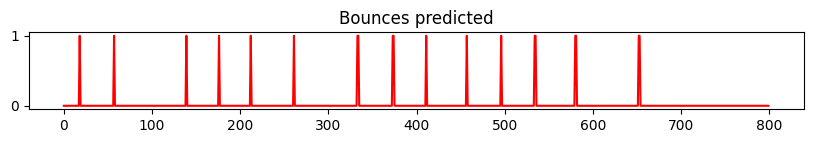

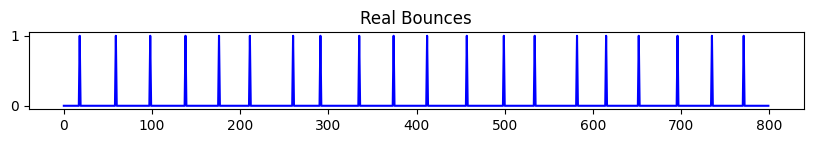

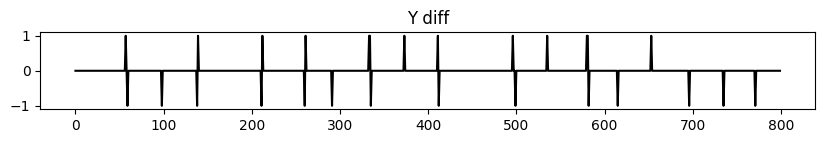

In [263]:
y_pred=display_pred_test(y_test_pred_proba,y_test,0.10)
df = pd.DataFrame(y_pred)
df.to_csv(r'/home/pguitteny/code/PhilippeGuitteny/final_tennis_exploration/SGDClassifier.csv', index=False, header=True)

In [ ]:
Kept 9 lags ( 4 in the past, 4 in the future) with a 2 step jump and 500 estimators


RESULT COMPARISON for Classifier

precision=TP/(TP+FP)
=


RANDOM FOREST Best Precision 0.977
[[780   0]
 [ 20   0]]

XGB Best Precision 0.965 
[[778   2]
 [ 18   2]]

SGDClassifier Best Precision is 0.973
[[687  93]
 [  4  16]]

SGDClassifier Best Precision is 0.977
[[456 324]
 [ 11   9]]


In [273]:
print(456/(456+11))



0.9764453961456103
